<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

#  Gravitational Wave Open Data Workshop #3


#### Tutorial 2.4: Parameter estimation on GW150914 using open data.

This example estimates the non-spinning parameters of the binary black hole system using
commonly used prior distributions. This will take about 40 minutes to run.
   
More examples at https://lscsoft.docs.ligo.org/bilby/examples.html

##  Installation  (execute only if running on a cloud platform!)

In [10]:
# -- Use the following line in Google Colab
#! pip install -q 'lalsuite==6.66' 'bilby==1.0.1' 'gwpy==1.0.1'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

We begin by importing some commonly used functions

In [11]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

## Bilby version

In [12]:
print(bilby.__version__)

1.0.1: release


## Getting the data: GW150914

In this notebook, we'll analyse GW150914. Our first task is to obtain some data!

We need to know the trigger time. This can be found on the [GWOSC page](https://www.gw-openscience.org/events/GW150914/), here we define it as a variable

In [13]:
time_of_event = 1126259462.4

### Set up empty interferometers

We need to get some data to analyse. We'll be using data from the Hanford (H1) and Livinston (L1) ground-based gravitational wave detectors. To organise ourselves, we'll create two "empty" interferometers. These are empty in the sense that they don't have any strain data. But, they know about the orientation and location of their respective namesakes. It may also be interesting to note that they are initialised with the planned design sensitivity power spectral density of advanced LIGO - we'll overwrite this later on, but it is often useful for simulations.

In [14]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

### Download the data

To analyse the signal, we need to download analyis data. Here, we will use [gwpy](https://gwpy.github.io/) to download the open strain data. For a general introduction to reading/writing data with gwpy, see [the documentation](https://gwpy.github.io/docs/stable/timeseries/).

To analyse GW150914, we will use a 4s period duration centered on the event itself. It is standard to choose the data such that it always includes a "post trigger duration of". That is, there is always 2s of data after the trigger time. We therefore define all times relative to the trigger time, duration and this post-trigger duration.

In [15]:
# Definite times in relatation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

/home/jotil/Tron/anaconda3/envs/igwn-py37/lib/python3.7/site-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


Here, `H1_analysis_data` and its L1 counterpart are gwpy TimeSeries objects. As such, we can plot the data itself out:

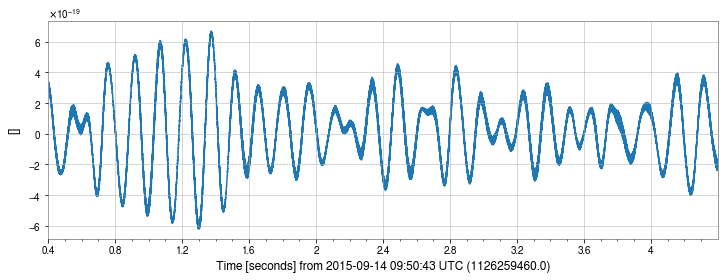

In [16]:
H1_analysis_data.plot()
plt.show()

This doesn't tell us much of course! It is dominated by the low frequency noise.

### Initialise the bilby inteferometers with the strain data

Now, we pass the downloaded strain data to our `H1` and `L1` bilby inteferometer objects. For other methods to set the strain data, see the various `set_strain_data*` methods.

In [17]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

### Download the power spectral data

Parameter estimation relies on having a power spectral density (PSD) - an estimate of the coloured noise properties of the data. Here, we will create a PSD using off-source data (for discussion on methods to estimate PSDs, see, e.g. [Chatziioannou et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvD.100j4004C/abstract)) 

Again, we need to download this from the open strain data. We start by figuring out the amount of data needed - in this case 32 times the analysis duration.

In [18]:
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

Having obtained the data to generate the PSD, we now use the standard [gwpy psd](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.psd) method to calculate the PSD. Here, the `psd_alpha` variable is converting the `roll_off` applied to the strain data into the fractional value used by `gwpy`.

In [19]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

### Initialise the PSD
Now that we have psd's for H1 and L1, we can overwrite the `power_spectal_density` attribute of our interferometers with a new PSD.

In [20]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)

### Looking at the data
Okay, we have spent a bit of time now downloading and initializing things. Let's check that everything makes sense. To do this, we'll plot our analysis data alongwise the amplitude spectral density (ASD); this is just the square root of the PSD and has the right units to be comparable to the frequency-domain strain data.

16:16 bilby INFO    : Generating frequency domain strain from given time domain strain.
16:16 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


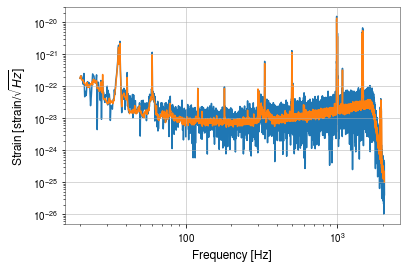

In [21]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

What is happening at high frequencies? This is an artifact of the downsampling applied to the data - note that we downloaded the 4096Hz data which is downsamples for 16384Hz. We aren't really interested in the data at these high frequencies so let's adjust the maximum frequency used in the analysis to 1024 Hz and plot things again.

In [22]:
H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

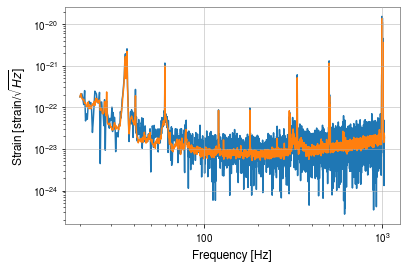

In [23]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

Okay, that is better - we now won't analyse any data near to the artifact produced by downsampling. Now we have some sensible data to analyse so let's get right on with down the analysis!

## Low dimensional analysis

In general a compact binary coalescense signal is described by 15 parameters describing the masses, spins, orientation, and position of the two compact objects along with a time at which the signal merges. The goal of parameter estimation is to figure out what the data (and any cogent prior information) can tell us about the likely values of these parameters - this is called the "posterior distribution of the parameters".

To start with, we'll analyse the data fixing all but a few of the parameters to known values (in Bayesian lingo - we use delta function priors), this will enable us to run things in a few minutes rather than the many hours needed to do full parameter estimation.

We'll start by thinking about the mass of the system. We call the heavier black hole the primary and label its mass $m_1$ and that of the secondary (lighter) black hole $m_2$. In this way, we always define $m_1 \ge m_2$. It turns out that inferences about $m_1$ and $m_2$ are highly correlated, we'll see exactly what this means later on.

Bayesian inference methods are powerful at figuring out highly correlated posteriors. But, we can help it along by sampling in parameters which are not highly correlated. In particular, we define a new parameter called the [chirp mass](https://en.wikipedia.org/wiki/Chirp_mass) to be

$$ \mathcal{M} = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}} $$

and the mass ratio

$$ q = \frac{m_{2}}{m_1} $$

If we sample (make inferences about) $\mathcal{M}$ and $q$, our code is much faster than if we use $m_1$ and $m_2$ directly! Note that so long as equivalent prior is given - one can also sample in the component masses themselves and you will get the same answer, it is just much slower!

Once we have inferred $\mathcal{M}$ and $q$, we can then derive $m_1$ and $m_2$ from the resulting samples (we'll do that in just a moment).

Okay, let's run a short (~1min on a single 2.8GHz core), low-dimensional parameter estimation analysis. This is done by defining a prior dictionary where all parameters are fixed, except those that we want to vary.

### Create a prior

Here, we create a prior fixing everything except the chirp mass, mass ratio, phase and geocent_time parameters to fixed values. The first two we described above. The second two give the phase of the system and the time at which it mergers.

In [24]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066


## Create a likelihood

For Bayesian inference, we need to evaluate the likelihood. In Bilby, we create a likelihood object. This is the communication interface between the sampling part of Bilby and the data. Explicitly, when Bilby is sampling it only uses the `parameters` and `log_likelihood()` of the likelihood object. This means the likelihood can be arbitrarily complicated and the sampling part of Bilby won't mind a bit!

Let's create a `GravitationalWaveTransient`, a special inbuilt method carefully designed to wrap up evaluating the likelihood of a waveform model in some data.

In [25]:
# First, put our "data" created above into a list of intererometers (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=False)

16:17 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


This will print a warning about the `start_time`, it is safe to ignore this.

Note that we also specify `time_marginalization=True` and `phase_marginalization=True`. This is a trick often used in Bayesian inference. We analytically marginalize (integrate) over the time/phase of the system while sampling, effectively reducing the parameter space and making it easier to sample. Bilby will then figure out (after the sampling) posteriors for these marginalized parameters. For an introduction to this topic, see [Thrane & Talbot (2019)](https://arxiv.org/abs/1809.02293).

### Run the analysis

Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run the sampler to get the posterior result. This function takes the likelihood and prior along with some options for how to do the sampling and how to save the data.

In [26]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="unif", nlive=500, dlogz=3  # <- Arguments are used to make things fast - not recommended for general use
)

16:17 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
16:17 bilby INFO    : Using lal version 6.21.0
16:17 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.66;Id: 04a60e3ac9b6ecb285cf96d1137c6a62a3d5cfde;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
16:17 bilby INFO    : Using lalsimulation version 1.10.0
16:17 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.66;Id: 04a60e3ac9b6ecb285cf96d1137c6a62a3d5cfde;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
16:17 bilby INFO    : Search parameters:
16:17 bilby INFO    :   chirp_mass = Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
16:17 bilby INFO    :   mass_ratio = Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
16:17 bilby INFO    :   time_jitter = Uniform(minimum=-0.000244140625, maximum=0.000

0it [00:00, ?it/s]

16:17 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fd600c102d0>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
16:17 bilby INFO    : Checkpoint every check_point_delta_t = 600s
16:17 bilby INFO    : Using dynesty version 1.0.1
16:17 bilby INFO    : Generating initial points from the prior


553it [01:22,  3.40it/s, bound:0 nc: 11 ncall:1.5e+03 eff:36.6% logz-ratio=263.64+/-0.08 dlogz:6.258>3] 

16:18 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle


972it [03:07,  3.90it/s, bound:0 nc:  4 ncall:3.2e+03 eff:30.0% logz-ratio=266.10+/-0.08 dlogz:3.006>3]

16:20 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
16:20 bilby INFO    : Writing 191 current samples to short/GW150914_samples.dat


972it [03:20,  4.86it/s, bound:0 nc:  1 ncall:3.2e+03 eff:45.4% logz-ratio=268.06+/-0.13 dlogz:0.005>3]



16:20 bilby INFO    : Sampling time: 0:02:41.466879
16:20 bilby INFO    : Reconstructing marginalised parameters.


100%|██████████| 1472/1472 [03:54<00:00,  6.28it/s]

16:24 bilby INFO    : Generating sky frame parameters.



100%|██████████| 1472/1472 [00:03<00:00, 411.08it/s]


16:25 bilby INFO    : Computing SNRs for every sample.


100%|██████████| 1472/1472 [02:11<00:00, 11.22it/s]


16:27 bilby INFO    : Summary of results:
nsamples: 1472
ln_noise_evidence: -8534.562
ln_evidence: -8266.503 +/-  0.130
ln_bayes_factor: 268.058 +/-  0.130



### Looking at the outputs

The `run_sampler` returned `result_short` - this is a Bilby result object. The posterior samples are stored in a [pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) (think of this like a spreadsheet), let's take a look at it

In [27]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,H1_matched_filter_snr,H1_optimal_snr,L1_matched_filter_snr,L1_optimal_snr
0,31.919249,0.670858,1.612452e-04,4.139602,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,41.329841,27.726462,29.353118,69.056302,(19.840089898323363-0.9559718321061438j),14.467327,(13.800142052000714-0.5800187859120742j),10.247290
1,30.505711,0.961334,1.249433e-04,2.363656,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,32.867640,31.596772,28.053221,64.464411,(19.69627863880758-2.21137538496029j),14.202116,(14.307917500586763-1.495880325158624j),10.111734
2,31.673318,0.708319,1.597140e-04,4.568582,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,39.872339,28.242321,29.126959,68.114660,(19.646131419296793-3.6413208067541314j),14.449493,(13.831008483900945-2.384167845118048j),10.246045
3,30.604918,0.837226,-2.743466e-05,5.282296,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,35.360605,29.604820,28.144453,64.965424,(19.91234217057647-0.186149870794527j),14.191106,(14.39908914364178+0.017952313091386382j),10.096657
4,30.530232,0.818168,-1.704520e-04,2.156361,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,35.690520,29.200857,28.075771,64.891377,(19.85595118698433+0.51166619071111j),14.147273,(14.359820933577934+0.6349289702828168j),10.065115
5,31.170230,0.680158,-1.077686e-04,4.451269,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,40.072421,27.255597,28.664317,67.328017,(20.02508724978139-0.16930353077777116j),14.206783,(14.215228092818181+0.008823426710093658j),10.077086
6,30.812211,0.705426,1.367242e-05,4.692066,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,38.870516,27.420254,28.335080,66.290769,(19.858878511537583+2.4084324708965577j),14.117867,(14.199479681506972+1.9451364463696057j),10.024714
7,31.486048,0.689164,-1.320197e-04,4.418041,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,40.203184,27.706600,28.954744,67.909783,(19.95104325467583-1.3351349085751931j),14.343411,(14.067586859732408-0.8516786834006925j),10.170451
8,32.070849,0.767011,-1.661014e-04,1.491778,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,38.750652,29.722167,29.492531,68.472819,(19.8122771765991-2.3155838723958464j),14.689196,(13.821078554674079-1.5251643813027438j),10.418239
9,30.607805,0.734766,4.971906e-05,4.846363,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,37.808759,27.780602,28.147107,65.589361,(19.626379904454158+3.624792595423755j),14.085299,(14.107297830654874+2.7775961000893115j),10.009792


We can pull out specific parameters that we are interested in

In [28]:
result_short.posterior["chirp_mass"]

0       31.919249
1       30.505711
2       31.673318
3       30.604918
4       30.530232
5       31.170230
6       30.812211
7       31.486048
8       32.070849
9       30.607805
10      30.620089
11      31.571135
12      30.680783
13      30.620473
14      32.439551
15      30.705130
16      31.421675
17      30.624188
18      30.781633
19      30.937632
20      31.914552
21      30.742494
22      30.877620
23      32.338295
24      31.215443
25      31.067876
26      31.171501
27      31.406511
28      30.733104
29      31.395823
          ...    
1442    31.465395
1443    31.465395
1444    31.465395
1445    31.465395
1446    31.465395
1447    31.465395
1448    31.465395
1449    31.484015
1450    31.484015
1451    31.484015
1452    31.484015
1453    31.484015
1454    31.484015
1455    31.484015
1456    31.484015
1457    31.538015
1458    31.538015
1459    31.538015
1460    31.538015
1461    31.538015
1462    31.538015
1463    31.538015
1464    31.362224
1465    31.362224
1466    31

This returned another `pandas` object. If you just want to get the numbers as a numpy array run

In [29]:
Mc = result_short.posterior["chirp_mass"].values

We can then get some useful quantities such as the 90\% credible interval

In [30]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 31.428028574106154 with a 90% C.I = 30.95363131198408 -> 31.963598955318503


We can then plot the chirp mass in a histogram adding a region to indicate the 90\% C.I.

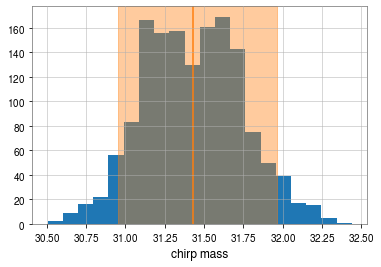

In [31]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

The result object also has in-built methods to make nice plots such as corner plots. You can add the priors if you are only plotting parameter which you sampled in, e.g.

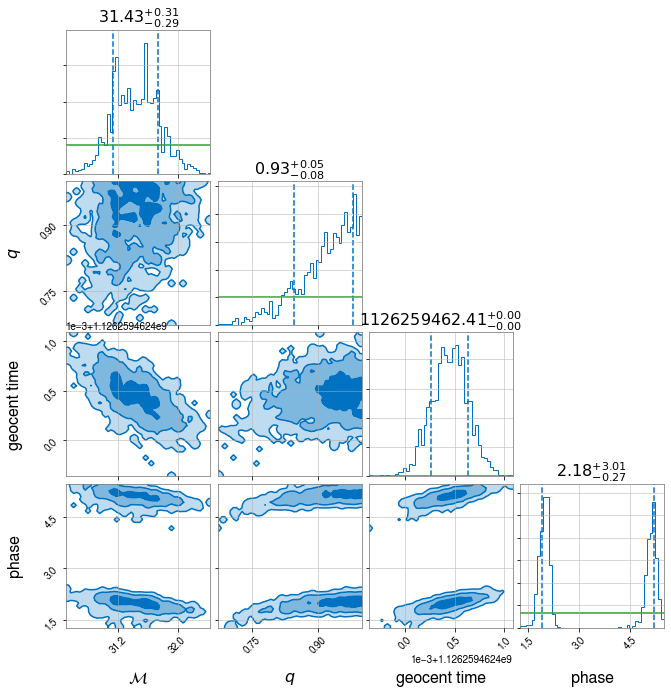

In [32]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"], priors=True)

You can also plot lines indicating specific points. Here, we add the values recorded on [GWOSC](https://www.gw-openscience.org/events/GW150914/). Notably, these fall outside the bulk of the posterior uncertainty here. This is because we limited our prior - if instead we ran the full analysis these agree nicely.

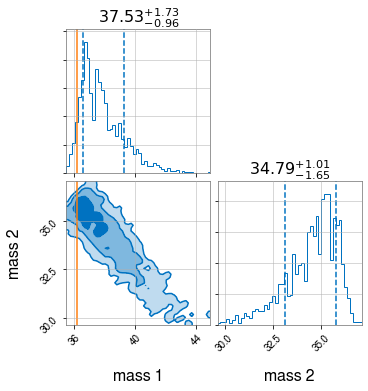

In [33]:
parameters = dict(mass_1=36.2, mass_2=29.1)
result_short.plot_corner(parameters)

Earlier we discussed the "correlation" - in this plot we start to see the correlation between $m_1$ and $m_2$.

### Meta data
The result object also stores meta data, like the priors

In [34]:
result_short.priors

{'chirp_mass': Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None),
 'geocent_time': Uniform(minimum=1126259462.3000002, maximum=1126259462.5, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None),
 'a_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_12': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'dec': DeltaFunction(peak=-1.2232, name=None, 

and details of the analysis itself:

In [35]:
result_short.sampler_kwargs["nlive"]

500

Finally, we can also get out the Bayes factor for the signal vs. Gaussian noise:

In [36]:
print("ln Bayes factor = {} +/- {}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

ln Bayes factor = 268.0582505030051 +/- 0.1298991918387898


## Challenge questions
First, let's take a closer look at the result obtained with the run above. What are the means of the chirp mass and mass ratio distributions? What are the medians of the distributions for the components masses? You can use `np.mean` and `np.median` to calculate these.

Now let's expand on this example a bit. Rerun the analysis above but change the prior on the distance from a delta function to `bilby.core.prior.PowerLaw(alpha=2., minimum=50., maximum=800., name='luminosity_distance')`. You should also replace `sample='unif'` with `sample="rwalk", nact=1, walks=1` in your call to `bilby.run_sampler` above. This will take a bit longer than the original run, around ~20 minutes. You also need to change the `label` in the call to `run_sampler` to avoid over-writing your results.

What is the median reported value of the distance posterior? What is the new log Bayes factor for signal vs. Gaussian noise? Don't be alarmed if your results do not match the official LVC results, as these are not rigorous settings.

In [37]:
chirp_mass_mean = np.mean(Mc)
chirp_mass_median = np.median(Mc)
Mr = result_short.posterior["mass_ratio"].values
mass_ratio_mean = np.mean(Mr)
mass_ratio_median = np.median(Mr)

print('The mean of the chirp mass is',chirp_mass_mean)
print('The median of the chirp mass is',chirp_mass_median)
print('The mean of the mass ratio is',mass_ratio_mean)
print('The median of the mass ratio is',mass_ratio_median)

The mean of the chirp mass is 31.43152124705227
The median of the chirp mass is 31.428028574106154
The mean of the mass ratio is 0.9145568397352934
The median of the mass ratio is 0.9275864993497596


In [38]:
m1 = (Mc*((1+Mr)**(1/5)))/(Mr**(3/5))

m2 = m1 * Mr

m1_mean = np.mean(m1)
m2_mean = np.mean(m2)
m1_median = np.median(m1)
m2_median = np.median(m2)

print('The mean of the first component mass is',m1_mean)
print('The median of the first component mass is',m1_median)
print('The mean of the second component mass is',m2_mean)
print('The median of the second component mass is',m2_median)

The mean of the first component mass is 37.84178225507116
The median of the first component mass is 37.53382929900638
The mean of the second component mass is 34.51939321910813
The median of the second component mass is 34.7908449605184


In [39]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

In [40]:
time_of_event = 1126259462.4

In [41]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

In [42]:
# Definite times in relatation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

/home/jotil/Tron/anaconda3/envs/igwn-py37/lib/python3.7/site-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


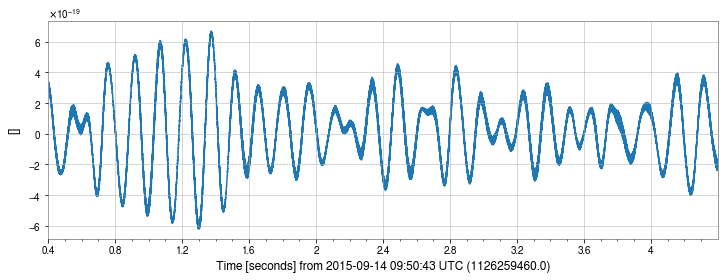

In [43]:
H1_analysis_data.plot()
plt.show()

In [44]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

In [45]:
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

In [46]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

In [47]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)

16:29 bilby INFO    : Generating frequency domain strain from given time domain strain.
16:29 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


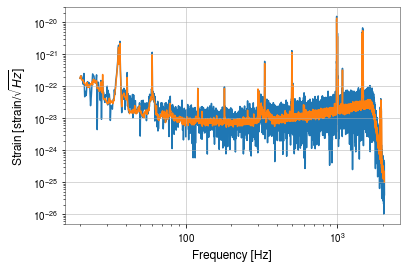

In [48]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

In [49]:
H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

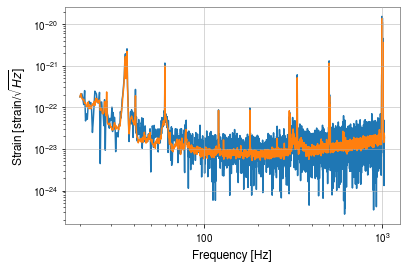

In [50]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

In [51]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = bilby.core.prior.PowerLaw(alpha=2., minimum=50., maximum=800., name='luminosity_distance')


In [52]:
# First, put our "data" created above into a list of intererometers (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=False)

16:30 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [55]:
result_short1 = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short1', label="GW150914_1",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="rwalk", nact=1, walks=1  # <- Arguments are used to make things fast - not recommended for general use
)

16:39 bilby INFO    : Running for label 'GW150914_1', output will be saved to 'short1'
16:39 bilby INFO    : Using lal version 6.21.0
16:39 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.66;Id: 04a60e3ac9b6ecb285cf96d1137c6a62a3d5cfde;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
16:39 bilby INFO    : Using lalsimulation version 1.10.0
16:39 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.66;Id: 04a60e3ac9b6ecb285cf96d1137c6a62a3d5cfde;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
16:39 bilby INFO    : Search parameters:
16:39 bilby INFO    :   chirp_mass = Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
16:39 bilby INFO    :   mass_ratio = Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
16:39 bilby INFO    :   luminosity_distance = PowerLaw(alpha=2.0, minimum=50.0, m



0it [00:00, ?it/s]

16:39 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 1, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fd5fb6b70d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 1}
16:39 bilby INFO    : Checkpoint every check_point_delta_t = 600s
16:39 bilby INFO    : Using dynesty version 1.0.1
16:39 bilby INFO    : Generating initial points from the prio



1it [01:02, 62.66s/it, bound:0 nc:  1 ncall:1.0e+03 eff:0.1% logz-ratio=-1109.77+/-0.12 dlogz:inf>0.1]

3it [01:02, 43.89s/it, bound:0 nc:  1 ncall:1.0e+03 eff:0.3% logz-ratio=-817.10+/-0.12 dlogz:1221.287>0.1]

5it [01:03, 30.75s/it, bound:0 nc:  1 ncall:1.0e+03 eff:0.5% logz-ratio=-67.14+/-0.12 dlogz:738.844>0.1]  

7it [01:03, 21.55s/it, bound:0 nc:  1 ncall:1.0e+03 eff:0.7% logz-ratio=63.28+/-0.12 dlogz:275.503>0.1] 

9it [01:03, 15.11s/it, bound:0 nc:  1 ncall:1.0e+03 eff:0.9% logz-ratio=78.20+/-0.12 dlogz:218.418>0.1]

11it [01:03, 10.60s/it, bound:0 nc:  1 ncall:1.0e+03 eff:1.1% logz-ratio=81.46+/-0.12 dlogz:213.502>0.1]

13it [01:03,  7.44s/it, bound:0 nc:  1 ncall:1.0e+03 eff:1.3% logz-ratio=147.09+/-0.12 dlogz:210.457>0.1]

15it [01:03,  5.23s/it, bound:0 nc:  1 ncall:1.0e+03 eff:1.5% logz-ratio=152.47+/-0.12 dlogz:143.136>0.1]

17it [01:03,  3.68s/it, bound:0 nc:  1 ncall:1.0e+03 eff:1.7% logz-ratio=154.11+/-0.11 dlogz:139.535>0.1]

19it [01:04,  2.60s/it, bound:0 nc:  1 n

145it [01:14, 12.04it/s, bound:0 nc:  1 ncall:1.2e+03 eff:12.5% logz-ratio=171.34+/-0.08 dlogz:121.627>0.1]

147it [01:15, 11.28it/s, bound:0 nc:  2 ncall:1.2e+03 eff:12.7% logz-ratio=171.46+/-0.08 dlogz:121.501>0.1]

149it [01:15, 11.88it/s, bound:0 nc:  1 ncall:1.2e+03 eff:12.8% logz-ratio=171.57+/-0.08 dlogz:121.382>0.1]

151it [01:15, 12.44it/s, bound:0 nc:  1 ncall:1.2e+03 eff:13.0% logz-ratio=171.68+/-0.08 dlogz:121.272>0.1]

153it [01:15, 12.92it/s, bound:0 nc:  1 ncall:1.2e+03 eff:13.1% logz-ratio=171.78+/-0.08 dlogz:121.167>0.1]

155it [01:15, 13.17it/s, bound:0 nc:  1 ncall:1.2e+03 eff:13.2% logz-ratio=171.88+/-0.08 dlogz:121.065>0.1]

157it [01:15, 13.18it/s, bound:0 nc:  1 ncall:1.2e+03 eff:13.4% logz-ratio=171.99+/-0.08 dlogz:120.955>0.1]

159it [01:16, 13.49it/s, bound:0 nc:  1 ncall:1.2e+03 eff:13.5% logz-ratio=172.10+/-0.08 dlogz:120.845>0.1]

161it [01:16, 13.54it/s, bound:0 nc:  1 ncall:1.2e+03 eff:13.7% logz-ratio=172.20+/-0.08 dlogz:120.742>0.1]

163it [01:16, 12.10

284it [01:27, 10.78it/s, bound:0 nc:  2 ncall:1.3e+03 eff:21.1% logz-ratio=177.84+/-0.08 dlogz:114.979>0.1]

286it [01:28, 11.63it/s, bound:0 nc:  1 ncall:1.3e+03 eff:21.2% logz-ratio=177.94+/-0.08 dlogz:114.874>0.1]

288it [01:28, 12.23it/s, bound:0 nc:  1 ncall:1.3e+03 eff:21.3% logz-ratio=178.04+/-0.08 dlogz:114.771>0.1]

290it [01:28, 11.38it/s, bound:0 nc:  2 ncall:1.4e+03 eff:21.4% logz-ratio=178.16+/-0.08 dlogz:114.667>0.1]

292it [01:28, 12.10it/s, bound:0 nc:  1 ncall:1.4e+03 eff:21.6% logz-ratio=178.28+/-0.08 dlogz:114.539>0.1]

294it [01:28, 12.55it/s, bound:0 nc:  1 ncall:1.4e+03 eff:21.7% logz-ratio=178.41+/-0.08 dlogz:114.409>0.1]

296it [01:28, 11.47it/s, bound:0 nc:  2 ncall:1.4e+03 eff:21.8% logz-ratio=178.53+/-0.08 dlogz:114.279>0.1]

298it [01:29, 12.15it/s, bound:0 nc:  1 ncall:1.4e+03 eff:21.9% logz-ratio=178.65+/-0.08 dlogz:114.160>0.1]

300it [01:29, 12.50it/s, bound:0 nc:  1 ncall:1.4e+03 eff:22.0% logz-ratio=178.77+/-0.08 dlogz:114.040>0.1]

302it [01:29, 12.83

421it [01:40, 11.89it/s, bound:0 nc:  1 ncall:1.5e+03 eff:27.5% logz-ratio=184.42+/-0.08 dlogz:108.244>0.1]

423it [01:41, 10.01it/s, bound:0 nc:  1 ncall:1.5e+03 eff:27.6% logz-ratio=184.50+/-0.08 dlogz:108.168>0.1]

425it [01:41, 10.00it/s, bound:0 nc:  2 ncall:1.5e+03 eff:27.7% logz-ratio=184.57+/-0.08 dlogz:108.092>0.1]

427it [01:41,  9.09it/s, bound:0 nc:  3 ncall:1.5e+03 eff:27.7% logz-ratio=184.64+/-0.08 dlogz:108.020>0.1]

428it [01:41,  8.20it/s, bound:0 nc:  2 ncall:1.5e+03 eff:27.7% logz-ratio=184.67+/-0.08 dlogz:107.986>0.1]

429it [01:42,  6.75it/s, bound:0 nc:  3 ncall:1.5e+03 eff:27.7% logz-ratio=184.70+/-0.08 dlogz:107.951>0.1]

431it [01:42,  7.97it/s, bound:0 nc:  1 ncall:1.5e+03 eff:27.8% logz-ratio=184.77+/-0.08 dlogz:107.881>0.1]

432it [01:42,  7.62it/s, bound:0 nc:  2 ncall:1.6e+03 eff:27.9% logz-ratio=184.80+/-0.08 dlogz:107.847>0.1]

433it [01:42,  7.40it/s, bound:0 nc:  2 ncall:1.6e+03 eff:27.9% logz-ratio=184.84+/-0.08 dlogz:107.813>0.1]

435it [01:42,  8.58

541it [01:55,  6.32it/s, bound:0 nc:  2 ncall:1.7e+03 eff:31.2% logz-ratio=189.63+/-0.08 dlogz:104.152>0.1]

542it [01:55,  6.48it/s, bound:0 nc:  2 ncall:1.7e+03 eff:31.2% logz-ratio=189.68+/-0.08 dlogz:104.106>0.1]

543it [01:55,  6.63it/s, bound:0 nc:  2 ncall:1.7e+03 eff:31.2% logz-ratio=189.73+/-0.08 dlogz:104.058>0.1]

545it [01:55,  7.74it/s, bound:0 nc:  1 ncall:1.7e+03 eff:31.3% logz-ratio=189.82+/-0.08 dlogz:103.965>0.1]

547it [01:55,  8.89it/s, bound:0 nc:  1 ncall:1.7e+03 eff:31.4% logz-ratio=189.90+/-0.08 dlogz:103.874>0.1]

549it [01:56,  9.06it/s, bound:0 nc:  2 ncall:1.7e+03 eff:31.4% logz-ratio=189.99+/-0.08 dlogz:103.785>0.1]

551it [01:56, 10.21it/s, bound:0 nc:  1 ncall:1.7e+03 eff:31.5% logz-ratio=190.07+/-0.08 dlogz:103.701>0.1]

553it [01:56,  9.97it/s, bound:0 nc:  2 ncall:1.8e+03 eff:31.6% logz-ratio=190.15+/-0.08 dlogz:103.618>0.1]

555it [01:56,  9.11it/s, bound:0 nc:  3 ncall:1.8e+03 eff:31.6% logz-ratio=190.23+/-0.08 dlogz:103.536>0.1]

556it [01:56,  7.24

651it [02:09,  6.71it/s, bound:0 nc:  2 ncall:1.9e+03 eff:33.5% logz-ratio=195.09+/-0.08 dlogz:98.598>0.1]

653it [02:09,  7.94it/s, bound:0 nc:  1 ncall:1.9e+03 eff:33.6% logz-ratio=195.20+/-0.08 dlogz:98.486>0.1]

655it [02:09,  9.09it/s, bound:0 nc:  1 ncall:1.9e+03 eff:33.7% logz-ratio=195.32+/-0.08 dlogz:98.368>0.1]

657it [02:09,  9.96it/s, bound:0 nc:  1 ncall:1.9e+03 eff:33.7% logz-ratio=195.43+/-0.08 dlogz:98.253>0.1]

659it [02:10,  8.96it/s, bound:0 nc:  1 ncall:2.0e+03 eff:33.8% logz-ratio=195.54+/-0.08 dlogz:98.137>0.1]

661it [02:10, 10.09it/s, bound:0 nc:  1 ncall:2.0e+03 eff:33.8% logz-ratio=195.65+/-0.08 dlogz:98.023>0.1]

663it [02:10, 11.07it/s, bound:0 nc:  1 ncall:2.0e+03 eff:33.9% logz-ratio=195.76+/-0.08 dlogz:97.915>0.1]

665it [02:10, 10.65it/s, bound:0 nc:  1 ncall:2.0e+03 eff:34.0% logz-ratio=195.87+/-0.09 dlogz:97.806>0.1]

667it [02:11,  5.83it/s, bound:0 nc: 10 ncall:2.0e+03 eff:33.9% logz-ratio=195.97+/-0.09 dlogz:97.693>0.1]

669it [02:11,  7.09it/s, bou

763it [02:25,  8.60it/s, bound:0 nc:  1 ncall:2.2e+03 eff:35.2% logz-ratio=200.28+/-0.08 dlogz:93.280>0.1]

764it [02:25,  6.08it/s, bound:0 nc:  4 ncall:2.2e+03 eff:35.2% logz-ratio=200.32+/-0.08 dlogz:93.236>0.1]

766it [02:25,  5.06it/s, bound:0 nc:  7 ncall:2.2e+03 eff:35.2% logz-ratio=200.41+/-0.08 dlogz:93.147>0.1]

768it [02:26,  6.24it/s, bound:0 nc:  1 ncall:2.2e+03 eff:35.2% logz-ratio=200.50+/-0.08 dlogz:93.060>0.1]

770it [02:26,  6.97it/s, bound:0 nc:  2 ncall:2.2e+03 eff:35.3% logz-ratio=200.59+/-0.08 dlogz:92.966>0.1]

771it [02:26,  5.56it/s, bound:0 nc:  4 ncall:2.2e+03 eff:35.3% logz-ratio=200.64+/-0.08 dlogz:92.919>0.1]

773it [02:26,  6.80it/s, bound:0 nc:  1 ncall:2.2e+03 eff:35.3% logz-ratio=200.73+/-0.08 dlogz:92.826>0.1]

774it [02:26,  6.93it/s, bound:0 nc:  2 ncall:2.2e+03 eff:35.3% logz-ratio=200.77+/-0.08 dlogz:92.781>0.1]

776it [02:26,  8.16it/s, bound:0 nc:  1 ncall:2.2e+03 eff:35.4% logz-ratio=200.86+/-0.08 dlogz:92.687>0.1]

778it [02:27,  9.03it/s, bou

861it [02:42,  3.66it/s, bound:0 nc:  6 ncall:2.4e+03 eff:35.8% logz-ratio=204.56+/-0.09 dlogz:88.904>0.1]

863it [02:43,  3.73it/s, bound:0 nc:  6 ncall:2.4e+03 eff:35.8% logz-ratio=204.64+/-0.09 dlogz:88.820>0.1]

864it [02:43,  4.33it/s, bound:0 nc:  2 ncall:2.4e+03 eff:35.8% logz-ratio=204.68+/-0.09 dlogz:88.780>0.1]

865it [02:44,  2.72it/s, bound:0 nc:  8 ncall:2.4e+03 eff:35.8% logz-ratio=204.71+/-0.09 dlogz:88.741>0.1]

866it [02:44,  2.73it/s, bound:0 nc:  4 ncall:2.4e+03 eff:35.7% logz-ratio=204.75+/-0.09 dlogz:88.702>0.1]

867it [02:44,  3.16it/s, bound:0 nc:  2 ncall:2.4e+03 eff:35.8% logz-ratio=204.79+/-0.09 dlogz:88.663>0.1]

868it [02:45,  2.99it/s, bound:0 nc:  4 ncall:2.4e+03 eff:35.7% logz-ratio=204.83+/-0.09 dlogz:88.623>0.1]

869it [02:45,  3.73it/s, bound:0 nc:  1 ncall:2.4e+03 eff:35.8% logz-ratio=204.87+/-0.09 dlogz:88.584>0.1]

870it [02:45,  3.21it/s, bound:0 nc:  5 ncall:2.4e+03 eff:35.7% logz-ratio=204.90+/-0.09 dlogz:88.545>0.1]

871it [02:45,  4.01it/s, bou

941it [03:00,  4.05it/s, bound:0 nc:  3 ncall:2.6e+03 eff:36.1% logz-ratio=207.79+/-0.09 dlogz:85.590>0.1]

942it [03:00,  4.47it/s, bound:0 nc:  2 ncall:2.6e+03 eff:36.1% logz-ratio=207.83+/-0.09 dlogz:85.549>0.1]

943it [03:01,  5.08it/s, bound:0 nc:  1 ncall:2.6e+03 eff:36.1% logz-ratio=207.87+/-0.09 dlogz:85.507>0.1]

945it [03:01,  4.01it/s, bound:0 nc:  9 ncall:2.6e+03 eff:36.0% logz-ratio=207.95+/-0.09 dlogz:85.423>0.1]

946it [03:02,  3.36it/s, bound:0 nc:  5 ncall:2.6e+03 eff:36.0% logz-ratio=207.99+/-0.09 dlogz:85.382>0.1]

947it [03:02,  3.41it/s, bound:0 nc:  3 ncall:2.6e+03 eff:36.0% logz-ratio=208.03+/-0.09 dlogz:85.342>0.1]

948it [03:02,  3.54it/s, bound:0 nc:  3 ncall:2.6e+03 eff:36.0% logz-ratio=208.07+/-0.09 dlogz:85.303>0.1]

949it [03:02,  4.02it/s, bound:0 nc:  2 ncall:2.6e+03 eff:36.0% logz-ratio=208.11+/-0.09 dlogz:85.265>0.1]

950it [03:02,  4.84it/s, bound:0 nc:  1 ncall:2.6e+03 eff:36.0% logz-ratio=208.14+/-0.09 dlogz:85.226>0.1]

952it [03:03,  4.62it/s, bou

1021it [03:17,  3.25it/s, bound:0 nc:  3 ncall:2.8e+03 eff:36.3% logz-ratio=210.90+/-0.09 dlogz:82.404>0.1]

1023it [03:18,  4.22it/s, bound:0 nc:  1 ncall:2.8e+03 eff:36.3% logz-ratio=210.98+/-0.09 dlogz:82.318>0.1]

1024it [03:18,  4.47it/s, bound:0 nc:  2 ncall:2.8e+03 eff:36.4% logz-ratio=211.02+/-0.09 dlogz:82.276>0.1]

1025it [03:18,  4.63it/s, bound:0 nc:  2 ncall:2.8e+03 eff:36.4% logz-ratio=211.06+/-0.09 dlogz:82.234>0.1]

1027it [03:19,  4.42it/s, bound:0 nc:  5 ncall:2.8e+03 eff:36.4% logz-ratio=211.15+/-0.09 dlogz:82.151>0.1]

1028it [03:19,  4.61it/s, bound:0 nc:  2 ncall:2.8e+03 eff:36.4% logz-ratio=211.19+/-0.09 dlogz:82.108>0.1]

1029it [03:19,  4.20it/s, bound:0 nc:  3 ncall:2.8e+03 eff:36.4% logz-ratio=211.24+/-0.09 dlogz:82.062>0.1]

1030it [03:19,  3.97it/s, bound:0 nc:  3 ncall:2.8e+03 eff:36.4% logz-ratio=211.29+/-0.09 dlogz:82.013>0.1]

1031it [03:19,  4.25it/s, bound:0 nc:  2 ncall:2.8e+03 eff:36.4% logz-ratio=211.34+/-0.09 dlogz:81.963>0.1]

1032it [03:20,  4.4

1098it [03:41,  2.42it/s, bound:0 nc:  6 ncall:3.0e+03 eff:36.1% logz-ratio=214.01+/-0.09 dlogz:79.213>0.1]

1099it [03:41,  3.04it/s, bound:0 nc:  1 ncall:3.0e+03 eff:36.1% logz-ratio=214.04+/-0.09 dlogz:79.177>0.1]

1100it [03:41,  2.99it/s, bound:0 nc:  3 ncall:3.0e+03 eff:36.1% logz-ratio=214.09+/-0.09 dlogz:79.137>0.1]

1101it [03:42,  3.66it/s, bound:0 nc:  1 ncall:3.0e+03 eff:36.2% logz-ratio=214.12+/-0.09 dlogz:79.095>0.1]

1102it [03:42,  4.15it/s, bound:0 nc:  1 ncall:3.0e+03 eff:36.2% logz-ratio=214.16+/-0.09 dlogz:79.055>0.1]

1103it [03:42,  3.50it/s, bound:0 nc:  3 ncall:3.0e+03 eff:36.2% logz-ratio=214.20+/-0.09 dlogz:79.016>0.1]

1104it [03:42,  3.58it/s, bound:0 nc:  2 ncall:3.1e+03 eff:36.2% logz-ratio=214.24+/-0.09 dlogz:78.976>0.1]

1105it [03:43,  3.55it/s, bound:0 nc:  2 ncall:3.1e+03 eff:36.2% logz-ratio=214.28+/-0.09 dlogz:78.937>0.1]

1106it [03:43,  3.25it/s, bound:0 nc:  3 ncall:3.1e+03 eff:36.2% logz-ratio=214.32+/-0.09 dlogz:78.896>0.1]

1107it [03:43,  3.7

1171it [04:04,  2.77it/s, bound:0 nc:  4 ncall:3.3e+03 eff:35.8% logz-ratio=217.38+/-0.09 dlogz:75.777>0.1]

1172it [04:05,  2.51it/s, bound:0 nc:  6 ncall:3.3e+03 eff:35.7% logz-ratio=217.43+/-0.09 dlogz:75.727>0.1]

1173it [04:05,  2.67it/s, bound:0 nc:  4 ncall:3.3e+03 eff:35.7% logz-ratio=217.48+/-0.09 dlogz:75.676>0.1]

1174it [04:06,  2.44it/s, bound:0 nc:  6 ncall:3.3e+03 eff:35.7% logz-ratio=217.53+/-0.09 dlogz:75.627>0.1]

1175it [04:06,  2.64it/s, bound:0 nc:  4 ncall:3.3e+03 eff:35.7% logz-ratio=217.57+/-0.09 dlogz:75.580>0.1]

1176it [04:06,  3.20it/s, bound:0 nc:  2 ncall:3.3e+03 eff:35.7% logz-ratio=217.61+/-0.09 dlogz:75.535>0.1]

1177it [04:06,  3.15it/s, bound:0 nc:  4 ncall:3.3e+03 eff:35.7% logz-ratio=217.66+/-0.09 dlogz:75.490>0.1]

1178it [04:07,  3.07it/s, bound:0 nc:  4 ncall:3.3e+03 eff:35.7% logz-ratio=217.70+/-0.09 dlogz:75.447>0.1]

1179it [04:07,  3.28it/s, bound:0 nc:  3 ncall:3.3e+03 eff:35.7% logz-ratio=217.74+/-0.09 dlogz:75.405>0.1]

1180it [04:07,  4.0

1243it [04:27,  6.34it/s, bound:0 nc:  1 ncall:3.5e+03 eff:35.4% logz-ratio=220.37+/-0.09 dlogz:72.706>0.1]

1244it [04:27,  6.72it/s, bound:0 nc:  1 ncall:3.5e+03 eff:35.4% logz-ratio=220.41+/-0.09 dlogz:72.664>0.1]

1245it [04:28,  2.99it/s, bound:0 nc:  8 ncall:3.5e+03 eff:35.3% logz-ratio=220.45+/-0.09 dlogz:72.622>0.1]

1246it [04:29,  2.04it/s, bound:0 nc:  9 ncall:3.5e+03 eff:35.3% logz-ratio=220.49+/-0.09 dlogz:72.581>0.1]

1247it [04:29,  2.37it/s, bound:0 nc:  3 ncall:3.5e+03 eff:35.3% logz-ratio=220.53+/-0.09 dlogz:72.541>0.1]

1248it [04:29,  2.09it/s, bound:0 nc:  7 ncall:3.5e+03 eff:35.2% logz-ratio=220.57+/-0.09 dlogz:72.500>0.1]

1249it [04:30,  2.28it/s, bound:0 nc:  4 ncall:3.5e+03 eff:35.2% logz-ratio=220.61+/-0.09 dlogz:72.459>0.1]

1251it [04:30,  2.50it/s, bound:0 nc:  6 ncall:3.6e+03 eff:35.2% logz-ratio=220.69+/-0.09 dlogz:72.380>0.1]

1252it [04:31,  2.26it/s, bound:0 nc:  6 ncall:3.6e+03 eff:35.2% logz-ratio=220.73+/-0.09 dlogz:72.340>0.1]

1253it [04:31,  2.9

1320it [04:52,  4.85it/s, bound:0 nc:  1 ncall:3.8e+03 eff:34.8% logz-ratio=223.36+/-0.09 dlogz:69.651>0.1]

1321it [04:52,  3.23it/s, bound:0 nc:  6 ncall:3.8e+03 eff:34.8% logz-ratio=223.40+/-0.09 dlogz:69.605>0.1]

1322it [04:53,  2.60it/s, bound:0 nc:  6 ncall:3.8e+03 eff:34.7% logz-ratio=223.44+/-0.09 dlogz:69.559>0.1]

1323it [04:53,  3.12it/s, bound:0 nc:  2 ncall:3.8e+03 eff:34.8% logz-ratio=223.49+/-0.09 dlogz:69.515>0.1]

1324it [04:54,  2.60it/s, bound:0 nc:  6 ncall:3.8e+03 eff:34.7% logz-ratio=223.53+/-0.09 dlogz:69.470>0.1]

1326it [04:54,  3.40it/s, bound:0 nc:  1 ncall:3.8e+03 eff:34.8% logz-ratio=223.62+/-0.09 dlogz:69.380>0.1]

1327it [04:54,  4.19it/s, bound:0 nc:  1 ncall:3.8e+03 eff:34.8% logz-ratio=223.66+/-0.09 dlogz:69.336>0.1]

1328it [04:54,  2.77it/s, bound:0 nc:  7 ncall:3.8e+03 eff:34.7% logz-ratio=223.70+/-0.09 dlogz:69.294>0.1]

1329it [04:55,  2.72it/s, bound:0 nc:  4 ncall:3.8e+03 eff:34.7% logz-ratio=223.74+/-0.09 dlogz:69.252>0.1]

1330it [04:55,  3.1

1394it [05:15,  2.59it/s, bound:0 nc:  7 ncall:4.0e+03 eff:34.7% logz-ratio=226.34+/-0.09 dlogz:66.584>0.1]

1395it [05:16,  1.53it/s, bound:0 nc: 10 ncall:4.0e+03 eff:34.7% logz-ratio=226.39+/-0.09 dlogz:66.542>0.1]

1396it [05:17,  1.89it/s, bound:0 nc:  2 ncall:4.0e+03 eff:34.7% logz-ratio=226.43+/-0.09 dlogz:66.500>0.1]

1397it [05:18,  1.36it/s, bound:0 nc: 13 ncall:4.0e+03 eff:34.6% logz-ratio=226.46+/-0.09 dlogz:66.459>0.1]

1398it [05:19,  1.26it/s, bound:0 nc:  9 ncall:4.0e+03 eff:34.5% logz-ratio=226.50+/-0.09 dlogz:66.420>0.1]

1399it [05:19,  1.68it/s, bound:0 nc:  1 ncall:4.0e+03 eff:34.6% logz-ratio=226.54+/-0.09 dlogz:66.380>0.1]

1400it [05:19,  1.66it/s, bound:0 nc:  6 ncall:4.1e+03 eff:34.5% logz-ratio=226.58+/-0.09 dlogz:66.342>0.1]

1401it [05:20,  1.84it/s, bound:0 nc:  4 ncall:4.1e+03 eff:34.5% logz-ratio=226.61+/-0.09 dlogz:66.305>0.1]

1402it [05:20,  2.39it/s, bound:0 nc:  1 ncall:4.1e+03 eff:34.5% logz-ratio=226.65+/-0.09 dlogz:66.266>0.1]

1403it [05:21,  2.1

1465it [05:51,  1.57it/s, bound:0 nc:  9 ncall:4.4e+03 eff:33.4% logz-ratio=228.95+/-0.09 dlogz:63.895>0.1]

1466it [05:51,  1.65it/s, bound:0 nc:  6 ncall:4.4e+03 eff:33.4% logz-ratio=228.98+/-0.09 dlogz:63.864>0.1]

1467it [05:52,  1.60it/s, bound:0 nc:  9 ncall:4.4e+03 eff:33.3% logz-ratio=229.01+/-0.09 dlogz:63.832>0.1]

1468it [05:52,  2.02it/s, bound:0 nc:  2 ncall:4.4e+03 eff:33.4% logz-ratio=229.04+/-0.09 dlogz:63.801>0.1]

1469it [05:53,  1.39it/s, bound:0 nc: 15 ncall:4.4e+03 eff:33.3% logz-ratio=229.07+/-0.09 dlogz:63.771>0.1]

1470it [05:54,  1.78it/s, bound:0 nc:  2 ncall:4.4e+03 eff:33.3% logz-ratio=229.10+/-0.09 dlogz:63.741>0.1]

1471it [05:54,  2.26it/s, bound:0 nc:  2 ncall:4.4e+03 eff:33.3% logz-ratio=229.13+/-0.09 dlogz:63.709>0.1]

1472it [05:54,  2.41it/s, bound:0 nc:  4 ncall:4.4e+03 eff:33.3% logz-ratio=229.17+/-0.09 dlogz:63.675>0.1]

1473it [05:55,  1.98it/s, bound:0 nc: 10 ncall:4.4e+03 eff:33.2% logz-ratio=229.20+/-0.09 dlogz:63.642>0.1]

1474it [05:55,  2.1

1537it [06:19,  3.66it/s, bound:0 nc:  1 ncall:4.7e+03 eff:32.9% logz-ratio=231.57+/-0.09 dlogz:61.208>0.1]

1538it [06:20,  2.27it/s, bound:0 nc: 10 ncall:4.7e+03 eff:32.8% logz-ratio=231.61+/-0.09 dlogz:61.172>0.1]

1539it [06:20,  2.55it/s, bound:0 nc:  3 ncall:4.7e+03 eff:32.8% logz-ratio=231.65+/-0.09 dlogz:61.135>0.1]

1540it [06:21,  3.09it/s, bound:0 nc:  2 ncall:4.7e+03 eff:32.8% logz-ratio=231.68+/-0.09 dlogz:61.096>0.1]

1541it [06:21,  2.94it/s, bound:0 nc:  4 ncall:4.7e+03 eff:32.8% logz-ratio=231.72+/-0.09 dlogz:61.057>0.1]

1542it [06:21,  3.36it/s, bound:0 nc:  2 ncall:4.7e+03 eff:32.8% logz-ratio=231.76+/-0.09 dlogz:61.016>0.1]

1543it [06:22,  1.99it/s, bound:0 nc: 12 ncall:4.7e+03 eff:32.8% logz-ratio=231.80+/-0.09 dlogz:60.976>0.1]

1544it [06:23,  1.96it/s, bound:0 nc:  6 ncall:4.7e+03 eff:32.8% logz-ratio=231.85+/-0.09 dlogz:60.934>0.1]

1545it [06:23,  2.57it/s, bound:0 nc:  1 ncall:4.7e+03 eff:32.8% logz-ratio=231.89+/-0.09 dlogz:60.889>0.1]

1546it [06:24,  1.4

1610it [06:54,  1.05it/s, bound:0 nc: 17 ncall:5.0e+03 eff:31.9% logz-ratio=234.59+/-0.09 dlogz:58.202>0.1]

1611it [06:54,  1.27it/s, bound:0 nc:  4 ncall:5.0e+03 eff:31.9% logz-ratio=234.62+/-0.09 dlogz:58.167>0.1]

1612it [06:54,  1.72it/s, bound:0 nc:  1 ncall:5.0e+03 eff:32.0% logz-ratio=234.66+/-0.09 dlogz:58.132>0.1]

1613it [06:55,  1.43it/s, bound:0 nc: 11 ncall:5.1e+03 eff:31.9% logz-ratio=234.69+/-0.09 dlogz:58.097>0.1]

1614it [06:56,  1.88it/s, bound:0 nc:  1 ncall:5.1e+03 eff:31.9% logz-ratio=234.72+/-0.09 dlogz:58.063>0.1]

1615it [06:56,  2.41it/s, bound:0 nc:  1 ncall:5.1e+03 eff:31.9% logz-ratio=234.76+/-0.09 dlogz:58.028>0.1]

1616it [06:56,  2.16it/s, bound:0 nc:  6 ncall:5.1e+03 eff:31.9% logz-ratio=234.79+/-0.09 dlogz:57.993>0.1]

1617it [06:57,  2.15it/s, bound:0 nc:  6 ncall:5.1e+03 eff:31.9% logz-ratio=234.83+/-0.09 dlogz:57.957>0.1]

1618it [06:58,  1.42it/s, bound:0 nc: 14 ncall:5.1e+03 eff:31.8% logz-ratio=234.87+/-0.09 dlogz:57.919>0.1]

1619it [06:58,  1.8

1682it [07:31,  1.34it/s, bound:0 nc: 11 ncall:5.4e+03 eff:31.2% logz-ratio=237.43+/-0.09 dlogz:55.300>0.1]

1683it [07:31,  1.64it/s, bound:0 nc:  3 ncall:5.4e+03 eff:31.2% logz-ratio=237.47+/-0.09 dlogz:55.257>0.1]

1684it [07:31,  1.98it/s, bound:0 nc:  3 ncall:5.4e+03 eff:31.2% logz-ratio=237.51+/-0.09 dlogz:55.215>0.1]

1685it [07:31,  2.53it/s, bound:0 nc:  1 ncall:5.4e+03 eff:31.2% logz-ratio=237.55+/-0.09 dlogz:55.174>0.1]

1686it [07:32,  3.24it/s, bound:0 nc:  1 ncall:5.4e+03 eff:31.2% logz-ratio=237.58+/-0.09 dlogz:55.134>0.1]

1687it [07:32,  3.70it/s, bound:0 nc:  2 ncall:5.4e+03 eff:31.2% logz-ratio=237.62+/-0.09 dlogz:55.096>0.1]

1688it [07:32,  4.16it/s, bound:0 nc:  2 ncall:5.4e+03 eff:31.2% logz-ratio=237.66+/-0.09 dlogz:55.058>0.1]

1689it [07:32,  4.97it/s, bound:0 nc:  1 ncall:5.4e+03 eff:31.2% logz-ratio=237.69+/-0.09 dlogz:55.022>0.1]

1690it [07:33,  3.36it/s, bound:0 nc:  5 ncall:5.4e+03 eff:31.2% logz-ratio=237.73+/-0.09 dlogz:54.985>0.1]

1691it [07:33,  3.0

1755it [08:04,  2.23it/s, bound:0 nc:  1 ncall:5.7e+03 eff:30.7% logz-ratio=240.41+/-0.09 dlogz:52.234>0.1]

1756it [08:04,  2.26it/s, bound:0 nc:  3 ncall:5.7e+03 eff:30.7% logz-ratio=240.45+/-0.09 dlogz:52.195>0.1]

1757it [08:05,  1.79it/s, bound:0 nc:  6 ncall:5.7e+03 eff:30.7% logz-ratio=240.49+/-0.09 dlogz:52.157>0.1]

1758it [08:05,  1.88it/s, bound:0 nc:  4 ncall:5.7e+03 eff:30.7% logz-ratio=240.52+/-0.09 dlogz:52.120>0.1]

1759it [08:06,  1.72it/s, bound:0 nc:  6 ncall:5.7e+03 eff:30.7% logz-ratio=240.56+/-0.09 dlogz:52.084>0.1]

1760it [08:07,  1.58it/s, bound:0 nc:  6 ncall:5.7e+03 eff:30.7% logz-ratio=240.59+/-0.09 dlogz:52.049>0.1]

1761it [08:07,  2.06it/s, bound:0 nc:  1 ncall:5.7e+03 eff:30.7% logz-ratio=240.62+/-0.09 dlogz:52.015>0.1]

1762it [08:07,  2.18it/s, bound:0 nc:  3 ncall:5.7e+03 eff:30.7% logz-ratio=240.66+/-0.09 dlogz:51.981>0.1]

1763it [08:08,  2.37it/s, bound:0 nc:  3 ncall:5.7e+03 eff:30.7% logz-ratio=240.69+/-0.09 dlogz:51.946>0.1]

1764it [08:09,  1.3

1829it [08:42,  2.20it/s, bound:0 nc:  1 ncall:6.1e+03 eff:29.9% logz-ratio=243.70+/-0.10 dlogz:48.873>0.1]

1830it [08:42,  2.65it/s, bound:0 nc:  2 ncall:6.1e+03 eff:29.9% logz-ratio=243.74+/-0.10 dlogz:48.834>0.1]

1831it [08:43,  2.75it/s, bound:0 nc:  4 ncall:6.1e+03 eff:29.9% logz-ratio=243.78+/-0.10 dlogz:48.794>0.1]

1832it [08:43,  2.29it/s, bound:0 nc:  7 ncall:6.1e+03 eff:29.9% logz-ratio=243.82+/-0.10 dlogz:48.753>0.1]

1833it [08:44,  2.16it/s, bound:0 nc:  5 ncall:6.1e+03 eff:29.9% logz-ratio=243.86+/-0.10 dlogz:48.714>0.1]

1834it [08:44,  2.80it/s, bound:0 nc:  1 ncall:6.1e+03 eff:29.9% logz-ratio=243.90+/-0.10 dlogz:48.675>0.1]

1835it [08:44,  2.77it/s, bound:0 nc:  4 ncall:6.1e+03 eff:29.9% logz-ratio=243.94+/-0.10 dlogz:48.635>0.1]

1836it [08:45,  1.75it/s, bound:0 nc: 13 ncall:6.2e+03 eff:29.8% logz-ratio=243.98+/-0.10 dlogz:48.594>0.1]

1837it [08:45,  2.26it/s, bound:0 nc:  2 ncall:6.2e+03 eff:29.8% logz-ratio=244.02+/-0.10 dlogz:48.553>0.1]

1838it [08:46,  1.6

1902it [09:24,  1.29s/it, bound:0 nc: 38 ncall:6.6e+03 eff:28.7% logz-ratio=246.90+/-0.10 dlogz:45.604>0.1]

1903it [09:25,  1.06s/it, bound:0 nc:  7 ncall:6.6e+03 eff:28.7% logz-ratio=246.95+/-0.10 dlogz:45.559>0.1]

1904it [09:27,  1.28s/it, bound:0 nc: 22 ncall:6.6e+03 eff:28.6% logz-ratio=246.99+/-0.10 dlogz:45.514>0.1]

1905it [09:27,  1.04it/s, bound:0 nc:  2 ncall:6.7e+03 eff:28.6% logz-ratio=247.04+/-0.10 dlogz:45.469>0.1]

1906it [09:27,  1.29it/s, bound:0 nc:  4 ncall:6.7e+03 eff:28.6% logz-ratio=247.08+/-0.10 dlogz:45.425>0.1]

1907it [09:27,  1.59it/s, bound:0 nc:  3 ncall:6.7e+03 eff:28.6% logz-ratio=247.12+/-0.10 dlogz:45.380>0.1]

1908it [09:28,  2.00it/s, bound:0 nc:  2 ncall:6.7e+03 eff:28.6% logz-ratio=247.17+/-0.10 dlogz:45.334>0.1]

1909it [09:28,  2.28it/s, bound:0 nc:  3 ncall:6.7e+03 eff:28.6% logz-ratio=247.21+/-0.10 dlogz:45.289>0.1]

1910it [09:29,  1.42it/s, bound:0 nc: 16 ncall:6.7e+03 eff:28.6% logz-ratio=247.25+/-0.10 dlogz:45.246>0.1]

1911it [09:31,  1.0

1973it [10:17,  1.22it/s, bound:0 nc:  7 ncall:7.2e+03 eff:27.4% logz-ratio=249.69+/-0.10 dlogz:42.745>0.1]

1974it [10:18,  1.52it/s, bound:0 nc:  3 ncall:7.2e+03 eff:27.4% logz-ratio=249.73+/-0.10 dlogz:42.705>0.1]

1975it [10:18,  1.77it/s, bound:0 nc:  4 ncall:7.2e+03 eff:27.4% logz-ratio=249.77+/-0.10 dlogz:42.663>0.1]

1976it [10:18,  2.30it/s, bound:0 nc:  1 ncall:7.2e+03 eff:27.4% logz-ratio=249.81+/-0.10 dlogz:42.619>0.1]

1977it [10:19,  2.28it/s, bound:0 nc:  5 ncall:7.2e+03 eff:27.4% logz-ratio=249.85+/-0.10 dlogz:42.576>0.1]

1978it [10:19,  2.89it/s, bound:0 nc:  1 ncall:7.2e+03 eff:27.5% logz-ratio=249.89+/-0.10 dlogz:42.534>0.1]

1980it [10:20,  2.12it/s, bound:0 nc: 18 ncall:7.2e+03 eff:27.4% logz-ratio=249.97+/-0.10 dlogz:42.452>0.1]

1981it [10:21,  1.76it/s, bound:0 nc:  9 ncall:7.2e+03 eff:27.4% logz-ratio=250.01+/-0.10 dlogz:42.410>0.1]

1982it [10:21,  2.18it/s, bound:0 nc:  2 ncall:7.2e+03 eff:27.4% logz-ratio=250.05+/-0.10 dlogz:42.370>0.1]

1983it [10:22,  1.7

2048it [10:59,  2.60it/s, bound:0 nc:  1 ncall:7.7e+03 eff:26.7% logz-ratio=252.31+/-0.10 dlogz:40.042>0.1]

2049it [11:00,  2.07it/s, bound:0 nc:  7 ncall:7.7e+03 eff:26.7% logz-ratio=252.34+/-0.10 dlogz:40.007>0.1]

2050it [11:00,  2.47it/s, bound:0 nc:  2 ncall:7.7e+03 eff:26.7% logz-ratio=252.37+/-0.10 dlogz:39.974>0.1]

2051it [11:01,  2.30it/s, bound:0 nc:  5 ncall:7.7e+03 eff:26.7% logz-ratio=252.41+/-0.10 dlogz:39.941>0.1]

2052it [11:01,  2.22it/s, bound:0 nc:  5 ncall:7.7e+03 eff:26.7% logz-ratio=252.44+/-0.10 dlogz:39.908>0.1]

2053it [11:03,  1.29it/s, bound:0 nc: 14 ncall:7.7e+03 eff:26.6% logz-ratio=252.47+/-0.10 dlogz:39.876>0.1]

2054it [11:04,  1.18it/s, bound:0 nc: 10 ncall:7.7e+03 eff:26.6% logz-ratio=252.50+/-0.10 dlogz:39.844>0.1]

2055it [11:05,  1.01s/it, bound:0 nc: 12 ncall:7.7e+03 eff:26.6% logz-ratio=252.53+/-0.10 dlogz:39.812>0.1]

2056it [11:06,  1.22it/s, bound:0 nc:  3 ncall:7.7e+03 eff:26.6% logz-ratio=252.56+/-0.10 dlogz:39.780>0.1]

2057it [11:07,  1.1

16:51 bilby INFO    : Written checkpoint file short1/GW150914_1_resume.pickle




2086it [12:08, 11.92s/it, bound:0 nc:  3 ncall:8.0e+03 eff:26.0% logz-ratio=253.59+/-0.10 dlogz:38.726>0.1]

2087it [12:08,  8.39s/it, bound:0 nc:  1 ncall:8.0e+03 eff:26.0% logz-ratio=253.62+/-0.10 dlogz:38.691>0.1]

2088it [12:09,  6.17s/it, bound:0 nc:  9 ncall:8.0e+03 eff:26.0% logz-ratio=253.66+/-0.10 dlogz:38.656>0.1]

2089it [12:10,  4.55s/it, bound:0 nc:  8 ncall:8.1e+03 eff:25.9% logz-ratio=253.69+/-0.10 dlogz:38.620>0.1]

2091it [12:11,  3.24s/it, bound:0 nc:  3 ncall:8.1e+03 eff:26.0% logz-ratio=253.76+/-0.10 dlogz:38.552>0.1]

2092it [12:11,  2.44s/it, bound:0 nc:  6 ncall:8.1e+03 eff:25.9% logz-ratio=253.79+/-0.10 dlogz:38.518>0.1]

2093it [12:12,  1.89s/it, bound:0 nc:  7 ncall:8.1e+03 eff:25.9% logz-ratio=253.82+/-0.10 dlogz:38.485>0.1]

2094it [12:12,  1.35s/it, bound:0 nc:  1 ncall:8.1e+03 eff:25.9% logz-ratio=253.85+/-0.10 dlogz:38.452>0.1]

2095it [12:15,  1.88s/it, bound:0 nc: 34 ncall:8.1e+03 eff:25.8% logz-ratio=253.89+/-0.10 dlogz:38.418>0.1]

2096it [12:15,  1

2158it [13:02,  1.68it/s, bound:0 nc:  1 ncall:8.6e+03 eff:25.2% logz-ratio=255.96+/-0.10 dlogz:36.280>0.1]

2159it [13:02,  1.57it/s, bound:0 nc:  8 ncall:8.6e+03 eff:25.2% logz-ratio=255.99+/-0.10 dlogz:36.248>0.1]

2160it [13:03,  1.72it/s, bound:0 nc:  6 ncall:8.6e+03 eff:25.2% logz-ratio=256.02+/-0.10 dlogz:36.217>0.1]

2161it [13:03,  2.28it/s, bound:0 nc:  1 ncall:8.6e+03 eff:25.2% logz-ratio=256.05+/-0.10 dlogz:36.186>0.1]

2162it [13:05,  1.04s/it, bound:0 nc: 31 ncall:8.6e+03 eff:25.1% logz-ratio=256.08+/-0.10 dlogz:36.155>0.1]

2163it [13:07,  1.22s/it, bound:0 nc: 19 ncall:8.6e+03 eff:25.0% logz-ratio=256.11+/-0.10 dlogz:36.125>0.1]

2164it [13:07,  1.11it/s, bound:0 nc:  2 ncall:8.6e+03 eff:25.1% logz-ratio=256.14+/-0.10 dlogz:36.094>0.1]

2165it [13:08,  1.35it/s, bound:0 nc:  4 ncall:8.6e+03 eff:25.1% logz-ratio=256.17+/-0.10 dlogz:36.063>0.1]

2166it [13:08,  1.69it/s, bound:0 nc:  3 ncall:8.6e+03 eff:25.1% logz-ratio=256.20+/-0.10 dlogz:36.030>0.1]

2167it [13:09,  1.3

2229it [14:07,  1.31s/it, bound:0 nc: 28 ncall:9.3e+03 eff:24.0% logz-ratio=257.83+/-0.09 dlogz:34.332>0.1]

2230it [14:10,  1.58s/it, bound:0 nc: 29 ncall:9.3e+03 eff:24.0% logz-ratio=257.85+/-0.09 dlogz:34.308>0.1]

2231it [14:10,  1.16s/it, bound:0 nc:  2 ncall:9.3e+03 eff:24.0% logz-ratio=257.87+/-0.09 dlogz:34.284>0.1]

2232it [14:11,  1.18s/it, bound:0 nc: 15 ncall:9.3e+03 eff:23.9% logz-ratio=257.90+/-0.09 dlogz:34.260>0.1]

2233it [14:11,  1.16it/s, bound:0 nc:  1 ncall:9.3e+03 eff:23.9% logz-ratio=257.92+/-0.09 dlogz:34.236>0.1]

2234it [14:12,  1.00it/s, bound:0 nc: 16 ncall:9.3e+03 eff:23.9% logz-ratio=257.94+/-0.09 dlogz:34.213>0.1]

2235it [14:13,  1.32it/s, bound:0 nc:  2 ncall:9.3e+03 eff:23.9% logz-ratio=257.96+/-0.09 dlogz:34.190>0.1]

2236it [14:14,  1.03s/it, bound:0 nc: 17 ncall:9.4e+03 eff:23.9% logz-ratio=257.98+/-0.09 dlogz:34.167>0.1]

2237it [14:14,  1.32it/s, bound:0 nc:  1 ncall:9.4e+03 eff:23.9% logz-ratio=258.01+/-0.09 dlogz:34.144>0.1]

2238it [14:15,  1.1

2306it [15:02,  1.72it/s, bound:0 nc:  5 ncall:1.0e+04 eff:22.9% logz-ratio=259.68+/-0.09 dlogz:32.407>0.1]

2307it [15:02,  1.68it/s, bound:0 nc: 10 ncall:1.0e+04 eff:22.9% logz-ratio=259.71+/-0.09 dlogz:32.380>0.1]

2309it [15:03,  1.78it/s, bound:0 nc: 15 ncall:1.0e+04 eff:22.9% logz-ratio=259.76+/-0.09 dlogz:32.324>0.1]

2310it [15:04,  1.57it/s, bound:0 nc: 13 ncall:1.0e+04 eff:22.8% logz-ratio=259.79+/-0.09 dlogz:32.295>0.1]

2311it [15:04,  1.99it/s, bound:0 nc:  3 ncall:1.0e+04 eff:22.8% logz-ratio=259.82+/-0.09 dlogz:32.266>0.1]

2312it [15:04,  2.53it/s, bound:0 nc:  2 ncall:1.0e+04 eff:22.9% logz-ratio=259.84+/-0.10 dlogz:32.238>0.1]

2313it [15:05,  2.71it/s, bound:0 nc:  5 ncall:1.0e+04 eff:22.9% logz-ratio=259.87+/-0.10 dlogz:32.210>0.1]

2314it [15:06,  1.69it/s, bound:0 nc: 18 ncall:1.0e+04 eff:22.8% logz-ratio=259.90+/-0.10 dlogz:32.182>0.1]

2315it [15:07,  1.15it/s, bound:0 nc: 23 ncall:1.0e+04 eff:22.8% logz-ratio=259.92+/-0.10 dlogz:32.155>0.1]

2317it [15:08,  1.5

2382it [15:45,  1.62it/s, bound:0 nc: 24 ncall:1.1e+04 eff:22.0% logz-ratio=261.73+/-0.10 dlogz:30.284>0.1]

2383it [15:45,  1.82it/s, bound:0 nc:  7 ncall:1.1e+04 eff:22.0% logz-ratio=261.76+/-0.10 dlogz:30.255>0.1]

2384it [15:45,  2.05it/s, bound:0 nc:  6 ncall:1.1e+04 eff:22.0% logz-ratio=261.79+/-0.10 dlogz:30.225>0.1]

2385it [15:46,  1.61it/s, bound:0 nc: 17 ncall:1.1e+04 eff:22.0% logz-ratio=261.82+/-0.10 dlogz:30.195>0.1]

2386it [15:47,  2.00it/s, bound:0 nc:  7 ncall:1.1e+04 eff:22.0% logz-ratio=261.84+/-0.10 dlogz:30.165>0.1]

2387it [15:47,  2.39it/s, bound:0 nc: 10 ncall:1.1e+04 eff:22.0% logz-ratio=261.87+/-0.10 dlogz:30.136>0.1]

2388it [15:47,  2.16it/s, bound:0 nc: 23 ncall:1.1e+04 eff:21.9% logz-ratio=261.90+/-0.10 dlogz:30.107>0.1]

2389it [15:48,  2.54it/s, bound:0 nc:  9 ncall:1.1e+04 eff:21.9% logz-ratio=261.93+/-0.10 dlogz:30.078>0.1]

2390it [15:48,  2.76it/s, bound:0 nc: 11 ncall:1.1e+04 eff:21.9% logz-ratio=261.96+/-0.10 dlogz:30.048>0.1]

2393it [15:48,  3.7

2460it [16:30,  1.96it/s, bound:0 nc: 11 ncall:1.2e+04 eff:20.7% logz-ratio=263.89+/-0.10 dlogz:28.038>0.1]

2461it [16:31,  1.90it/s, bound:0 nc: 10 ncall:1.2e+04 eff:20.7% logz-ratio=263.92+/-0.10 dlogz:28.011>0.1]

2462it [16:31,  2.48it/s, bound:0 nc:  2 ncall:1.2e+04 eff:20.7% logz-ratio=263.94+/-0.10 dlogz:27.985>0.1]

2463it [16:32,  1.73it/s, bound:0 nc: 18 ncall:1.2e+04 eff:20.7% logz-ratio=263.97+/-0.10 dlogz:27.959>0.1]

2464it [16:34,  1.06s/it, bound:0 nc: 40 ncall:1.2e+04 eff:20.7% logz-ratio=263.99+/-0.10 dlogz:27.934>0.1]

2466it [16:34,  1.20it/s, bound:0 nc: 18 ncall:1.2e+04 eff:20.6% logz-ratio=264.04+/-0.10 dlogz:27.883>0.1]

2467it [16:35,  1.52it/s, bound:0 nc: 11 ncall:1.2e+04 eff:20.6% logz-ratio=264.07+/-0.10 dlogz:27.858>0.1]

2468it [16:35,  1.45it/s, bound:0 nc: 31 ncall:1.2e+04 eff:20.6% logz-ratio=264.09+/-0.10 dlogz:27.832>0.1]

2470it [16:36,  1.96it/s, bound:0 nc:  5 ncall:1.2e+04 eff:20.6% logz-ratio=264.14+/-0.10 dlogz:27.782>0.1]

2471it [16:37,  1.4

2538it [17:13,  1.99it/s, bound:0 nc:  6 ncall:1.3e+04 eff:19.9% logz-ratio=265.60+/-0.10 dlogz:26.246>0.1]

2539it [17:14,  1.87it/s, bound:0 nc: 11 ncall:1.3e+04 eff:19.9% logz-ratio=265.62+/-0.10 dlogz:26.226>0.1]

2540it [17:14,  1.80it/s, bound:0 nc: 22 ncall:1.3e+04 eff:19.9% logz-ratio=265.64+/-0.10 dlogz:26.206>0.1]

2541it [17:15,  2.12it/s, bound:0 nc: 11 ncall:1.3e+04 eff:19.9% logz-ratio=265.66+/-0.10 dlogz:26.185>0.1]

2543it [17:15,  2.75it/s, bound:0 nc:  8 ncall:1.3e+04 eff:19.9% logz-ratio=265.70+/-0.10 dlogz:26.144>0.1]

2544it [17:15,  2.96it/s, bound:0 nc: 11 ncall:1.3e+04 eff:19.9% logz-ratio=265.72+/-0.10 dlogz:26.124>0.1]

2546it [17:16,  3.40it/s, bound:0 nc: 14 ncall:1.3e+04 eff:19.9% logz-ratio=265.76+/-0.10 dlogz:26.082>0.1]

2547it [17:16,  3.88it/s, bound:0 nc:  7 ncall:1.3e+04 eff:19.9% logz-ratio=265.78+/-0.10 dlogz:26.061>0.1]

2549it [17:16,  3.51it/s, bound:0 nc: 15 ncall:1.3e+04 eff:19.9% logz-ratio=265.82+/-0.10 dlogz:26.020>0.1]

2550it [17:17,  3.0

2619it [18:00,  1.13s/it, bound:0 nc: 40 ncall:1.4e+04 eff:19.0% logz-ratio=267.12+/-0.10 dlogz:24.645>0.1]

2620it [18:01,  1.17s/it, bound:0 nc: 23 ncall:1.4e+04 eff:19.0% logz-ratio=267.14+/-0.10 dlogz:24.624>0.1]

2621it [18:01,  1.13it/s, bound:0 nc:  4 ncall:1.4e+04 eff:19.0% logz-ratio=267.17+/-0.10 dlogz:24.601>0.1]

2622it [18:02,  1.41it/s, bound:0 nc:  5 ncall:1.4e+04 eff:19.0% logz-ratio=267.19+/-0.10 dlogz:24.579>0.1]

2623it [18:02,  1.67it/s, bound:0 nc:  6 ncall:1.4e+04 eff:19.0% logz-ratio=267.21+/-0.10 dlogz:24.556>0.1]

2624it [18:03,  1.66it/s, bound:0 nc: 11 ncall:1.4e+04 eff:19.0% logz-ratio=267.23+/-0.10 dlogz:24.534>0.1]

2625it [18:03,  1.71it/s, bound:0 nc: 10 ncall:1.4e+04 eff:19.0% logz-ratio=267.25+/-0.10 dlogz:24.513>0.1]

2626it [18:04,  1.78it/s, bound:0 nc:  9 ncall:1.4e+04 eff:19.0% logz-ratio=267.27+/-0.10 dlogz:24.491>0.1]

2627it [18:04,  2.23it/s, bound:0 nc:  3 ncall:1.4e+04 eff:19.0% logz-ratio=267.29+/-0.10 dlogz:24.469>0.1]

2628it [18:04,  2.6

2696it [18:47,  1.04s/it, bound:0 nc: 21 ncall:1.5e+04 eff:18.2% logz-ratio=268.68+/-0.10 dlogz:23.006>0.1]

2697it [18:49,  1.19s/it, bound:0 nc: 28 ncall:1.5e+04 eff:18.1% logz-ratio=268.70+/-0.10 dlogz:22.985>0.1]

2698it [18:49,  1.07it/s, bound:0 nc:  6 ncall:1.5e+04 eff:18.1% logz-ratio=268.73+/-0.10 dlogz:22.964>0.1]

2699it [18:50,  1.11it/s, bound:0 nc: 15 ncall:1.5e+04 eff:18.1% logz-ratio=268.75+/-0.10 dlogz:22.942>0.1]

2700it [18:50,  1.28it/s, bound:0 nc:  9 ncall:1.5e+04 eff:18.1% logz-ratio=268.77+/-0.10 dlogz:22.921>0.1]

2701it [18:51,  1.50it/s, bound:0 nc:  7 ncall:1.5e+04 eff:18.1% logz-ratio=268.79+/-0.10 dlogz:22.900>0.1]

2702it [18:51,  1.58it/s, bound:0 nc: 10 ncall:1.5e+04 eff:18.1% logz-ratio=268.81+/-0.10 dlogz:22.879>0.1]

2703it [18:54,  1.23s/it, bound:0 nc: 59 ncall:1.5e+04 eff:18.0% logz-ratio=268.83+/-0.10 dlogz:22.857>0.1]

2704it [18:54,  1.02it/s, bound:0 nc: 17 ncall:1.5e+04 eff:18.0% logz-ratio=268.85+/-0.10 dlogz:22.837>0.1]

2705it [18:55,  1.3

2779it [19:38,  1.44it/s, bound:0 nc:  7 ncall:1.6e+04 eff:17.3% logz-ratio=270.30+/-0.10 dlogz:21.305>0.1]

2781it [19:39,  1.86it/s, bound:0 nc:  5 ncall:1.6e+04 eff:17.3% logz-ratio=270.34+/-0.10 dlogz:21.267>0.1]

2782it [19:40,  1.49it/s, bound:0 nc: 35 ncall:1.6e+04 eff:17.3% logz-ratio=270.35+/-0.10 dlogz:21.248>0.1]

2784it [19:40,  2.01it/s, bound:0 nc:  4 ncall:1.6e+04 eff:17.3% logz-ratio=270.39+/-0.10 dlogz:21.211>0.1]

2785it [19:40,  2.30it/s, bound:0 nc: 12 ncall:1.6e+04 eff:17.3% logz-ratio=270.41+/-0.10 dlogz:21.193>0.1]

2786it [19:40,  2.76it/s, bound:0 nc:  4 ncall:1.6e+04 eff:17.3% logz-ratio=270.42+/-0.10 dlogz:21.175>0.1]

2787it [19:42,  1.18it/s, bound:0 nc: 49 ncall:1.6e+04 eff:17.3% logz-ratio=270.44+/-0.10 dlogz:21.157>0.1]

2788it [19:42,  1.58it/s, bound:0 nc:  2 ncall:1.6e+04 eff:17.3% logz-ratio=270.46+/-0.10 dlogz:21.139>0.1]

2789it [19:43,  1.74it/s, bound:0 nc:  8 ncall:1.6e+04 eff:17.3% logz-ratio=270.47+/-0.10 dlogz:21.121>0.1]

2791it [19:44,  1.7

2861it [20:42,  1.02s/it, bound:0 nc: 36 ncall:1.8e+04 eff:16.3% logz-ratio=271.68+/-0.10 dlogz:19.844>0.1]

2862it [20:42,  1.25it/s, bound:0 nc:  5 ncall:1.8e+04 eff:16.3% logz-ratio=271.70+/-0.10 dlogz:19.826>0.1]

2863it [20:43,  1.40it/s, bound:0 nc:  9 ncall:1.8e+04 eff:16.3% logz-ratio=271.71+/-0.10 dlogz:19.808>0.1]

2864it [20:44,  1.15it/s, bound:0 nc: 21 ncall:1.8e+04 eff:16.3% logz-ratio=271.73+/-0.10 dlogz:19.791>0.1]

2865it [20:46,  1.04s/it, bound:0 nc: 26 ncall:1.8e+04 eff:16.3% logz-ratio=271.74+/-0.10 dlogz:19.774>0.1]

2866it [20:47,  1.27s/it, bound:0 nc: 33 ncall:1.8e+04 eff:16.3% logz-ratio=271.76+/-0.10 dlogz:19.756>0.1]

2867it [20:48,  1.20s/it, bound:0 nc: 19 ncall:1.8e+04 eff:16.3% logz-ratio=271.78+/-0.10 dlogz:19.738>0.1]

2868it [20:49,  1.12it/s, bound:0 nc:  3 ncall:1.8e+04 eff:16.3% logz-ratio=271.79+/-0.10 dlogz:19.720>0.1]

2869it [20:49,  1.35it/s, bound:0 nc:  7 ncall:1.8e+04 eff:16.3% logz-ratio=271.81+/-0.10 dlogz:19.703>0.1]

2870it [20:49,  1.5

2936it [21:38,  2.42it/s, bound:0 nc:  6 ncall:1.9e+04 eff:15.6% logz-ratio=272.77+/-0.10 dlogz:18.671>0.1]

2938it [21:38,  2.68it/s, bound:0 nc: 21 ncall:1.9e+04 eff:15.6% logz-ratio=272.80+/-0.10 dlogz:18.641>0.1]

2939it [21:40,  1.23it/s, bound:0 nc: 44 ncall:1.9e+04 eff:15.6% logz-ratio=272.82+/-0.10 dlogz:18.625>0.1]

2940it [21:41,  1.56it/s, bound:0 nc:  4 ncall:1.9e+04 eff:15.6% logz-ratio=272.83+/-0.10 dlogz:18.610>0.1]

2941it [21:41,  1.44it/s, bound:0 nc: 25 ncall:1.9e+04 eff:15.6% logz-ratio=272.85+/-0.10 dlogz:18.594>0.1]

2942it [21:42,  1.86it/s, bound:0 nc:  8 ncall:1.9e+04 eff:15.6% logz-ratio=272.86+/-0.10 dlogz:18.578>0.1]

2943it [21:42,  2.30it/s, bound:0 nc:  8 ncall:1.9e+04 eff:15.6% logz-ratio=272.88+/-0.10 dlogz:18.562>0.1]

2944it [21:42,  2.23it/s, bound:0 nc: 20 ncall:1.9e+04 eff:15.5% logz-ratio=272.89+/-0.10 dlogz:18.547>0.1]

2945it [21:42,  2.62it/s, bound:0 nc:  9 ncall:1.9e+04 eff:15.5% logz-ratio=272.90+/-0.10 dlogz:18.531>0.1]

2946it [21:43,  2.8

17:02 bilby INFO    : Written checkpoint file short1/GW150914_1_resume.pickle




3010it [22:51,  7.04s/it, bound:0 nc: 21 ncall:2.0e+04 eff:14.9% logz-ratio=273.73+/-0.10 dlogz:17.638>0.1]

3012it [22:52,  5.10s/it, bound:0 nc: 35 ncall:2.0e+04 eff:14.9% logz-ratio=273.75+/-0.10 dlogz:17.614>0.1]

3013it [22:53,  3.82s/it, bound:0 nc: 34 ncall:2.0e+04 eff:14.9% logz-ratio=273.76+/-0.10 dlogz:17.602>0.1]

3015it [22:53,  2.73s/it, bound:0 nc: 12 ncall:2.0e+04 eff:14.9% logz-ratio=273.79+/-0.10 dlogz:17.577>0.1]

3016it [22:54,  2.31s/it, bound:0 nc: 29 ncall:2.0e+04 eff:14.9% logz-ratio=273.80+/-0.10 dlogz:17.565>0.1]

3017it [22:55,  1.67s/it, bound:0 nc:  3 ncall:2.0e+04 eff:14.9% logz-ratio=273.81+/-0.10 dlogz:17.552>0.1]

3018it [22:55,  1.31s/it, bound:0 nc:  8 ncall:2.0e+04 eff:14.9% logz-ratio=273.82+/-0.10 dlogz:17.540>0.1]

3019it [22:58,  1.76s/it, bound:0 nc: 63 ncall:2.0e+04 eff:14.8% logz-ratio=273.83+/-0.10 dlogz:17.528>0.1]

3020it [22:59,  1.50s/it, bound:0 nc: 37 ncall:2.0e+04 eff:14.8% logz-ratio=273.84+/-0.10 dlogz:17.515>0.1]

3021it [23:00,  1

3089it [24:03,  1.17s/it, bound:0 nc: 17 ncall:2.2e+04 eff:14.0% logz-ratio=274.67+/-0.10 dlogz:16.622>0.1]

3090it [24:04,  1.07s/it, bound:0 nc: 15 ncall:2.2e+04 eff:14.0% logz-ratio=274.68+/-0.10 dlogz:16.608>0.1]

3091it [24:05,  1.09s/it, bound:0 nc: 21 ncall:2.2e+04 eff:14.0% logz-ratio=274.69+/-0.10 dlogz:16.594>0.1]

3092it [24:05,  1.25it/s, bound:0 nc:  2 ncall:2.2e+04 eff:14.0% logz-ratio=274.71+/-0.10 dlogz:16.580>0.1]

3093it [24:07,  1.25s/it, bound:0 nc: 42 ncall:2.2e+04 eff:14.0% logz-ratio=274.72+/-0.10 dlogz:16.566>0.1]

3094it [24:07,  1.10it/s, bound:0 nc:  2 ncall:2.2e+04 eff:14.0% logz-ratio=274.73+/-0.10 dlogz:16.552>0.1]

3095it [24:09,  1.13s/it, bound:0 nc: 30 ncall:2.2e+04 eff:14.0% logz-ratio=274.75+/-0.10 dlogz:16.539>0.1]

3096it [24:09,  1.10it/s, bound:0 nc: 14 ncall:2.2e+04 eff:14.0% logz-ratio=274.76+/-0.10 dlogz:16.525>0.1]

3097it [24:10,  1.31it/s, bound:0 nc: 15 ncall:2.2e+04 eff:14.0% logz-ratio=274.77+/-0.10 dlogz:16.511>0.1]

3098it [24:10,  1.6

3167it [25:07,  1.59it/s, bound:0 nc: 11 ncall:2.4e+04 eff:13.4% logz-ratio=275.59+/-0.10 dlogz:15.623>0.1]

3168it [25:08,  1.69it/s, bound:0 nc: 21 ncall:2.4e+04 eff:13.4% logz-ratio=275.60+/-0.10 dlogz:15.610>0.1]

3169it [25:08,  1.81it/s, bound:0 nc: 19 ncall:2.4e+04 eff:13.4% logz-ratio=275.61+/-0.10 dlogz:15.597>0.1]

3170it [25:09,  2.24it/s, bound:0 nc:  8 ncall:2.4e+04 eff:13.4% logz-ratio=275.62+/-0.10 dlogz:15.584>0.1]

3171it [25:09,  2.50it/s, bound:0 nc:  7 ncall:2.4e+04 eff:13.4% logz-ratio=275.64+/-0.10 dlogz:15.571>0.1]

3172it [25:11,  1.07it/s, bound:0 nc: 40 ncall:2.4e+04 eff:13.4% logz-ratio=275.65+/-0.10 dlogz:15.557>0.1]

3173it [25:12,  1.05s/it, bound:0 nc: 24 ncall:2.4e+04 eff:13.4% logz-ratio=275.66+/-0.10 dlogz:15.544>0.1]

3175it [25:13,  1.15it/s, bound:0 nc: 28 ncall:2.4e+04 eff:13.4% logz-ratio=275.69+/-0.10 dlogz:15.517>0.1]

3176it [25:15,  1.03s/it, bound:0 nc: 61 ncall:2.4e+04 eff:13.4% logz-ratio=275.70+/-0.10 dlogz:15.504>0.1]

3177it [25:18,  1.7

3244it [26:23,  1.29s/it, bound:0 nc: 10 ncall:2.6e+04 eff:12.6% logz-ratio=276.43+/-0.10 dlogz:14.701>0.1]

3245it [26:25,  1.39s/it, bound:0 nc: 31 ncall:2.6e+04 eff:12.6% logz-ratio=276.44+/-0.10 dlogz:14.689>0.1]

3246it [26:27,  1.62s/it, bound:0 nc: 80 ncall:2.6e+04 eff:12.5% logz-ratio=276.45+/-0.10 dlogz:14.678>0.1]

3247it [26:27,  1.31s/it, bound:0 nc: 18 ncall:2.6e+04 eff:12.5% logz-ratio=276.46+/-0.10 dlogz:14.666>0.1]

3248it [26:29,  1.51s/it, bound:0 nc: 41 ncall:2.6e+04 eff:12.5% logz-ratio=276.47+/-0.10 dlogz:14.654>0.1]

3249it [26:30,  1.24s/it, bound:0 nc: 27 ncall:2.6e+04 eff:12.5% logz-ratio=276.49+/-0.10 dlogz:14.643>0.1]

3250it [26:31,  1.07s/it, bound:0 nc: 28 ncall:2.6e+04 eff:12.5% logz-ratio=276.50+/-0.10 dlogz:14.631>0.1]

3251it [26:31,  1.28it/s, bound:0 nc:  4 ncall:2.6e+04 eff:12.5% logz-ratio=276.51+/-0.10 dlogz:14.620>0.1]

3252it [26:31,  1.65it/s, bound:0 nc:  8 ncall:2.6e+04 eff:12.5% logz-ratio=276.52+/-0.10 dlogz:14.608>0.1]

3253it [26:31,  1.7

3322it [27:36,  1.37s/it, bound:0 nc: 53 ncall:2.8e+04 eff:11.9% logz-ratio=277.18+/-0.10 dlogz:13.876>0.1]

3323it [27:36,  1.02s/it, bound:0 nc:  8 ncall:2.8e+04 eff:11.9% logz-ratio=277.19+/-0.10 dlogz:13.867>0.1]

3324it [27:38,  1.24s/it, bound:0 nc: 67 ncall:2.8e+04 eff:11.9% logz-ratio=277.19+/-0.10 dlogz:13.857>0.1]

3325it [27:40,  1.40s/it, bound:0 nc: 34 ncall:2.8e+04 eff:11.9% logz-ratio=277.20+/-0.10 dlogz:13.847>0.1]

3326it [27:40,  1.18s/it, bound:0 nc: 30 ncall:2.8e+04 eff:11.8% logz-ratio=277.21+/-0.10 dlogz:13.838>0.1]

3327it [27:41,  1.16s/it, bound:0 nc: 47 ncall:2.8e+04 eff:11.8% logz-ratio=277.22+/-0.10 dlogz:13.828>0.1]

3328it [27:45,  1.78s/it, bound:0 nc: 89 ncall:2.8e+04 eff:11.8% logz-ratio=277.23+/-0.10 dlogz:13.819>0.1]

3329it [27:45,  1.33s/it, bound:0 nc:  9 ncall:2.8e+04 eff:11.8% logz-ratio=277.24+/-0.10 dlogz:13.809>0.1]

3330it [27:47,  1.51s/it, bound:0 nc: 51 ncall:2.8e+04 eff:11.8% logz-ratio=277.25+/-0.10 dlogz:13.800>0.1]

3331it [27:48,  1.3

3398it [29:16,  1.22it/s, bound:0 nc:  4 ncall:3.0e+04 eff:11.2% logz-ratio=277.80+/-0.09 dlogz:13.178>0.1]

3399it [29:16,  1.62it/s, bound:0 nc:  2 ncall:3.0e+04 eff:11.2% logz-ratio=277.81+/-0.09 dlogz:13.169>0.1]

3400it [29:16,  1.77it/s, bound:0 nc:  7 ncall:3.0e+04 eff:11.2% logz-ratio=277.81+/-0.09 dlogz:13.161>0.1]

3401it [29:20,  1.63s/it, bound:0 nc: 66 ncall:3.1e+04 eff:11.1% logz-ratio=277.82+/-0.09 dlogz:13.152>0.1]

3402it [29:21,  1.27s/it, bound:0 nc:  7 ncall:3.1e+04 eff:11.1% logz-ratio=277.83+/-0.09 dlogz:13.143>0.1]

3403it [29:22,  1.27s/it, bound:0 nc: 20 ncall:3.1e+04 eff:11.1% logz-ratio=277.84+/-0.09 dlogz:13.134>0.1]

3404it [29:23,  1.12s/it, bound:0 nc: 12 ncall:3.1e+04 eff:11.1% logz-ratio=277.85+/-0.09 dlogz:13.125>0.1]

3405it [29:24,  1.01s/it, bound:0 nc: 12 ncall:3.1e+04 eff:11.1% logz-ratio=277.85+/-0.09 dlogz:13.116>0.1]

3406it [29:24,  1.15it/s, bound:0 nc: 15 ncall:3.1e+04 eff:11.1% logz-ratio=277.86+/-0.09 dlogz:13.107>0.1]

3407it [29:25,  1.0

3476it [31:19,  1.92s/it, bound:0 nc: 25 ncall:3.3e+04 eff:10.5% logz-ratio=278.39+/-0.09 dlogz:12.503>0.1]

3477it [31:23,  2.34s/it, bound:0 nc: 53 ncall:3.3e+04 eff:10.5% logz-ratio=278.40+/-0.09 dlogz:12.495>0.1]

3478it [31:23,  1.69s/it, bound:0 nc:  4 ncall:3.3e+04 eff:10.5% logz-ratio=278.41+/-0.09 dlogz:12.486>0.1]

3479it [31:23,  1.26s/it, bound:0 nc: 12 ncall:3.3e+04 eff:10.5% logz-ratio=278.42+/-0.09 dlogz:12.478>0.1]

3480it [31:25,  1.49s/it, bound:0 nc: 65 ncall:3.3e+04 eff:10.5% logz-ratio=278.42+/-0.09 dlogz:12.470>0.1]

3481it [31:30,  2.64s/it, bound:0 nc:119 ncall:3.3e+04 eff:10.4% logz-ratio=278.43+/-0.09 dlogz:12.461>0.1]

3482it [31:33,  2.52s/it, bound:0 nc: 43 ncall:3.3e+04 eff:10.4% logz-ratio=278.44+/-0.09 dlogz:12.453>0.1]

3483it [31:33,  1.84s/it, bound:0 nc:  4 ncall:3.3e+04 eff:10.4% logz-ratio=278.45+/-0.09 dlogz:12.445>0.1]

3484it [31:33,  1.35s/it, bound:0 nc:  9 ncall:3.3e+04 eff:10.4% logz-ratio=278.45+/-0.09 dlogz:12.437>0.1]

3485it [31:34,  1.1

3552it [32:58,  3.58it/s, bound:1 nc:  4 ncall:3.5e+04 eff:10.0% logz-ratio=278.93+/-0.09 dlogz:11.896>0.1]

3553it [32:58,  3.35it/s, bound:1 nc:  5 ncall:3.5e+04 eff:10.0% logz-ratio=278.93+/-0.09 dlogz:11.888>0.1]

3554it [32:58,  3.67it/s, bound:1 nc:  3 ncall:3.5e+04 eff:10.0% logz-ratio=278.94+/-0.09 dlogz:11.880>0.1]

3555it [32:59,  3.76it/s, bound:1 nc:  4 ncall:3.5e+04 eff:10.0% logz-ratio=278.95+/-0.09 dlogz:11.873>0.1]

3556it [32:59,  4.15it/s, bound:1 nc:  7 ncall:3.5e+04 eff:10.0% logz-ratio=278.95+/-0.09 dlogz:11.865>0.1]

3558it [32:59,  5.12it/s, bound:1 nc:  4 ncall:3.5e+04 eff:10.0% logz-ratio=278.97+/-0.09 dlogz:11.849>0.1]

17:12 bilby INFO    : Written checkpoint file short1/GW150914_1_resume.pickle




3559it [33:17,  5.59s/it, bound:1 nc:  4 ncall:3.5e+04 eff:10.0% logz-ratio=278.97+/-0.09 dlogz:11.841>0.1]

3560it [33:17,  3.95s/it, bound:1 nc:  5 ncall:3.5e+04 eff:10.0% logz-ratio=278.98+/-0.09 dlogz:11.834>0.1]

3561it [33:17,  2.80s/it, bound:1 nc:  3 ncall:3.5e+04 eff:10.0% logz-ratio=278.99+/-0.09 dlogz:11.826>0.1]

3562it [33:17,  2.00s/it, bound:1 nc:  5 ncall:3.5e+04 eff:10.0% logz-ratio=278.99+/-0.09 dlogz:11.818>0.1]

3563it [33:18,  1.53s/it, bound:1 nc: 13 ncall:3.5e+04 eff:10.0% logz-ratio=279.00+/-0.09 dlogz:11.810>0.1]

3564it [33:18,  1.13s/it, bound:1 nc:  6 ncall:3.5e+04 eff:10.0% logz-ratio=279.01+/-0.09 dlogz:11.802>0.1]

3565it [33:18,  1.18it/s, bound:1 nc:  5 ncall:3.6e+04 eff:10.0% logz-ratio=279.01+/-0.09 dlogz:11.795>0.1]

3566it [33:18,  1.58it/s, bound:1 nc:  5 ncall:3.6e+04 eff:10.0% logz-ratio=279.02+/-0.09 dlogz:11.787>0.1]

3567it [33:19,  2.11it/s, bound:1 nc:  3 ncall:3.6e+04 eff:10.0% logz-ratio=279.03+/-0.09 dlogz:11.779>0.1]

3568it [33:19,  2

3638it [33:35,  7.10it/s, bound:1 nc:  2 ncall:3.6e+04 eff:10.1% logz-ratio=279.49+/-0.09 dlogz:11.240>0.1]

3639it [33:36,  2.54it/s, bound:1 nc: 13 ncall:3.6e+04 eff:10.1% logz-ratio=279.50+/-0.09 dlogz:11.233>0.1]

3640it [33:37,  2.22it/s, bound:1 nc:  8 ncall:3.6e+04 eff:10.1% logz-ratio=279.51+/-0.09 dlogz:11.226>0.1]

3641it [33:37,  2.65it/s, bound:1 nc:  3 ncall:3.6e+04 eff:10.2% logz-ratio=279.51+/-0.09 dlogz:11.218>0.1]

3642it [33:37,  2.38it/s, bound:1 nc:  7 ncall:3.6e+04 eff:10.2% logz-ratio=279.52+/-0.09 dlogz:11.211>0.1]

3643it [33:38,  2.55it/s, bound:1 nc:  5 ncall:3.6e+04 eff:10.2% logz-ratio=279.53+/-0.09 dlogz:11.204>0.1]

3644it [33:38,  3.16it/s, bound:1 nc:  2 ncall:3.6e+04 eff:10.2% logz-ratio=279.53+/-0.09 dlogz:11.196>0.1]

3645it [33:38,  2.77it/s, bound:1 nc:  6 ncall:3.6e+04 eff:10.2% logz-ratio=279.54+/-0.09 dlogz:11.189>0.1]

3646it [33:39,  3.01it/s, bound:1 nc:  4 ncall:3.6e+04 eff:10.2% logz-ratio=279.55+/-0.09 dlogz:11.182>0.1]

3647it [33:39,  3.2

3716it [33:56,  3.65it/s, bound:2 nc:  5 ncall:3.6e+04 eff:10.3% logz-ratio=279.98+/-0.09 dlogz:10.682>0.1]

3717it [33:56,  4.45it/s, bound:2 nc:  4 ncall:3.6e+04 eff:10.3% logz-ratio=279.98+/-0.09 dlogz:10.675>0.1]

3718it [33:56,  4.54it/s, bound:2 nc:  7 ncall:3.6e+04 eff:10.3% logz-ratio=279.99+/-0.09 dlogz:10.668>0.1]

3719it [33:56,  5.22it/s, bound:2 nc:  4 ncall:3.6e+04 eff:10.3% logz-ratio=279.99+/-0.09 dlogz:10.661>0.1]

3720it [33:57,  4.22it/s, bound:2 nc: 10 ncall:3.6e+04 eff:10.3% logz-ratio=280.00+/-0.09 dlogz:10.653>0.1]

3721it [33:57,  4.78it/s, bound:2 nc:  5 ncall:3.6e+04 eff:10.3% logz-ratio=280.01+/-0.09 dlogz:10.646>0.1]

3722it [33:57,  5.17it/s, bound:2 nc:  5 ncall:3.6e+04 eff:10.3% logz-ratio=280.01+/-0.09 dlogz:10.639>0.1]

3724it [33:57,  5.64it/s, bound:2 nc:  7 ncall:3.6e+04 eff:10.3% logz-ratio=280.02+/-0.09 dlogz:10.625>0.1]

3725it [33:57,  5.17it/s, bound:2 nc:  7 ncall:3.6e+04 eff:10.3% logz-ratio=280.03+/-0.09 dlogz:10.618>0.1]

3726it [33:57,  5.5

3798it [34:15,  3.68it/s, bound:3 nc:  5 ncall:3.7e+04 eff:10.4% logz-ratio=280.44+/-0.09 dlogz:10.131>0.1]

3799it [34:15,  3.97it/s, bound:3 nc:  3 ncall:3.7e+04 eff:10.4% logz-ratio=280.45+/-0.09 dlogz:10.124>0.1]

3800it [34:15,  3.83it/s, bound:3 nc:  4 ncall:3.7e+04 eff:10.4% logz-ratio=280.46+/-0.09 dlogz:10.117>0.1]

3801it [34:16,  3.75it/s, bound:3 nc:  4 ncall:3.7e+04 eff:10.4% logz-ratio=280.46+/-0.09 dlogz:10.111>0.1]

3802it [34:16,  3.49it/s, bound:3 nc:  5 ncall:3.7e+04 eff:10.4% logz-ratio=280.47+/-0.09 dlogz:10.104>0.1]

3803it [34:16,  4.10it/s, bound:3 nc:  2 ncall:3.7e+04 eff:10.4% logz-ratio=280.47+/-0.09 dlogz:10.098>0.1]

3804it [34:16,  4.67it/s, bound:3 nc:  2 ncall:3.7e+04 eff:10.4% logz-ratio=280.48+/-0.09 dlogz:10.091>0.1]

3805it [34:17,  4.02it/s, bound:3 nc:  5 ncall:3.7e+04 eff:10.4% logz-ratio=280.48+/-0.09 dlogz:10.084>0.1]

3806it [34:17,  3.03it/s, bound:3 nc:  7 ncall:3.7e+04 eff:10.4% logz-ratio=280.49+/-0.09 dlogz:10.078>0.1]

3807it [34:17,  3.6

3880it [34:34,  5.88it/s, bound:3 nc:  5 ncall:3.7e+04 eff:10.5% logz-ratio=280.90+/-0.09 dlogz:9.597>0.1]

3881it [34:34,  6.55it/s, bound:3 nc:  4 ncall:3.7e+04 eff:10.5% logz-ratio=280.90+/-0.09 dlogz:9.590>0.1]

3883it [34:34,  5.80it/s, bound:3 nc:  6 ncall:3.7e+04 eff:10.5% logz-ratio=280.91+/-0.09 dlogz:9.577>0.1]

3884it [34:35,  4.94it/s, bound:3 nc:  4 ncall:3.7e+04 eff:10.5% logz-ratio=280.92+/-0.09 dlogz:9.571>0.1]

3885it [34:35,  3.09it/s, bound:3 nc:  8 ncall:3.7e+04 eff:10.5% logz-ratio=280.92+/-0.09 dlogz:9.564>0.1]

3886it [34:36,  3.22it/s, bound:3 nc:  4 ncall:3.7e+04 eff:10.5% logz-ratio=280.93+/-0.09 dlogz:9.558>0.1]

3887it [34:37,  1.55it/s, bound:3 nc: 18 ncall:3.7e+04 eff:10.5% logz-ratio=280.93+/-0.10 dlogz:9.551>0.1]

3888it [34:37,  1.82it/s, bound:3 nc:  5 ncall:3.7e+04 eff:10.5% logz-ratio=280.94+/-0.10 dlogz:9.545>0.1]

3889it [34:38,  1.79it/s, bound:3 nc:  8 ncall:3.7e+04 eff:10.5% logz-ratio=280.95+/-0.10 dlogz:9.538>0.1]

3890it [34:38,  2.11it/s, bo

3957it [34:56,  5.56it/s, bound:4 nc:  5 ncall:3.7e+04 eff:10.6% logz-ratio=281.32+/-0.10 dlogz:9.094>0.1]

3958it [34:56,  5.11it/s, bound:4 nc:  7 ncall:3.8e+04 eff:10.6% logz-ratio=281.33+/-0.10 dlogz:9.088>0.1]

3960it [34:56,  6.22it/s, bound:4 nc:  3 ncall:3.8e+04 eff:10.6% logz-ratio=281.34+/-0.10 dlogz:9.075>0.1]

3961it [34:56,  5.41it/s, bound:4 nc:  8 ncall:3.8e+04 eff:10.6% logz-ratio=281.34+/-0.10 dlogz:9.068>0.1]

3962it [34:57,  3.90it/s, bound:4 nc:  7 ncall:3.8e+04 eff:10.6% logz-ratio=281.35+/-0.10 dlogz:9.062>0.1]

3963it [34:57,  3.58it/s, bound:4 nc:  5 ncall:3.8e+04 eff:10.6% logz-ratio=281.35+/-0.10 dlogz:9.056>0.1]

3964it [34:57,  3.36it/s, bound:4 nc:  5 ncall:3.8e+04 eff:10.6% logz-ratio=281.36+/-0.10 dlogz:9.049>0.1]

3965it [34:58,  3.67it/s, bound:4 nc:  3 ncall:3.8e+04 eff:10.6% logz-ratio=281.36+/-0.10 dlogz:9.043>0.1]

3966it [34:58,  2.79it/s, bound:4 nc:  6 ncall:3.8e+04 eff:10.6% logz-ratio=281.37+/-0.10 dlogz:9.036>0.1]

3967it [34:59,  2.20it/s, bo

4038it [35:17,  3.53it/s, bound:5 nc:  4 ncall:3.8e+04 eff:10.6% logz-ratio=281.74+/-0.10 dlogz:8.591>0.1]

4039it [35:18,  3.14it/s, bound:5 nc:  5 ncall:3.8e+04 eff:10.7% logz-ratio=281.75+/-0.10 dlogz:8.585>0.1]

4040it [35:18,  3.51it/s, bound:5 nc:  3 ncall:3.8e+04 eff:10.7% logz-ratio=281.75+/-0.10 dlogz:8.579>0.1]

4041it [35:18,  2.81it/s, bound:5 nc:  7 ncall:3.8e+04 eff:10.7% logz-ratio=281.76+/-0.10 dlogz:8.573>0.1]

4042it [35:18,  3.40it/s, bound:5 nc:  2 ncall:3.8e+04 eff:10.7% logz-ratio=281.76+/-0.10 dlogz:8.567>0.1]

4043it [35:19,  3.47it/s, bound:5 nc:  4 ncall:3.8e+04 eff:10.7% logz-ratio=281.77+/-0.10 dlogz:8.561>0.1]

4044it [35:19,  3.53it/s, bound:5 nc:  4 ncall:3.8e+04 eff:10.7% logz-ratio=281.77+/-0.10 dlogz:8.555>0.1]

4045it [35:19,  3.75it/s, bound:5 nc:  6 ncall:3.8e+04 eff:10.7% logz-ratio=281.78+/-0.10 dlogz:8.549>0.1]

4047it [35:19,  4.65it/s, bound:5 nc:  4 ncall:3.8e+04 eff:10.7% logz-ratio=281.79+/-0.10 dlogz:8.537>0.1]

4049it [35:20,  4.42it/s, bo

4119it [35:38,  4.20it/s, bound:5 nc:  4 ncall:3.8e+04 eff:10.7% logz-ratio=282.13+/-0.10 dlogz:8.124>0.1]

4120it [35:38,  4.82it/s, bound:5 nc:  5 ncall:3.8e+04 eff:10.7% logz-ratio=282.13+/-0.10 dlogz:8.119>0.1]

4121it [35:38,  5.38it/s, bound:5 nc:  5 ncall:3.8e+04 eff:10.8% logz-ratio=282.14+/-0.10 dlogz:8.113>0.1]

4122it [35:38,  5.87it/s, bound:5 nc:  5 ncall:3.8e+04 eff:10.8% logz-ratio=282.14+/-0.10 dlogz:8.108>0.1]

4123it [35:39,  4.27it/s, bound:5 nc: 13 ncall:3.8e+04 eff:10.8% logz-ratio=282.15+/-0.10 dlogz:8.102>0.1]

4124it [35:39,  4.86it/s, bound:5 nc:  5 ncall:3.8e+04 eff:10.8% logz-ratio=282.15+/-0.10 dlogz:8.097>0.1]

4125it [35:39,  5.66it/s, bound:5 nc:  3 ncall:3.8e+04 eff:10.8% logz-ratio=282.16+/-0.10 dlogz:8.091>0.1]

4126it [35:39,  6.35it/s, bound:5 nc:  4 ncall:3.8e+04 eff:10.8% logz-ratio=282.16+/-0.10 dlogz:8.085>0.1]

4127it [35:39,  4.81it/s, bound:5 nc: 10 ncall:3.8e+04 eff:10.8% logz-ratio=282.16+/-0.10 dlogz:8.080>0.1]

4128it [35:39,  5.42it/s, bo

4196it [35:57,  7.28it/s, bound:6 nc:  5 ncall:3.9e+04 eff:10.8% logz-ratio=282.46+/-0.10 dlogz:7.714>0.1]

4197it [35:58,  6.49it/s, bound:6 nc:  6 ncall:3.9e+04 eff:10.8% logz-ratio=282.47+/-0.10 dlogz:7.708>0.1]

4198it [35:58,  5.92it/s, bound:6 nc:  7 ncall:3.9e+04 eff:10.8% logz-ratio=282.47+/-0.10 dlogz:7.703>0.1]

4199it [35:58,  6.18it/s, bound:6 nc:  2 ncall:3.9e+04 eff:10.8% logz-ratio=282.47+/-0.10 dlogz:7.698>0.1]

4200it [35:59,  3.04it/s, bound:6 nc:  9 ncall:3.9e+04 eff:10.8% logz-ratio=282.48+/-0.10 dlogz:7.693>0.1]

4201it [35:59,  2.85it/s, bound:6 nc:  5 ncall:3.9e+04 eff:10.8% logz-ratio=282.48+/-0.10 dlogz:7.688>0.1]

4202it [35:59,  3.24it/s, bound:6 nc:  3 ncall:3.9e+04 eff:10.8% logz-ratio=282.49+/-0.10 dlogz:7.683>0.1]

4203it [36:00,  2.98it/s, bound:6 nc:  5 ncall:3.9e+04 eff:10.8% logz-ratio=282.49+/-0.10 dlogz:7.677>0.1]

4204it [36:00,  2.82it/s, bound:6 nc:  5 ncall:3.9e+04 eff:10.8% logz-ratio=282.50+/-0.10 dlogz:7.672>0.1]

4205it [36:00,  2.74it/s, bo

4272it [36:18,  4.26it/s, bound:7 nc: 11 ncall:3.9e+04 eff:10.9% logz-ratio=282.76+/-0.10 dlogz:7.338>0.1]

4273it [36:18,  4.82it/s, bound:7 nc:  5 ncall:3.9e+04 eff:10.9% logz-ratio=282.77+/-0.10 dlogz:7.333>0.1]

4274it [36:19,  4.49it/s, bound:7 nc:  4 ncall:3.9e+04 eff:10.9% logz-ratio=282.77+/-0.10 dlogz:7.328>0.1]

4275it [36:19,  3.92it/s, bound:7 nc:  5 ncall:3.9e+04 eff:10.9% logz-ratio=282.77+/-0.10 dlogz:7.324>0.1]

4276it [36:19,  2.97it/s, bound:7 nc:  7 ncall:3.9e+04 eff:10.9% logz-ratio=282.78+/-0.10 dlogz:7.319>0.1]

4277it [36:20,  2.98it/s, bound:7 nc:  5 ncall:3.9e+04 eff:10.9% logz-ratio=282.78+/-0.10 dlogz:7.314>0.1]

4278it [36:20,  3.19it/s, bound:7 nc:  4 ncall:3.9e+04 eff:10.9% logz-ratio=282.78+/-0.10 dlogz:7.310>0.1]

4279it [36:20,  3.10it/s, bound:7 nc:  5 ncall:3.9e+04 eff:10.9% logz-ratio=282.79+/-0.10 dlogz:7.305>0.1]

4280it [36:21,  3.25it/s, bound:7 nc:  4 ncall:3.9e+04 eff:10.9% logz-ratio=282.79+/-0.10 dlogz:7.300>0.1]

4281it [36:21,  3.15it/s, bo

4353it [36:38,  6.75it/s, bound:7 nc:  5 ncall:4.0e+04 eff:11.0% logz-ratio=283.05+/-0.10 dlogz:6.966>0.1]

4354it [36:38,  6.78it/s, bound:7 nc:  5 ncall:4.0e+04 eff:11.0% logz-ratio=283.06+/-0.10 dlogz:6.962>0.1]

4356it [36:38,  7.47it/s, bound:7 nc:  4 ncall:4.0e+04 eff:11.0% logz-ratio=283.06+/-0.10 dlogz:6.952>0.1]

4357it [36:38,  8.07it/s, bound:7 nc:  3 ncall:4.0e+04 eff:11.0% logz-ratio=283.07+/-0.10 dlogz:6.948>0.1]

4359it [36:39,  8.48it/s, bound:7 nc:  3 ncall:4.0e+04 eff:11.0% logz-ratio=283.07+/-0.10 dlogz:6.939>0.1]

4360it [36:39,  6.92it/s, bound:7 nc:  3 ncall:4.0e+04 eff:11.0% logz-ratio=283.08+/-0.10 dlogz:6.934>0.1]

4361it [36:39,  5.53it/s, bound:7 nc:  4 ncall:4.0e+04 eff:11.0% logz-ratio=283.08+/-0.10 dlogz:6.930>0.1]

4362it [36:40,  3.73it/s, bound:7 nc:  6 ncall:4.0e+04 eff:11.0% logz-ratio=283.08+/-0.10 dlogz:6.925>0.1]

4363it [36:40,  2.70it/s, bound:8 nc:  8 ncall:4.0e+04 eff:11.0% logz-ratio=283.09+/-0.10 dlogz:6.921>0.1]

4364it [36:41,  2.32it/s, bo

4434it [36:58,  3.20it/s, bound:8 nc:  5 ncall:4.0e+04 eff:11.1% logz-ratio=283.33+/-0.10 dlogz:6.610>0.1]

4435it [36:58,  3.09it/s, bound:8 nc:  5 ncall:4.0e+04 eff:11.1% logz-ratio=283.33+/-0.10 dlogz:6.606>0.1]

4436it [36:58,  3.07it/s, bound:8 nc:  5 ncall:4.0e+04 eff:11.1% logz-ratio=283.33+/-0.10 dlogz:6.602>0.1]

4437it [36:58,  3.44it/s, bound:8 nc:  3 ncall:4.0e+04 eff:11.1% logz-ratio=283.34+/-0.10 dlogz:6.598>0.1]

4438it [36:59,  2.41it/s, bound:8 nc:  9 ncall:4.0e+04 eff:11.1% logz-ratio=283.34+/-0.10 dlogz:6.593>0.1]

4439it [36:59,  2.68it/s, bound:8 nc:  4 ncall:4.0e+04 eff:11.1% logz-ratio=283.34+/-0.10 dlogz:6.589>0.1]

4440it [37:00,  2.39it/s, bound:8 nc:  7 ncall:4.0e+04 eff:11.1% logz-ratio=283.35+/-0.10 dlogz:6.585>0.1]

4441it [37:01,  1.67it/s, bound:8 nc: 14 ncall:4.0e+04 eff:11.1% logz-ratio=283.35+/-0.10 dlogz:6.581>0.1]

4442it [37:01,  2.08it/s, bound:8 nc:  3 ncall:4.0e+04 eff:11.1% logz-ratio=283.35+/-0.10 dlogz:6.576>0.1]

4443it [37:02,  2.29it/s, bo

4514it [37:18,  3.43it/s, bound:9 nc:  5 ncall:4.0e+04 eff:11.2% logz-ratio=283.58+/-0.10 dlogz:6.274>0.1]

4515it [37:19,  3.29it/s, bound:9 nc:  5 ncall:4.0e+04 eff:11.2% logz-ratio=283.59+/-0.10 dlogz:6.270>0.1]

4516it [37:19,  2.46it/s, bound:9 nc:  9 ncall:4.0e+04 eff:11.2% logz-ratio=283.59+/-0.10 dlogz:6.266>0.1]

4517it [37:19,  3.05it/s, bound:9 nc:  2 ncall:4.0e+04 eff:11.2% logz-ratio=283.59+/-0.10 dlogz:6.262>0.1]

4518it [37:20,  3.40it/s, bound:9 nc:  3 ncall:4.0e+04 eff:11.2% logz-ratio=283.60+/-0.10 dlogz:6.258>0.1]

4519it [37:20,  2.52it/s, bound:9 nc:  8 ncall:4.0e+04 eff:11.2% logz-ratio=283.60+/-0.10 dlogz:6.254>0.1]

4520it [37:21,  2.04it/s, bound:9 nc: 10 ncall:4.0e+04 eff:11.2% logz-ratio=283.60+/-0.10 dlogz:6.249>0.1]

4521it [37:21,  2.26it/s, bound:9 nc:  5 ncall:4.0e+04 eff:11.2% logz-ratio=283.61+/-0.10 dlogz:6.245>0.1]

4522it [37:22,  2.44it/s, bound:9 nc:  5 ncall:4.0e+04 eff:11.2% logz-ratio=283.61+/-0.10 dlogz:6.241>0.1]

4523it [37:22,  3.01it/s, bo

4588it [37:38,  3.39it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.2% logz-ratio=283.81+/-0.10 dlogz:5.977>0.1]

4589it [37:38,  4.05it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.2% logz-ratio=283.81+/-0.10 dlogz:5.973>0.1]

4591it [37:38,  4.86it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.2% logz-ratio=283.82+/-0.10 dlogz:5.965>0.1]

4592it [37:38,  5.54it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.2% logz-ratio=283.82+/-0.10 dlogz:5.962>0.1]

4593it [37:38,  6.28it/s, bound:10 nc:  4 ncall:4.1e+04 eff:11.2% logz-ratio=283.82+/-0.10 dlogz:5.958>0.1]

4594it [37:39,  5.58it/s, bound:10 nc:  7 ncall:4.1e+04 eff:11.2% logz-ratio=283.82+/-0.10 dlogz:5.954>0.1]

4595it [37:39,  5.92it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.2% logz-ratio=283.83+/-0.10 dlogz:5.950>0.1]

4596it [37:39,  6.08it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.2% logz-ratio=283.83+/-0.10 dlogz:5.946>0.1]

4597it [37:39,  6.50it/s, bound:10 nc:  4 ncall:4.1e+04 eff:11.3% logz-ratio=283.83+/-0.10 dlogz:5.942>0.1]

4598it [37:39,  4.8

4666it [37:56,  2.79it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.3% logz-ratio=284.02+/-0.10 dlogz:5.685>0.1]

4667it [37:57,  2.88it/s, bound:10 nc:  4 ncall:4.1e+04 eff:11.3% logz-ratio=284.02+/-0.10 dlogz:5.682>0.1]

4668it [37:57,  3.13it/s, bound:10 nc:  3 ncall:4.1e+04 eff:11.3% logz-ratio=284.03+/-0.10 dlogz:5.678>0.1]

4669it [37:57,  2.96it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.3% logz-ratio=284.03+/-0.10 dlogz:5.674>0.1]

4670it [37:58,  2.90it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.3% logz-ratio=284.03+/-0.10 dlogz:5.671>0.1]

4671it [37:59,  1.79it/s, bound:10 nc: 13 ncall:4.1e+04 eff:11.3% logz-ratio=284.04+/-0.10 dlogz:5.667>0.1]

4672it [37:59,  1.99it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.3% logz-ratio=284.04+/-0.10 dlogz:5.664>0.1]

4673it [38:00,  2.19it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.3% logz-ratio=284.04+/-0.10 dlogz:5.660>0.1]

4674it [38:00,  2.38it/s, bound:10 nc:  5 ncall:4.1e+04 eff:11.3% logz-ratio=284.04+/-0.10 dlogz:5.656>0.1]

4675it [38:00,  2.4

4739it [38:16,  2.99it/s, bound:11 nc:  8 ncall:4.2e+04 eff:11.4% logz-ratio=284.21+/-0.10 dlogz:5.428>0.1]

4740it [38:17,  1.99it/s, bound:11 nc: 12 ncall:4.2e+04 eff:11.4% logz-ratio=284.21+/-0.10 dlogz:5.425>0.1]

4741it [38:18,  1.89it/s, bound:11 nc:  8 ncall:4.2e+04 eff:11.4% logz-ratio=284.21+/-0.10 dlogz:5.421>0.1]

4742it [38:18,  2.23it/s, bound:11 nc:  3 ncall:4.2e+04 eff:11.4% logz-ratio=284.21+/-0.10 dlogz:5.418>0.1]

4743it [38:19,  1.91it/s, bound:11 nc:  9 ncall:4.2e+04 eff:11.4% logz-ratio=284.22+/-0.10 dlogz:5.414>0.1]

4744it [38:19,  2.16it/s, bound:11 nc:  5 ncall:4.2e+04 eff:11.4% logz-ratio=284.22+/-0.10 dlogz:5.411>0.1]

4746it [38:19,  2.87it/s, bound:11 nc:  4 ncall:4.2e+04 eff:11.4% logz-ratio=284.22+/-0.10 dlogz:5.404>0.1]

4747it [38:19,  3.63it/s, bound:11 nc:  4 ncall:4.2e+04 eff:11.4% logz-ratio=284.23+/-0.10 dlogz:5.400>0.1]

4749it [38:19,  4.53it/s, bound:11 nc:  4 ncall:4.2e+04 eff:11.4% logz-ratio=284.23+/-0.10 dlogz:5.394>0.1]

4750it [38:20,  5.4

4817it [38:37,  4.84it/s, bound:12 nc:  5 ncall:4.2e+04 eff:11.4% logz-ratio=284.40+/-0.10 dlogz:5.163>0.1]

4818it [38:38,  4.08it/s, bound:12 nc:  5 ncall:4.2e+04 eff:11.5% logz-ratio=284.40+/-0.10 dlogz:5.160>0.1]

4819it [38:38,  3.66it/s, bound:12 nc:  5 ncall:4.2e+04 eff:11.5% logz-ratio=284.40+/-0.10 dlogz:5.156>0.1]

4820it [38:38,  3.45it/s, bound:12 nc:  5 ncall:4.2e+04 eff:11.5% logz-ratio=284.40+/-0.10 dlogz:5.153>0.1]

4821it [38:39,  3.30it/s, bound:12 nc:  5 ncall:4.2e+04 eff:11.5% logz-ratio=284.41+/-0.10 dlogz:5.149>0.1]

4822it [38:39,  3.41it/s, bound:12 nc:  4 ncall:4.2e+04 eff:11.5% logz-ratio=284.41+/-0.10 dlogz:5.146>0.1]

4823it [38:39,  3.28it/s, bound:12 nc:  5 ncall:4.2e+04 eff:11.5% logz-ratio=284.41+/-0.10 dlogz:5.143>0.1]

4824it [38:40,  3.19it/s, bound:12 nc:  5 ncall:4.2e+04 eff:11.5% logz-ratio=284.41+/-0.10 dlogz:5.139>0.1]

4825it [38:40,  3.14it/s, bound:12 nc:  5 ncall:4.2e+04 eff:11.5% logz-ratio=284.41+/-0.10 dlogz:5.136>0.1]

4826it [38:41,  2.2

4894it [38:57,  5.40it/s, bound:12 nc:  4 ncall:4.2e+04 eff:11.5% logz-ratio=284.57+/-0.10 dlogz:4.910>0.1]

4895it [38:57,  5.72it/s, bound:12 nc:  5 ncall:4.3e+04 eff:11.5% logz-ratio=284.58+/-0.10 dlogz:4.907>0.1]

4896it [38:57,  6.03it/s, bound:12 nc:  5 ncall:4.3e+04 eff:11.5% logz-ratio=284.58+/-0.10 dlogz:4.903>0.1]

4897it [38:58,  4.75it/s, bound:12 nc: 10 ncall:4.3e+04 eff:11.5% logz-ratio=284.58+/-0.10 dlogz:4.900>0.1]

4898it [38:58,  4.48it/s, bound:12 nc:  5 ncall:4.3e+04 eff:11.5% logz-ratio=284.58+/-0.10 dlogz:4.897>0.1]

4899it [38:58,  3.91it/s, bound:12 nc:  5 ncall:4.3e+04 eff:11.5% logz-ratio=284.58+/-0.10 dlogz:4.894>0.1]

4900it [38:59,  3.56it/s, bound:12 nc:  5 ncall:4.3e+04 eff:11.5% logz-ratio=284.59+/-0.10 dlogz:4.890>0.1]

4901it [38:59,  3.37it/s, bound:12 nc:  5 ncall:4.3e+04 eff:11.5% logz-ratio=284.59+/-0.10 dlogz:4.887>0.1]

4902it [39:00,  2.49it/s, bound:12 nc:  9 ncall:4.3e+04 eff:11.5% logz-ratio=284.59+/-0.10 dlogz:4.884>0.1]

4903it [39:00,  2.6

4968it [39:17,  3.89it/s, bound:13 nc:  4 ncall:4.3e+04 eff:11.6% logz-ratio=284.74+/-0.10 dlogz:4.674>0.1]

4969it [39:17,  4.01it/s, bound:13 nc:  8 ncall:4.3e+04 eff:11.6% logz-ratio=284.74+/-0.10 dlogz:4.671>0.1]

4970it [39:17,  3.44it/s, bound:13 nc: 14 ncall:4.3e+04 eff:11.6% logz-ratio=284.74+/-0.10 dlogz:4.668>0.1]

4971it [39:17,  4.09it/s, bound:13 nc:  5 ncall:4.3e+04 eff:11.6% logz-ratio=284.74+/-0.10 dlogz:4.665>0.1]

4972it [39:18,  4.73it/s, bound:13 nc:  5 ncall:4.3e+04 eff:11.6% logz-ratio=284.75+/-0.10 dlogz:4.662>0.1]

4973it [39:18,  5.51it/s, bound:13 nc:  4 ncall:4.3e+04 eff:11.6% logz-ratio=284.75+/-0.10 dlogz:4.659>0.1]

4974it [39:18,  6.29it/s, bound:13 nc:  4 ncall:4.3e+04 eff:11.6% logz-ratio=284.75+/-0.10 dlogz:4.655>0.1]

4975it [39:18,  5.35it/s, bound:13 nc:  8 ncall:4.3e+04 eff:11.6% logz-ratio=284.75+/-0.10 dlogz:4.652>0.1]

4976it [39:18,  5.07it/s, bound:13 nc:  7 ncall:4.3e+04 eff:11.6% logz-ratio=284.75+/-0.10 dlogz:4.649>0.1]

4977it [39:19,  4.1

5043it [39:36,  2.95it/s, bound:14 nc:  5 ncall:4.3e+04 eff:11.6% logz-ratio=284.89+/-0.10 dlogz:4.445>0.1]

5044it [39:37,  3.14it/s, bound:14 nc:  4 ncall:4.3e+04 eff:11.6% logz-ratio=284.90+/-0.10 dlogz:4.442>0.1]

5045it [39:37,  3.28it/s, bound:14 nc:  4 ncall:4.3e+04 eff:11.6% logz-ratio=284.90+/-0.10 dlogz:4.439>0.1]

5046it [39:37,  3.39it/s, bound:14 nc:  4 ncall:4.3e+04 eff:11.6% logz-ratio=284.90+/-0.10 dlogz:4.436>0.1]

5047it [39:38,  3.28it/s, bound:14 nc:  5 ncall:4.3e+04 eff:11.6% logz-ratio=284.90+/-0.10 dlogz:4.433>0.1]

5048it [39:38,  3.22it/s, bound:14 nc:  5 ncall:4.3e+04 eff:11.6% logz-ratio=284.90+/-0.10 dlogz:4.430>0.1]

5049it [39:38,  3.16it/s, bound:14 nc:  5 ncall:4.3e+04 eff:11.6% logz-ratio=284.91+/-0.10 dlogz:4.427>0.1]

5050it [39:38,  3.30it/s, bound:14 nc:  4 ncall:4.3e+04 eff:11.6% logz-ratio=284.91+/-0.10 dlogz:4.424>0.1]

5051it [39:39,  3.23it/s, bound:14 nc:  5 ncall:4.3e+04 eff:11.6% logz-ratio=284.91+/-0.10 dlogz:4.421>0.1]

5052it [39:39,  3.3

5118it [39:54,  4.50it/s, bound:14 nc:  5 ncall:4.4e+04 eff:11.7% logz-ratio=285.04+/-0.10 dlogz:4.227>0.1]

5119it [39:54,  4.25it/s, bound:14 nc:  4 ncall:4.4e+04 eff:11.7% logz-ratio=285.04+/-0.10 dlogz:4.224>0.1]

5120it [39:55,  2.13it/s, bound:14 nc: 14 ncall:4.4e+04 eff:11.7% logz-ratio=285.04+/-0.10 dlogz:4.221>0.1]

5121it [39:55,  2.44it/s, bound:14 nc:  4 ncall:4.4e+04 eff:11.7% logz-ratio=285.05+/-0.10 dlogz:4.218>0.1]

5122it [39:55,  3.11it/s, bound:14 nc:  5 ncall:4.4e+04 eff:11.7% logz-ratio=285.05+/-0.10 dlogz:4.215>0.1]

5123it [39:55,  3.87it/s, bound:14 nc:  5 ncall:4.4e+04 eff:11.7% logz-ratio=285.05+/-0.10 dlogz:4.212>0.1]

5124it [39:55,  4.64it/s, bound:14 nc:  5 ncall:4.4e+04 eff:11.7% logz-ratio=285.05+/-0.10 dlogz:4.210>0.1]

5125it [39:56,  5.22it/s, bound:14 nc:  5 ncall:4.4e+04 eff:11.7% logz-ratio=285.05+/-0.10 dlogz:4.207>0.1]

5126it [39:56,  5.73it/s, bound:14 nc:  5 ncall:4.4e+04 eff:11.7% logz-ratio=285.05+/-0.10 dlogz:4.204>0.1]

5127it [39:56,  6.0

5196it [40:15,  4.70it/s, bound:15 nc:  5 ncall:4.4e+04 eff:11.7% logz-ratio=285.18+/-0.10 dlogz:4.009>0.1]

5197it [40:15,  4.93it/s, bound:15 nc:  5 ncall:4.4e+04 eff:11.8% logz-ratio=285.18+/-0.10 dlogz:4.006>0.1]

5198it [40:16,  5.16it/s, bound:15 nc:  4 ncall:4.4e+04 eff:11.8% logz-ratio=285.19+/-0.10 dlogz:4.003>0.1]

5199it [40:16,  2.90it/s, bound:15 nc: 10 ncall:4.4e+04 eff:11.8% logz-ratio=285.19+/-0.10 dlogz:4.001>0.1]

5200it [40:17,  2.91it/s, bound:15 nc:  5 ncall:4.4e+04 eff:11.8% logz-ratio=285.19+/-0.10 dlogz:3.998>0.1]

5201it [40:18,  2.07it/s, bound:15 nc: 10 ncall:4.4e+04 eff:11.8% logz-ratio=285.19+/-0.10 dlogz:3.995>0.1]

5202it [40:18,  2.14it/s, bound:15 nc:  5 ncall:4.4e+04 eff:11.8% logz-ratio=285.19+/-0.10 dlogz:3.992>0.1]

5203it [40:18,  2.29it/s, bound:15 nc:  5 ncall:4.4e+04 eff:11.8% logz-ratio=285.20+/-0.10 dlogz:3.990>0.1]

5204it [40:19,  1.79it/s, bound:15 nc: 11 ncall:4.4e+04 eff:11.8% logz-ratio=285.20+/-0.10 dlogz:3.987>0.1]

5205it [40:20,  1.9

5269it [40:43,  2.20it/s, bound:16 nc:  4 ncall:4.5e+04 eff:11.8% logz-ratio=285.31+/-0.10 dlogz:3.814>0.1]

5270it [40:44,  1.83it/s, bound:16 nc: 10 ncall:4.5e+04 eff:11.8% logz-ratio=285.31+/-0.10 dlogz:3.811>0.1]

5271it [40:44,  1.96it/s, bound:16 nc:  5 ncall:4.5e+04 eff:11.8% logz-ratio=285.31+/-0.10 dlogz:3.808>0.1]

5272it [40:45,  1.74it/s, bound:16 nc: 12 ncall:4.5e+04 eff:11.8% logz-ratio=285.31+/-0.10 dlogz:3.806>0.1]

5273it [40:45,  2.26it/s, bound:16 nc:  5 ncall:4.5e+04 eff:11.8% logz-ratio=285.32+/-0.10 dlogz:3.803>0.1]

5274it [40:45,  2.85it/s, bound:16 nc:  5 ncall:4.5e+04 eff:11.8% logz-ratio=285.32+/-0.10 dlogz:3.800>0.1]

5275it [40:45,  3.46it/s, bound:16 nc:  5 ncall:4.5e+04 eff:11.8% logz-ratio=285.32+/-0.10 dlogz:3.798>0.1]

5276it [40:45,  4.01it/s, bound:16 nc:  5 ncall:4.5e+04 eff:11.8% logz-ratio=285.32+/-0.10 dlogz:3.795>0.1]

5277it [40:46,  4.56it/s, bound:16 nc:  5 ncall:4.5e+04 eff:11.8% logz-ratio=285.32+/-0.10 dlogz:3.793>0.1]

5278it [40:46,  4.9

5343it [41:06,  3.65it/s, bound:17 nc:  5 ncall:4.5e+04 eff:11.9% logz-ratio=285.43+/-0.10 dlogz:3.621>0.1]

5344it [41:06,  3.81it/s, bound:17 nc:  4 ncall:4.5e+04 eff:11.9% logz-ratio=285.43+/-0.10 dlogz:3.618>0.1]

5345it [41:06,  3.78it/s, bound:17 nc:  7 ncall:4.5e+04 eff:11.9% logz-ratio=285.44+/-0.10 dlogz:3.616>0.1]

5346it [41:07,  4.03it/s, bound:17 nc:  9 ncall:4.5e+04 eff:11.9% logz-ratio=285.44+/-0.10 dlogz:3.613>0.1]

5347it [41:07,  4.68it/s, bound:17 nc:  3 ncall:4.5e+04 eff:11.9% logz-ratio=285.44+/-0.10 dlogz:3.611>0.1]

5348it [41:07,  5.00it/s, bound:17 nc:  4 ncall:4.5e+04 eff:11.9% logz-ratio=285.44+/-0.10 dlogz:3.608>0.1]

5349it [41:07,  4.38it/s, bound:17 nc: 10 ncall:4.5e+04 eff:11.9% logz-ratio=285.44+/-0.10 dlogz:3.606>0.1]

5350it [41:07,  5.22it/s, bound:17 nc:  4 ncall:4.5e+04 eff:11.9% logz-ratio=285.44+/-0.10 dlogz:3.603>0.1]

5352it [41:08,  5.27it/s, bound:17 nc: 10 ncall:4.5e+04 eff:11.9% logz-ratio=285.45+/-0.10 dlogz:3.598>0.1]

5353it [41:08,  5.7

5419it [41:24,  3.49it/s, bound:17 nc:  5 ncall:4.6e+04 eff:11.9% logz-ratio=285.55+/-0.10 dlogz:3.431>0.1]

5421it [41:24,  4.50it/s, bound:17 nc:  3 ncall:4.6e+04 eff:11.9% logz-ratio=285.55+/-0.10 dlogz:3.426>0.1]

5422it [41:24,  5.35it/s, bound:17 nc:  5 ncall:4.6e+04 eff:11.9% logz-ratio=285.56+/-0.10 dlogz:3.424>0.1]

5423it [41:24,  4.41it/s, bound:17 nc: 10 ncall:4.6e+04 eff:11.9% logz-ratio=285.56+/-0.10 dlogz:3.421>0.1]

5425it [41:25,  5.33it/s, bound:17 nc:  5 ncall:4.6e+04 eff:11.9% logz-ratio=285.56+/-0.10 dlogz:3.417>0.1]

5427it [41:25,  4.87it/s, bound:17 nc: 15 ncall:4.6e+04 eff:11.9% logz-ratio=285.56+/-0.10 dlogz:3.412>0.1]

5428it [41:25,  4.51it/s, bound:17 nc: 10 ncall:4.6e+04 eff:11.9% logz-ratio=285.57+/-0.10 dlogz:3.409>0.1]

5429it [41:25,  5.21it/s, bound:17 nc:  5 ncall:4.6e+04 eff:11.9% logz-ratio=285.57+/-0.10 dlogz:3.407>0.1]

5430it [41:26,  5.85it/s, bound:17 nc:  5 ncall:4.6e+04 eff:11.9% logz-ratio=285.57+/-0.10 dlogz:3.404>0.1]

5431it [41:26,  6.3

5497it [41:43,  2.23it/s, bound:18 nc:  5 ncall:4.6e+04 eff:12.0% logz-ratio=285.67+/-0.10 dlogz:3.244>0.1]

5498it [41:44,  2.29it/s, bound:18 nc:  5 ncall:4.6e+04 eff:12.0% logz-ratio=285.67+/-0.10 dlogz:3.241>0.1]

5499it [41:44,  2.61it/s, bound:18 nc:  4 ncall:4.6e+04 eff:12.0% logz-ratio=285.67+/-0.10 dlogz:3.239>0.1]

5500it [41:44,  3.23it/s, bound:18 nc:  2 ncall:4.6e+04 eff:12.0% logz-ratio=285.67+/-0.10 dlogz:3.237>0.1]

5501it [41:44,  3.16it/s, bound:18 nc:  5 ncall:4.6e+04 eff:12.0% logz-ratio=285.67+/-0.10 dlogz:3.234>0.1]

5502it [41:45,  2.27it/s, bound:18 nc: 10 ncall:4.6e+04 eff:12.0% logz-ratio=285.68+/-0.10 dlogz:3.232>0.1]

5503it [41:45,  2.45it/s, bound:18 nc:  5 ncall:4.6e+04 eff:12.0% logz-ratio=285.68+/-0.10 dlogz:3.230>0.1]

5504it [41:46,  2.50it/s, bound:18 nc:  5 ncall:4.6e+04 eff:12.0% logz-ratio=285.68+/-0.10 dlogz:3.227>0.1]

5505it [41:46,  2.33it/s, bound:18 nc: 10 ncall:4.6e+04 eff:12.0% logz-ratio=285.68+/-0.10 dlogz:3.225>0.1]

5506it [41:46,  2.9

5574it [42:01,  6.49it/s, bound:19 nc:  5 ncall:4.6e+04 eff:12.0% logz-ratio=285.78+/-0.10 dlogz:3.067>0.1]

5575it [42:01,  7.02it/s, bound:19 nc:  5 ncall:4.6e+04 eff:12.0% logz-ratio=285.78+/-0.10 dlogz:3.065>0.1]

5576it [42:01,  5.82it/s, bound:19 nc:  9 ncall:4.6e+04 eff:12.0% logz-ratio=285.78+/-0.10 dlogz:3.063>0.1]

5577it [42:01,  6.56it/s, bound:19 nc:  4 ncall:4.6e+04 eff:12.0% logz-ratio=285.78+/-0.10 dlogz:3.061>0.1]

5578it [42:01,  7.11it/s, bound:19 nc:  5 ncall:4.6e+04 eff:12.0% logz-ratio=285.78+/-0.10 dlogz:3.058>0.1]

5579it [42:01,  7.27it/s, bound:19 nc:  5 ncall:4.6e+04 eff:12.0% logz-ratio=285.78+/-0.10 dlogz:3.056>0.1]

5580it [42:02,  5.49it/s, bound:19 nc:  5 ncall:4.6e+04 eff:12.0% logz-ratio=285.78+/-0.10 dlogz:3.054>0.1]

5581it [42:02,  3.30it/s, bound:19 nc:  9 ncall:4.6e+04 eff:12.0% logz-ratio=285.78+/-0.10 dlogz:3.052>0.1]

5582it [42:02,  3.75it/s, bound:19 nc:  3 ncall:4.6e+04 eff:12.0% logz-ratio=285.79+/-0.10 dlogz:3.049>0.1]

5583it [42:03,  3.8

5647it [42:21,  2.04it/s, bound:20 nc:  5 ncall:4.7e+04 eff:12.1% logz-ratio=285.87+/-0.10 dlogz:2.907>0.1]

5648it [42:22,  2.10it/s, bound:20 nc:  5 ncall:4.7e+04 eff:12.1% logz-ratio=285.87+/-0.10 dlogz:2.905>0.1]

5649it [42:22,  2.16it/s, bound:20 nc:  5 ncall:4.7e+04 eff:12.1% logz-ratio=285.87+/-0.10 dlogz:2.903>0.1]

5650it [42:22,  2.43it/s, bound:20 nc:  3 ncall:4.7e+04 eff:12.1% logz-ratio=285.88+/-0.10 dlogz:2.901>0.1]

5651it [42:23,  2.51it/s, bound:20 nc:  4 ncall:4.7e+04 eff:12.1% logz-ratio=285.88+/-0.10 dlogz:2.898>0.1]

5652it [42:23,  2.60it/s, bound:20 nc:  4 ncall:4.7e+04 eff:12.1% logz-ratio=285.88+/-0.10 dlogz:2.896>0.1]

5653it [42:24,  2.17it/s, bound:20 nc:  7 ncall:4.7e+04 eff:12.1% logz-ratio=285.88+/-0.10 dlogz:2.894>0.1]

5654it [42:24,  2.30it/s, bound:20 nc:  5 ncall:4.7e+04 eff:12.1% logz-ratio=285.88+/-0.10 dlogz:2.892>0.1]

5655it [42:24,  2.41it/s, bound:20 nc:  5 ncall:4.7e+04 eff:12.1% logz-ratio=285.88+/-0.10 dlogz:2.890>0.1]

5656it [42:25,  2.3

5731it [42:44,  6.64it/s, bound:20 nc:  5 ncall:4.7e+04 eff:12.1% logz-ratio=285.97+/-0.10 dlogz:2.731>0.1]

5732it [42:44,  5.49it/s, bound:20 nc: 10 ncall:4.7e+04 eff:12.1% logz-ratio=285.98+/-0.10 dlogz:2.729>0.1]

5733it [42:45,  6.35it/s, bound:20 nc:  4 ncall:4.7e+04 eff:12.1% logz-ratio=285.98+/-0.10 dlogz:2.727>0.1]

5734it [42:45,  6.41it/s, bound:20 nc:  5 ncall:4.7e+04 eff:12.1% logz-ratio=285.98+/-0.10 dlogz:2.725>0.1]

5735it [42:45,  5.10it/s, bound:20 nc:  5 ncall:4.7e+04 eff:12.1% logz-ratio=285.98+/-0.10 dlogz:2.723>0.1]

5736it [42:45,  4.82it/s, bound:20 nc:  4 ncall:4.7e+04 eff:12.1% logz-ratio=285.98+/-0.10 dlogz:2.721>0.1]

5737it [42:46,  4.31it/s, bound:20 nc:  5 ncall:4.7e+04 eff:12.1% logz-ratio=285.98+/-0.10 dlogz:2.719>0.1]

5738it [42:46,  4.31it/s, bound:20 nc:  4 ncall:4.7e+04 eff:12.1% logz-ratio=285.98+/-0.10 dlogz:2.717>0.1]

5739it [42:47,  2.34it/s, bound:20 nc: 14 ncall:4.7e+04 eff:12.1% logz-ratio=285.98+/-0.10 dlogz:2.715>0.1]

5740it [42:47,  2.7

5807it [43:01,  3.30it/s, bound:21 nc:  5 ncall:4.8e+04 eff:12.1% logz-ratio=286.06+/-0.10 dlogz:2.579>0.1]

5808it [43:01,  3.77it/s, bound:21 nc:  5 ncall:4.8e+04 eff:12.1% logz-ratio=286.06+/-0.10 dlogz:2.577>0.1]

5809it [43:01,  4.62it/s, bound:21 nc:  5 ncall:4.8e+04 eff:12.2% logz-ratio=286.06+/-0.10 dlogz:2.575>0.1]

5810it [43:01,  4.56it/s, bound:21 nc: 10 ncall:4.8e+04 eff:12.1% logz-ratio=286.07+/-0.10 dlogz:2.573>0.1]

5811it [43:02,  5.22it/s, bound:21 nc:  5 ncall:4.8e+04 eff:12.2% logz-ratio=286.07+/-0.10 dlogz:2.571>0.1]

5812it [43:02,  5.92it/s, bound:21 nc:  5 ncall:4.8e+04 eff:12.2% logz-ratio=286.07+/-0.10 dlogz:2.569>0.1]

5814it [43:02,  6.25it/s, bound:21 nc:  9 ncall:4.8e+04 eff:12.2% logz-ratio=286.07+/-0.10 dlogz:2.565>0.1]

5815it [43:02,  4.83it/s, bound:21 nc: 12 ncall:4.8e+04 eff:12.2% logz-ratio=286.07+/-0.10 dlogz:2.563>0.1]

5816it [43:02,  5.57it/s, bound:21 nc:  5 ncall:4.8e+04 eff:12.2% logz-ratio=286.07+/-0.10 dlogz:2.561>0.1]

5817it [43:02,  6.1

5889it [43:16,  3.83it/s, bound:22 nc:  5 ncall:4.8e+04 eff:12.2% logz-ratio=286.15+/-0.10 dlogz:2.422>0.1]

5890it [43:16,  3.95it/s, bound:22 nc:  4 ncall:4.8e+04 eff:12.2% logz-ratio=286.15+/-0.10 dlogz:2.421>0.1]

5891it [43:16,  4.06it/s, bound:22 nc:  4 ncall:4.8e+04 eff:12.2% logz-ratio=286.15+/-0.10 dlogz:2.419>0.1]

5892it [43:17,  3.88it/s, bound:22 nc:  5 ncall:4.8e+04 eff:12.2% logz-ratio=286.15+/-0.10 dlogz:2.417>0.1]

5893it [43:17,  3.75it/s, bound:22 nc:  5 ncall:4.8e+04 eff:12.2% logz-ratio=286.15+/-0.10 dlogz:2.415>0.1]

5894it [43:17,  3.67it/s, bound:22 nc:  5 ncall:4.8e+04 eff:12.2% logz-ratio=286.16+/-0.10 dlogz:2.413>0.1]

5895it [43:17,  4.42it/s, bound:22 nc:  5 ncall:4.8e+04 eff:12.2% logz-ratio=286.16+/-0.10 dlogz:2.411>0.1]

5897it [43:18,  5.47it/s, bound:22 nc:  4 ncall:4.8e+04 eff:12.2% logz-ratio=286.16+/-0.10 dlogz:2.408>0.1]

5898it [43:18,  5.17it/s, bound:22 nc: 10 ncall:4.8e+04 eff:12.2% logz-ratio=286.16+/-0.10 dlogz:2.406>0.1]

5899it [43:18,  5.9

17:23 bilby INFO    : Written checkpoint file short1/GW150914_1_resume.pickle
17:23 bilby INFO    : Writing 381 current samples to short1/GW150914_1_samples.dat




5940it [43:42,  5.04s/it, bound:22 nc:  5 ncall:4.9e+04 eff:12.2% logz-ratio=286.20+/-0.10 dlogz:2.329>0.1]

5941it [43:42,  3.56s/it, bound:22 nc:  5 ncall:4.9e+04 eff:12.2% logz-ratio=286.20+/-0.10 dlogz:2.328>0.1]

5942it [43:42,  2.56s/it, bound:22 nc: 10 ncall:4.9e+04 eff:12.2% logz-ratio=286.20+/-0.10 dlogz:2.326>0.1]

5943it [43:42,  1.83s/it, bound:22 nc:  5 ncall:4.9e+04 eff:12.2% logz-ratio=286.20+/-0.10 dlogz:2.324>0.1]

5945it [43:42,  1.31s/it, bound:22 nc:  5 ncall:4.9e+04 eff:12.2% logz-ratio=286.21+/-0.10 dlogz:2.320>0.1]

5946it [43:43,  1.05it/s, bound:22 nc:  5 ncall:4.9e+04 eff:12.2% logz-ratio=286.21+/-0.10 dlogz:2.319>0.1]

5947it [43:43,  1.42it/s, bound:22 nc:  5 ncall:4.9e+04 eff:12.2% logz-ratio=286.21+/-0.10 dlogz:2.317>0.1]

5949it [43:43,  1.95it/s, bound:22 nc:  3 ncall:4.9e+04 eff:12.2% logz-ratio=286.21+/-0.10 dlogz:2.313>0.1]

5950it [43:43,  2.26it/s, bound:22 nc: 11 ncall:4.9e+04 eff:12.2% logz-ratio=286.21+/-0.10 dlogz:2.312>0.1]

5951it [43:43,  2

6019it [43:59,  3.17it/s, bound:23 nc:  5 ncall:4.9e+04 eff:12.3% logz-ratio=286.28+/-0.10 dlogz:2.191>0.1]

6020it [43:59,  3.85it/s, bound:23 nc:  5 ncall:4.9e+04 eff:12.3% logz-ratio=286.28+/-0.10 dlogz:2.189>0.1]

6021it [43:59,  4.67it/s, bound:23 nc:  5 ncall:4.9e+04 eff:12.3% logz-ratio=286.28+/-0.10 dlogz:2.187>0.1]

6022it [43:59,  4.36it/s, bound:23 nc: 10 ncall:4.9e+04 eff:12.3% logz-ratio=286.28+/-0.10 dlogz:2.186>0.1]

6023it [43:59,  4.98it/s, bound:23 nc:  5 ncall:4.9e+04 eff:12.3% logz-ratio=286.28+/-0.10 dlogz:2.184>0.1]

6024it [43:59,  5.65it/s, bound:23 nc:  5 ncall:4.9e+04 eff:12.3% logz-ratio=286.28+/-0.10 dlogz:2.182>0.1]

6025it [44:00,  6.15it/s, bound:23 nc:  5 ncall:4.9e+04 eff:12.3% logz-ratio=286.28+/-0.10 dlogz:2.181>0.1]

6026it [44:00,  6.68it/s, bound:23 nc:  4 ncall:4.9e+04 eff:12.3% logz-ratio=286.28+/-0.10 dlogz:2.179>0.1]

6027it [44:00,  6.50it/s, bound:23 nc:  6 ncall:4.9e+04 eff:12.3% logz-ratio=286.29+/-0.10 dlogz:2.177>0.1]

6028it [44:00,  6.0

6097it [44:15,  4.51it/s, bound:24 nc:  5 ncall:4.9e+04 eff:12.3% logz-ratio=286.35+/-0.10 dlogz:2.060>0.1]

6099it [44:15,  5.21it/s, bound:24 nc:  7 ncall:4.9e+04 eff:12.3% logz-ratio=286.35+/-0.10 dlogz:2.057>0.1]

6100it [44:15,  5.73it/s, bound:24 nc:  5 ncall:4.9e+04 eff:12.3% logz-ratio=286.35+/-0.10 dlogz:2.056>0.1]

6101it [44:15,  6.14it/s, bound:24 nc:  5 ncall:4.9e+04 eff:12.3% logz-ratio=286.35+/-0.10 dlogz:2.054>0.1]

6102it [44:15,  6.60it/s, bound:24 nc:  5 ncall:4.9e+04 eff:12.3% logz-ratio=286.35+/-0.10 dlogz:2.052>0.1]

6103it [44:16,  7.03it/s, bound:24 nc:  5 ncall:4.9e+04 eff:12.3% logz-ratio=286.35+/-0.10 dlogz:2.051>0.1]

6104it [44:16,  7.42it/s, bound:24 nc:  4 ncall:4.9e+04 eff:12.3% logz-ratio=286.35+/-0.10 dlogz:2.049>0.1]

6105it [44:16,  5.90it/s, bound:24 nc: 10 ncall:4.9e+04 eff:12.3% logz-ratio=286.35+/-0.10 dlogz:2.047>0.1]

6106it [44:16,  5.19it/s, bound:24 nc: 10 ncall:4.9e+04 eff:12.3% logz-ratio=286.36+/-0.10 dlogz:2.046>0.1]

6107it [44:16,  4.8

6175it [44:31,  5.64it/s, bound:25 nc:  5 ncall:5.0e+04 eff:12.4% logz-ratio=286.41+/-0.10 dlogz:1.936>0.1]

6176it [44:31,  4.94it/s, bound:25 nc: 10 ncall:5.0e+04 eff:12.4% logz-ratio=286.41+/-0.10 dlogz:1.934>0.1]

6178it [44:32,  5.95it/s, bound:25 nc:  4 ncall:5.0e+04 eff:12.4% logz-ratio=286.42+/-0.10 dlogz:1.931>0.1]

6179it [44:32,  6.30it/s, bound:25 nc:  5 ncall:5.0e+04 eff:12.4% logz-ratio=286.42+/-0.10 dlogz:1.930>0.1]

6180it [44:32,  6.50it/s, bound:25 nc:  5 ncall:5.0e+04 eff:12.4% logz-ratio=286.42+/-0.10 dlogz:1.928>0.1]

6181it [44:32,  6.87it/s, bound:25 nc:  5 ncall:5.0e+04 eff:12.4% logz-ratio=286.42+/-0.10 dlogz:1.927>0.1]

6183it [44:32,  7.75it/s, bound:25 nc:  5 ncall:5.0e+04 eff:12.4% logz-ratio=286.42+/-0.10 dlogz:1.924>0.1]

6184it [44:32,  7.93it/s, bound:25 nc:  4 ncall:5.0e+04 eff:12.4% logz-ratio=286.42+/-0.10 dlogz:1.922>0.1]

6185it [44:33,  4.55it/s, bound:25 nc:  8 ncall:5.0e+04 eff:12.4% logz-ratio=286.42+/-0.10 dlogz:1.920>0.1]

6186it [44:33,  5.1

6251it [44:50,  2.52it/s, bound:25 nc:  7 ncall:5.0e+04 eff:12.4% logz-ratio=286.47+/-0.10 dlogz:1.820>0.1]

6252it [44:50,  2.83it/s, bound:25 nc:  3 ncall:5.0e+04 eff:12.4% logz-ratio=286.48+/-0.10 dlogz:1.818>0.1]

6253it [44:51,  2.73it/s, bound:25 nc:  5 ncall:5.0e+04 eff:12.4% logz-ratio=286.48+/-0.10 dlogz:1.817>0.1]

6254it [44:51,  2.75it/s, bound:25 nc:  5 ncall:5.0e+04 eff:12.4% logz-ratio=286.48+/-0.10 dlogz:1.815>0.1]

6255it [44:51,  2.67it/s, bound:25 nc: 11 ncall:5.0e+04 eff:12.4% logz-ratio=286.48+/-0.10 dlogz:1.814>0.1]

6256it [44:51,  3.36it/s, bound:25 nc:  5 ncall:5.0e+04 eff:12.4% logz-ratio=286.48+/-0.10 dlogz:1.812>0.1]

6257it [44:52,  4.04it/s, bound:25 nc:  5 ncall:5.0e+04 eff:12.4% logz-ratio=286.48+/-0.10 dlogz:1.811>0.1]

6258it [44:52,  4.64it/s, bound:25 nc:  5 ncall:5.0e+04 eff:12.4% logz-ratio=286.48+/-0.10 dlogz:1.809>0.1]

6259it [44:52,  4.52it/s, bound:25 nc:  9 ncall:5.0e+04 eff:12.4% logz-ratio=286.48+/-0.10 dlogz:1.808>0.1]

6260it [44:52,  5.1

6325it [45:08,  3.81it/s, bound:26 nc: 12 ncall:5.1e+04 eff:12.5% logz-ratio=286.53+/-0.10 dlogz:1.711>0.1]

6327it [45:08,  4.69it/s, bound:26 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.53+/-0.10 dlogz:1.708>0.1]

6328it [45:08,  4.72it/s, bound:26 nc:  7 ncall:5.1e+04 eff:12.5% logz-ratio=286.53+/-0.10 dlogz:1.707>0.1]

6329it [45:08,  5.26it/s, bound:26 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.53+/-0.10 dlogz:1.705>0.1]

6330it [45:08,  5.81it/s, bound:26 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.54+/-0.10 dlogz:1.704>0.1]

6331it [45:08,  6.21it/s, bound:26 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.54+/-0.10 dlogz:1.703>0.1]

6332it [45:09,  4.99it/s, bound:26 nc: 10 ncall:5.1e+04 eff:12.5% logz-ratio=286.54+/-0.10 dlogz:1.701>0.1]

6333it [45:09,  5.37it/s, bound:26 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.54+/-0.10 dlogz:1.700>0.1]

6334it [45:09,  5.85it/s, bound:26 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.54+/-0.10 dlogz:1.698>0.1]

6336it [45:09,  5.8

6404it [45:25,  5.74it/s, bound:27 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.59+/-0.10 dlogz:1.601>0.1]

6405it [45:25,  4.64it/s, bound:27 nc:  9 ncall:5.1e+04 eff:12.5% logz-ratio=286.59+/-0.10 dlogz:1.600>0.1]

6407it [45:26,  4.28it/s, bound:27 nc:  8 ncall:5.1e+04 eff:12.5% logz-ratio=286.59+/-0.10 dlogz:1.597>0.1]

6408it [45:26,  2.61it/s, bound:27 nc: 10 ncall:5.1e+04 eff:12.5% logz-ratio=286.59+/-0.10 dlogz:1.596>0.1]

6409it [45:27,  2.72it/s, bound:27 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.59+/-0.10 dlogz:1.594>0.1]

6410it [45:27,  2.82it/s, bound:27 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.59+/-0.10 dlogz:1.593>0.1]

6411it [45:27,  2.87it/s, bound:27 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.59+/-0.10 dlogz:1.592>0.1]

6412it [45:28,  3.60it/s, bound:27 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.59+/-0.10 dlogz:1.590>0.1]

6414it [45:28,  4.59it/s, bound:27 nc:  5 ncall:5.1e+04 eff:12.5% logz-ratio=286.60+/-0.10 dlogz:1.587>0.1]

6415it [45:28,  4.3

6480it [45:43,  2.91it/s, bound:27 nc:  5 ncall:5.2e+04 eff:12.6% logz-ratio=286.64+/-0.10 dlogz:1.500>0.1]

6481it [45:44,  2.30it/s, bound:27 nc:  9 ncall:5.2e+04 eff:12.6% logz-ratio=286.64+/-0.10 dlogz:1.499>0.1]

6482it [45:44,  2.76it/s, bound:27 nc:  8 ncall:5.2e+04 eff:12.6% logz-ratio=286.64+/-0.10 dlogz:1.498>0.1]

6483it [45:44,  3.46it/s, bound:27 nc:  5 ncall:5.2e+04 eff:12.6% logz-ratio=286.64+/-0.10 dlogz:1.496>0.1]

6484it [45:44,  4.19it/s, bound:27 nc:  5 ncall:5.2e+04 eff:12.6% logz-ratio=286.64+/-0.10 dlogz:1.495>0.1]

6485it [45:44,  4.91it/s, bound:27 nc:  5 ncall:5.2e+04 eff:12.6% logz-ratio=286.64+/-0.10 dlogz:1.494>0.1]

6486it [45:44,  5.39it/s, bound:27 nc:  5 ncall:5.2e+04 eff:12.6% logz-ratio=286.65+/-0.10 dlogz:1.492>0.1]

6487it [45:44,  6.13it/s, bound:27 nc:  4 ncall:5.2e+04 eff:12.6% logz-ratio=286.65+/-0.10 dlogz:1.491>0.1]

6488it [45:45,  5.37it/s, bound:27 nc:  7 ncall:5.2e+04 eff:12.6% logz-ratio=286.65+/-0.10 dlogz:1.490>0.1]

6489it [45:45,  5.6

6555it [46:02,  5.16it/s, bound:28 nc: 10 ncall:5.2e+04 eff:12.6% logz-ratio=286.69+/-0.10 dlogz:1.405>0.1]

6556it [46:02,  4.44it/s, bound:28 nc:  5 ncall:5.2e+04 eff:12.6% logz-ratio=286.69+/-0.10 dlogz:1.404>0.1]

6557it [46:02,  3.92it/s, bound:28 nc:  5 ncall:5.2e+04 eff:12.6% logz-ratio=286.69+/-0.10 dlogz:1.403>0.1]

6558it [46:03,  3.83it/s, bound:28 nc:  4 ncall:5.2e+04 eff:12.6% logz-ratio=286.69+/-0.10 dlogz:1.402>0.1]

6559it [46:03,  4.08it/s, bound:28 nc:  3 ncall:5.2e+04 eff:12.6% logz-ratio=286.69+/-0.10 dlogz:1.400>0.1]

6560it [46:04,  2.64it/s, bound:28 nc: 10 ncall:5.2e+04 eff:12.6% logz-ratio=286.69+/-0.10 dlogz:1.399>0.1]

6561it [46:04,  3.06it/s, bound:28 nc:  3 ncall:5.2e+04 eff:12.6% logz-ratio=286.69+/-0.10 dlogz:1.398>0.1]

6562it [46:04,  2.96it/s, bound:28 nc: 10 ncall:5.2e+04 eff:12.6% logz-ratio=286.69+/-0.10 dlogz:1.397>0.1]

6563it [46:04,  3.37it/s, bound:28 nc:  8 ncall:5.2e+04 eff:12.6% logz-ratio=286.69+/-0.10 dlogz:1.396>0.1]

6564it [46:04,  4.0

6631it [46:21,  3.15it/s, bound:29 nc: 14 ncall:5.3e+04 eff:12.6% logz-ratio=286.74+/-0.10 dlogz:1.314>0.1]

6632it [46:21,  3.25it/s, bound:29 nc:  7 ncall:5.3e+04 eff:12.6% logz-ratio=286.74+/-0.10 dlogz:1.313>0.1]

6634it [46:21,  4.14it/s, bound:29 nc:  5 ncall:5.3e+04 eff:12.6% logz-ratio=286.74+/-0.10 dlogz:1.311>0.1]

6635it [46:22,  4.22it/s, bound:29 nc:  7 ncall:5.3e+04 eff:12.6% logz-ratio=286.74+/-0.10 dlogz:1.310>0.1]

6636it [46:22,  4.79it/s, bound:29 nc:  5 ncall:5.3e+04 eff:12.6% logz-ratio=286.74+/-0.10 dlogz:1.308>0.1]

6637it [46:22,  5.32it/s, bound:29 nc:  5 ncall:5.3e+04 eff:12.6% logz-ratio=286.74+/-0.10 dlogz:1.307>0.1]

6638it [46:22,  5.69it/s, bound:29 nc:  5 ncall:5.3e+04 eff:12.6% logz-ratio=286.74+/-0.10 dlogz:1.306>0.1]

6639it [46:22,  6.09it/s, bound:29 nc:  5 ncall:5.3e+04 eff:12.6% logz-ratio=286.74+/-0.10 dlogz:1.305>0.1]

6640it [46:22,  5.43it/s, bound:29 nc:  7 ncall:5.3e+04 eff:12.6% logz-ratio=286.74+/-0.10 dlogz:1.304>0.1]

6641it [46:22,  6.0

6703it [46:39,  3.27it/s, bound:30 nc:  5 ncall:5.3e+04 eff:12.7% logz-ratio=286.78+/-0.10 dlogz:1.247>0.1]

6704it [46:40,  3.53it/s, bound:30 nc:  5 ncall:5.3e+04 eff:12.7% logz-ratio=286.78+/-0.10 dlogz:1.246>0.1]

6705it [46:40,  4.30it/s, bound:30 nc:  5 ncall:5.3e+04 eff:12.7% logz-ratio=286.78+/-0.10 dlogz:1.244>0.1]

6706it [46:40,  5.15it/s, bound:30 nc:  4 ncall:5.3e+04 eff:12.7% logz-ratio=286.78+/-0.10 dlogz:1.243>0.1]

6707it [46:40,  5.77it/s, bound:30 nc:  5 ncall:5.3e+04 eff:12.7% logz-ratio=286.78+/-0.10 dlogz:1.242>0.1]

6708it [46:40,  6.32it/s, bound:30 nc:  5 ncall:5.3e+04 eff:12.7% logz-ratio=286.78+/-0.10 dlogz:1.241>0.1]

6710it [46:41,  5.23it/s, bound:30 nc: 15 ncall:5.3e+04 eff:12.7% logz-ratio=286.78+/-0.10 dlogz:1.239>0.1]

6711it [46:41,  5.58it/s, bound:30 nc:  5 ncall:5.3e+04 eff:12.7% logz-ratio=286.78+/-0.10 dlogz:1.238>0.1]

6712it [46:41,  5.96it/s, bound:30 nc:  5 ncall:5.3e+04 eff:12.7% logz-ratio=286.78+/-0.10 dlogz:1.237>0.1]

6713it [46:42,  2.8

6778it [46:58,  3.96it/s, bound:30 nc: 10 ncall:5.3e+04 eff:12.7% logz-ratio=286.82+/-0.10 dlogz:1.166>0.1]

6779it [46:58,  4.71it/s, bound:30 nc:  4 ncall:5.3e+04 eff:12.7% logz-ratio=286.82+/-0.10 dlogz:1.165>0.1]

6780it [46:58,  4.25it/s, bound:30 nc: 10 ncall:5.3e+04 eff:12.7% logz-ratio=286.82+/-0.10 dlogz:1.163>0.1]

6781it [46:59,  4.19it/s, bound:30 nc:  8 ncall:5.3e+04 eff:12.7% logz-ratio=286.82+/-0.10 dlogz:1.162>0.1]

6782it [46:59,  4.74it/s, bound:30 nc:  5 ncall:5.3e+04 eff:12.7% logz-ratio=286.82+/-0.10 dlogz:1.161>0.1]

6783it [46:59,  4.28it/s, bound:30 nc:  5 ncall:5.3e+04 eff:12.7% logz-ratio=286.82+/-0.10 dlogz:1.160>0.1]

6784it [47:00,  2.96it/s, bound:30 nc:  8 ncall:5.3e+04 eff:12.7% logz-ratio=286.82+/-0.10 dlogz:1.159>0.1]

6785it [47:00,  2.97it/s, bound:30 nc:  5 ncall:5.3e+04 eff:12.7% logz-ratio=286.82+/-0.10 dlogz:1.158>0.1]

6786it [47:00,  3.18it/s, bound:30 nc:  4 ncall:5.3e+04 eff:12.7% logz-ratio=286.82+/-0.10 dlogz:1.157>0.1]

6787it [47:01,  3.1

6850it [47:18,  5.52it/s, bound:31 nc:  5 ncall:5.4e+04 eff:12.7% logz-ratio=286.86+/-0.10 dlogz:1.091>0.1]

6851it [47:18,  4.58it/s, bound:31 nc:  5 ncall:5.4e+04 eff:12.7% logz-ratio=286.86+/-0.10 dlogz:1.090>0.1]

6852it [47:19,  3.99it/s, bound:31 nc:  5 ncall:5.4e+04 eff:12.7% logz-ratio=286.86+/-0.10 dlogz:1.089>0.1]

6853it [47:19,  3.61it/s, bound:31 nc:  5 ncall:5.4e+04 eff:12.7% logz-ratio=286.86+/-0.10 dlogz:1.088>0.1]

6854it [47:20,  2.74it/s, bound:31 nc:  9 ncall:5.4e+04 eff:12.7% logz-ratio=286.86+/-0.10 dlogz:1.087>0.1]

6855it [47:20,  3.45it/s, bound:31 nc:  5 ncall:5.4e+04 eff:12.7% logz-ratio=286.86+/-0.10 dlogz:1.086>0.1]

6856it [47:20,  4.17it/s, bound:31 nc:  5 ncall:5.4e+04 eff:12.7% logz-ratio=286.86+/-0.10 dlogz:1.085>0.1]

6857it [47:20,  4.80it/s, bound:31 nc:  5 ncall:5.4e+04 eff:12.7% logz-ratio=286.86+/-0.10 dlogz:1.084>0.1]

6858it [47:20,  5.34it/s, bound:31 nc:  5 ncall:5.4e+04 eff:12.7% logz-ratio=286.86+/-0.10 dlogz:1.083>0.1]

6859it [47:20,  5.7

6924it [47:37,  5.17it/s, bound:32 nc:  7 ncall:5.4e+04 eff:12.8% logz-ratio=286.89+/-0.10 dlogz:1.019>0.1]

6925it [47:37,  5.62it/s, bound:32 nc:  5 ncall:5.4e+04 eff:12.8% logz-ratio=286.89+/-0.10 dlogz:1.018>0.1]

6926it [47:37,  6.11it/s, bound:32 nc:  5 ncall:5.4e+04 eff:12.8% logz-ratio=286.89+/-0.10 dlogz:1.018>0.1]

6927it [47:37,  6.40it/s, bound:32 nc:  5 ncall:5.4e+04 eff:12.8% logz-ratio=286.89+/-0.10 dlogz:1.017>0.1]

6928it [47:37,  6.63it/s, bound:32 nc:  5 ncall:5.4e+04 eff:12.8% logz-ratio=286.89+/-0.10 dlogz:1.016>0.1]

6929it [47:37,  6.64it/s, bound:32 nc:  5 ncall:5.4e+04 eff:12.8% logz-ratio=286.90+/-0.10 dlogz:1.015>0.1]

6930it [47:37,  5.25it/s, bound:32 nc:  5 ncall:5.4e+04 eff:12.8% logz-ratio=286.90+/-0.10 dlogz:1.014>0.1]

6931it [47:38,  4.17it/s, bound:32 nc:  5 ncall:5.4e+04 eff:12.8% logz-ratio=286.90+/-0.10 dlogz:1.013>0.1]

6932it [47:38,  4.03it/s, bound:32 nc:  4 ncall:5.4e+04 eff:12.8% logz-ratio=286.90+/-0.10 dlogz:1.012>0.1]

6933it [47:38,  3.6

6999it [47:55,  3.06it/s, bound:32 nc:  4 ncall:5.5e+04 eff:12.8% logz-ratio=286.93+/-0.10 dlogz:0.950>0.1]

7000it [47:56,  2.71it/s, bound:33 nc:  5 ncall:5.5e+04 eff:12.8% logz-ratio=286.93+/-0.10 dlogz:0.950>0.1]

7001it [47:57,  1.96it/s, bound:33 nc: 10 ncall:5.5e+04 eff:12.8% logz-ratio=286.93+/-0.10 dlogz:0.949>0.1]

7002it [47:57,  2.02it/s, bound:33 nc:  5 ncall:5.5e+04 eff:12.8% logz-ratio=286.93+/-0.10 dlogz:0.948>0.1]

7003it [47:58,  1.68it/s, bound:33 nc:  9 ncall:5.5e+04 eff:12.8% logz-ratio=286.93+/-0.10 dlogz:0.947>0.1]

7004it [47:59,  1.83it/s, bound:33 nc:  5 ncall:5.5e+04 eff:12.8% logz-ratio=286.93+/-0.10 dlogz:0.946>0.1]

7005it [47:59,  1.99it/s, bound:33 nc:  5 ncall:5.5e+04 eff:12.8% logz-ratio=286.93+/-0.10 dlogz:0.945>0.1]

7006it [47:59,  2.13it/s, bound:33 nc:  5 ncall:5.5e+04 eff:12.8% logz-ratio=286.93+/-0.10 dlogz:0.944>0.1]

7007it [48:00,  2.23it/s, bound:33 nc:  5 ncall:5.5e+04 eff:12.8% logz-ratio=286.93+/-0.10 dlogz:0.943>0.1]

7008it [48:00,  2.5

7072it [48:16,  7.02it/s, bound:33 nc:  5 ncall:5.5e+04 eff:12.8% logz-ratio=286.96+/-0.10 dlogz:0.887>0.1]

7073it [48:16,  7.21it/s, bound:33 nc:  5 ncall:5.5e+04 eff:12.8% logz-ratio=286.96+/-0.10 dlogz:0.886>0.1]

7074it [48:16,  5.05it/s, bound:33 nc:  5 ncall:5.5e+04 eff:12.8% logz-ratio=286.96+/-0.10 dlogz:0.885>0.1]

7075it [48:17,  3.21it/s, bound:33 nc:  8 ncall:5.5e+04 eff:12.8% logz-ratio=286.96+/-0.10 dlogz:0.884>0.1]

7076it [48:17,  3.12it/s, bound:33 nc:  5 ncall:5.5e+04 eff:12.8% logz-ratio=286.96+/-0.10 dlogz:0.884>0.1]

7077it [48:17,  3.75it/s, bound:33 nc:  2 ncall:5.5e+04 eff:12.8% logz-ratio=286.96+/-0.10 dlogz:0.883>0.1]

7079it [48:17,  4.68it/s, bound:33 nc:  4 ncall:5.5e+04 eff:12.8% logz-ratio=286.96+/-0.10 dlogz:0.881>0.1]

7080it [48:17,  5.47it/s, bound:33 nc:  5 ncall:5.5e+04 eff:12.8% logz-ratio=286.96+/-0.10 dlogz:0.880>0.1]

7081it [48:17,  6.23it/s, bound:33 nc:  4 ncall:5.5e+04 eff:12.8% logz-ratio=286.96+/-0.10 dlogz:0.879>0.1]

7082it [48:18,  5.3

7148it [48:32,  4.11it/s, bound:34 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=286.99+/-0.10 dlogz:0.825>0.1]

7149it [48:32,  4.01it/s, bound:34 nc:  4 ncall:5.6e+04 eff:12.9% logz-ratio=286.99+/-0.10 dlogz:0.824>0.1]

7150it [48:33,  3.96it/s, bound:34 nc:  4 ncall:5.6e+04 eff:12.9% logz-ratio=286.99+/-0.10 dlogz:0.823>0.1]

7151it [48:33,  3.63it/s, bound:34 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=286.99+/-0.10 dlogz:0.822>0.1]

7152it [48:33,  3.46it/s, bound:34 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=286.99+/-0.10 dlogz:0.822>0.1]

7153it [48:34,  3.94it/s, bound:34 nc:  7 ncall:5.6e+04 eff:12.9% logz-ratio=286.99+/-0.10 dlogz:0.821>0.1]

7154it [48:34,  4.69it/s, bound:34 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=287.00+/-0.10 dlogz:0.820>0.1]

7155it [48:34,  5.03it/s, bound:34 nc:  3 ncall:5.6e+04 eff:12.9% logz-ratio=287.00+/-0.10 dlogz:0.819>0.1]

7156it [48:34,  5.84it/s, bound:34 nc:  4 ncall:5.6e+04 eff:12.9% logz-ratio=287.00+/-0.10 dlogz:0.818>0.1]

7157it [48:34,  6.3

7223it [48:50,  5.79it/s, bound:35 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=287.02+/-0.10 dlogz:0.767>0.1]

7224it [48:50,  3.06it/s, bound:35 nc: 10 ncall:5.6e+04 eff:12.9% logz-ratio=287.02+/-0.10 dlogz:0.766>0.1]

7225it [48:51,  3.20it/s, bound:35 nc:  4 ncall:5.6e+04 eff:12.9% logz-ratio=287.02+/-0.10 dlogz:0.766>0.1]

7226it [48:51,  3.12it/s, bound:35 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=287.02+/-0.10 dlogz:0.765>0.1]

7227it [48:51,  3.42it/s, bound:35 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=287.02+/-0.10 dlogz:0.764>0.1]

7228it [48:51,  4.17it/s, bound:35 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=287.02+/-0.10 dlogz:0.763>0.1]

7229it [48:51,  4.44it/s, bound:35 nc:  7 ncall:5.6e+04 eff:12.9% logz-ratio=287.03+/-0.10 dlogz:0.763>0.1]

7230it [48:52,  5.14it/s, bound:35 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=287.03+/-0.10 dlogz:0.762>0.1]

7231it [48:52,  5.57it/s, bound:35 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=287.03+/-0.10 dlogz:0.761>0.1]

7232it [48:52,  5.9

7301it [49:10,  2.69it/s, bound:35 nc: 10 ncall:5.6e+04 eff:12.9% logz-ratio=287.05+/-0.10 dlogz:0.711>0.1]

7302it [49:10,  3.25it/s, bound:35 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=287.05+/-0.10 dlogz:0.710>0.1]

7303it [49:10,  3.96it/s, bound:35 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=287.05+/-0.10 dlogz:0.710>0.1]

7305it [49:11,  4.22it/s, bound:35 nc: 13 ncall:5.6e+04 eff:12.9% logz-ratio=287.05+/-0.10 dlogz:0.708>0.1]

7306it [49:11,  3.91it/s, bound:35 nc: 10 ncall:5.6e+04 eff:12.9% logz-ratio=287.05+/-0.10 dlogz:0.708>0.1]

7307it [49:11,  4.52it/s, bound:35 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=287.05+/-0.10 dlogz:0.707>0.1]

7308it [49:11,  5.23it/s, bound:35 nc:  5 ncall:5.6e+04 eff:12.9% logz-ratio=287.05+/-0.10 dlogz:0.706>0.1]

7309it [49:12,  6.07it/s, bound:35 nc:  4 ncall:5.6e+04 eff:12.9% logz-ratio=287.06+/-0.10 dlogz:0.706>0.1]

7310it [49:12,  6.82it/s, bound:35 nc:  4 ncall:5.6e+04 eff:13.0% logz-ratio=287.06+/-0.10 dlogz:0.705>0.1]

7311it [49:12,  6.4

7373it [49:30,  2.00it/s, bound:36 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.08+/-0.10 dlogz:0.663>0.1]

7374it [49:30,  2.11it/s, bound:36 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.08+/-0.10 dlogz:0.662>0.1]

7375it [49:31,  2.18it/s, bound:36 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.08+/-0.10 dlogz:0.661>0.1]

7376it [49:31,  2.51it/s, bound:36 nc:  3 ncall:5.7e+04 eff:13.0% logz-ratio=287.08+/-0.10 dlogz:0.661>0.1]

7377it [49:31,  2.50it/s, bound:36 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.08+/-0.10 dlogz:0.660>0.1]

7378it [49:32,  1.86it/s, bound:36 nc: 10 ncall:5.7e+04 eff:13.0% logz-ratio=287.08+/-0.10 dlogz:0.659>0.1]

7379it [49:32,  2.01it/s, bound:36 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.08+/-0.10 dlogz:0.659>0.1]

7380it [49:33,  1.66it/s, bound:36 nc:  9 ncall:5.7e+04 eff:13.0% logz-ratio=287.08+/-0.10 dlogz:0.658>0.1]

7381it [49:34,  1.81it/s, bound:36 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.08+/-0.10 dlogz:0.657>0.1]

7382it [49:34,  1.9

7446it [49:53,  2.64it/s, bound:37 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.10+/-0.10 dlogz:0.617>0.1]

7447it [49:54,  2.17it/s, bound:37 nc:  8 ncall:5.7e+04 eff:13.0% logz-ratio=287.10+/-0.10 dlogz:0.616>0.1]

7448it [49:54,  1.88it/s, bound:37 nc:  9 ncall:5.7e+04 eff:13.0% logz-ratio=287.10+/-0.10 dlogz:0.615>0.1]

7449it [49:55,  2.05it/s, bound:37 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.10+/-0.10 dlogz:0.615>0.1]

7450it [49:55,  2.24it/s, bound:37 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.10+/-0.10 dlogz:0.614>0.1]

7451it [49:55,  2.40it/s, bound:37 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.10+/-0.10 dlogz:0.614>0.1]

7452it [49:56,  1.98it/s, bound:37 nc:  9 ncall:5.7e+04 eff:13.0% logz-ratio=287.10+/-0.10 dlogz:0.613>0.1]

7453it [49:56,  2.20it/s, bound:37 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.10+/-0.10 dlogz:0.612>0.1]

7454it [49:57,  2.40it/s, bound:37 nc:  5 ncall:5.7e+04 eff:13.0% logz-ratio=287.10+/-0.10 dlogz:0.612>0.1]

7456it [49:57,  3.1

7520it [50:16,  3.68it/s, bound:38 nc:  5 ncall:5.8e+04 eff:13.0% logz-ratio=287.13+/-0.10 dlogz:0.573>0.1]

7521it [50:16,  4.48it/s, bound:38 nc:  5 ncall:5.8e+04 eff:13.0% logz-ratio=287.13+/-0.10 dlogz:0.572>0.1]

7523it [50:16,  5.44it/s, bound:38 nc:  4 ncall:5.8e+04 eff:13.0% logz-ratio=287.13+/-0.10 dlogz:0.571>0.1]

7524it [50:17,  4.64it/s, bound:38 nc: 10 ncall:5.8e+04 eff:13.0% logz-ratio=287.13+/-0.10 dlogz:0.571>0.1]

7525it [50:17,  5.25it/s, bound:38 nc:  5 ncall:5.8e+04 eff:13.0% logz-ratio=287.13+/-0.10 dlogz:0.570>0.1]

7526it [50:17,  5.84it/s, bound:38 nc:  5 ncall:5.8e+04 eff:13.0% logz-ratio=287.13+/-0.10 dlogz:0.570>0.1]

7527it [50:17,  4.20it/s, bound:38 nc: 12 ncall:5.8e+04 eff:13.0% logz-ratio=287.13+/-0.10 dlogz:0.569>0.1]

7528it [50:17,  4.88it/s, bound:38 nc:  4 ncall:5.8e+04 eff:13.0% logz-ratio=287.13+/-0.10 dlogz:0.568>0.1]

7529it [50:18,  3.12it/s, bound:38 nc:  9 ncall:5.8e+04 eff:13.0% logz-ratio=287.13+/-0.10 dlogz:0.568>0.1]

7530it [50:18,  3.0

7596it [50:35,  3.72it/s, bound:38 nc:  4 ncall:5.8e+04 eff:13.1% logz-ratio=287.15+/-0.10 dlogz:0.531>0.1]

7597it [50:37,  1.47it/s, bound:38 nc: 29 ncall:5.8e+04 eff:13.1% logz-ratio=287.15+/-0.10 dlogz:0.531>0.1]

7598it [50:37,  1.95it/s, bound:38 nc:  5 ncall:5.8e+04 eff:13.1% logz-ratio=287.15+/-0.10 dlogz:0.530>0.1]

7599it [50:37,  2.51it/s, bound:38 nc:  5 ncall:5.8e+04 eff:13.1% logz-ratio=287.15+/-0.10 dlogz:0.530>0.1]

7600it [50:37,  3.13it/s, bound:38 nc:  5 ncall:5.8e+04 eff:13.1% logz-ratio=287.15+/-0.10 dlogz:0.529>0.1]

7601it [50:38,  3.74it/s, bound:38 nc:  5 ncall:5.8e+04 eff:13.1% logz-ratio=287.15+/-0.10 dlogz:0.529>0.1]

7602it [50:38,  4.28it/s, bound:38 nc:  5 ncall:5.8e+04 eff:13.1% logz-ratio=287.15+/-0.10 dlogz:0.528>0.1]

7603it [50:38,  4.69it/s, bound:38 nc:  5 ncall:5.8e+04 eff:13.1% logz-ratio=287.15+/-0.10 dlogz:0.527>0.1]

7604it [50:38,  5.12it/s, bound:38 nc:  5 ncall:5.8e+04 eff:13.1% logz-ratio=287.15+/-0.10 dlogz:0.527>0.1]

7605it [50:38,  5.6

7675it [50:55,  3.86it/s, bound:39 nc:  5 ncall:5.9e+04 eff:13.1% logz-ratio=287.17+/-0.10 dlogz:0.491>0.1]

7676it [50:55,  3.10it/s, bound:39 nc:  6 ncall:5.9e+04 eff:13.1% logz-ratio=287.17+/-0.10 dlogz:0.490>0.1]

7677it [50:56,  2.38it/s, bound:39 nc: 13 ncall:5.9e+04 eff:13.1% logz-ratio=287.17+/-0.10 dlogz:0.490>0.1]

7678it [50:56,  3.02it/s, bound:39 nc:  5 ncall:5.9e+04 eff:13.1% logz-ratio=287.17+/-0.10 dlogz:0.489>0.1]

7679it [50:56,  3.65it/s, bound:39 nc:  5 ncall:5.9e+04 eff:13.1% logz-ratio=287.17+/-0.10 dlogz:0.489>0.1]

7680it [50:56,  4.24it/s, bound:39 nc:  5 ncall:5.9e+04 eff:13.1% logz-ratio=287.17+/-0.10 dlogz:0.488>0.1]

7681it [50:57,  4.72it/s, bound:39 nc:  5 ncall:5.9e+04 eff:13.1% logz-ratio=287.17+/-0.10 dlogz:0.488>0.1]

7683it [50:57,  5.63it/s, bound:39 nc:  4 ncall:5.9e+04 eff:13.1% logz-ratio=287.17+/-0.10 dlogz:0.487>0.1]

7685it [50:57,  5.68it/s, bound:39 nc: 10 ncall:5.9e+04 eff:13.1% logz-ratio=287.17+/-0.10 dlogz:0.486>0.1]

7686it [50:57,  5.9

7752it [51:15,  2.56it/s, bound:40 nc:  5 ncall:5.9e+04 eff:13.1% logz-ratio=287.19+/-0.10 dlogz:0.454>0.1]

7753it [51:15,  2.83it/s, bound:40 nc:  4 ncall:5.9e+04 eff:13.1% logz-ratio=287.19+/-0.10 dlogz:0.454>0.1]

7754it [51:15,  3.36it/s, bound:40 nc:  5 ncall:5.9e+04 eff:13.1% logz-ratio=287.19+/-0.10 dlogz:0.453>0.1]

7755it [51:15,  4.14it/s, bound:40 nc:  5 ncall:5.9e+04 eff:13.1% logz-ratio=287.19+/-0.10 dlogz:0.453>0.1]

7756it [51:15,  4.08it/s, bound:40 nc: 10 ncall:5.9e+04 eff:13.1% logz-ratio=287.19+/-0.10 dlogz:0.452>0.1]

7757it [51:16,  4.73it/s, bound:40 nc:  5 ncall:5.9e+04 eff:13.1% logz-ratio=287.19+/-0.10 dlogz:0.452>0.1]

7758it [51:16,  3.78it/s, bound:40 nc: 13 ncall:5.9e+04 eff:13.1% logz-ratio=287.19+/-0.10 dlogz:0.452>0.1]

7759it [51:16,  3.82it/s, bound:40 nc:  8 ncall:5.9e+04 eff:13.1% logz-ratio=287.19+/-0.10 dlogz:0.451>0.1]

7760it [51:17,  3.48it/s, bound:40 nc: 10 ncall:5.9e+04 eff:13.1% logz-ratio=287.19+/-0.10 dlogz:0.451>0.1]

7761it [51:17,  3.8

7826it [51:33,  3.31it/s, bound:40 nc:  5 ncall:5.9e+04 eff:13.2% logz-ratio=287.21+/-0.10 dlogz:0.422>0.1]

7827it [51:33,  3.68it/s, bound:40 nc:  5 ncall:5.9e+04 eff:13.2% logz-ratio=287.21+/-0.10 dlogz:0.421>0.1]

7829it [51:33,  4.62it/s, bound:40 nc:  5 ncall:5.9e+04 eff:13.2% logz-ratio=287.21+/-0.10 dlogz:0.420>0.1]

7830it [51:33,  5.26it/s, bound:41 nc:  5 ncall:5.9e+04 eff:13.2% logz-ratio=287.21+/-0.10 dlogz:0.420>0.1]

7831it [51:33,  5.72it/s, bound:41 nc:  5 ncall:5.9e+04 eff:13.2% logz-ratio=287.21+/-0.10 dlogz:0.419>0.1]

7832it [51:33,  6.52it/s, bound:41 nc:  4 ncall:5.9e+04 eff:13.2% logz-ratio=287.21+/-0.10 dlogz:0.419>0.1]

7833it [51:34,  6.65it/s, bound:41 nc:  5 ncall:5.9e+04 eff:13.2% logz-ratio=287.21+/-0.10 dlogz:0.419>0.1]

7834it [51:34,  6.81it/s, bound:41 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.21+/-0.10 dlogz:0.418>0.1]

7835it [51:34,  6.89it/s, bound:41 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.21+/-0.10 dlogz:0.418>0.1]

7836it [51:34,  6.7

7904it [51:50,  6.55it/s, bound:41 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.23+/-0.10 dlogz:0.390>0.1]

7905it [51:50,  6.44it/s, bound:41 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.23+/-0.10 dlogz:0.389>0.1]

7906it [51:50,  6.64it/s, bound:41 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.23+/-0.10 dlogz:0.389>0.1]

7907it [51:50,  7.27it/s, bound:41 nc:  4 ncall:6.0e+04 eff:13.2% logz-ratio=287.23+/-0.10 dlogz:0.388>0.1]

7908it [51:51,  3.07it/s, bound:41 nc: 15 ncall:6.0e+04 eff:13.2% logz-ratio=287.23+/-0.10 dlogz:0.388>0.1]

7909it [51:51,  3.45it/s, bound:41 nc:  3 ncall:6.0e+04 eff:13.2% logz-ratio=287.23+/-0.10 dlogz:0.388>0.1]

7910it [51:51,  3.47it/s, bound:41 nc:  4 ncall:6.0e+04 eff:13.2% logz-ratio=287.23+/-0.10 dlogz:0.387>0.1]

7911it [51:52,  3.32it/s, bound:41 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.23+/-0.10 dlogz:0.387>0.1]

7912it [51:52,  3.21it/s, bound:41 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.23+/-0.10 dlogz:0.386>0.1]

7913it [51:52,  3.1

7980it [52:09,  5.19it/s, bound:42 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.24+/-0.10 dlogz:0.361>0.1]

7981it [52:10,  5.64it/s, bound:42 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.24+/-0.10 dlogz:0.360>0.1]

7982it [52:10,  6.32it/s, bound:42 nc:  4 ncall:6.0e+04 eff:13.2% logz-ratio=287.24+/-0.10 dlogz:0.360>0.1]

7983it [52:10,  5.24it/s, bound:42 nc:  4 ncall:6.0e+04 eff:13.2% logz-ratio=287.24+/-0.10 dlogz:0.360>0.1]

7984it [52:10,  4.34it/s, bound:42 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.24+/-0.10 dlogz:0.359>0.1]

7985it [52:11,  3.79it/s, bound:42 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.24+/-0.10 dlogz:0.359>0.1]

7986it [52:11,  2.72it/s, bound:42 nc: 10 ncall:6.0e+04 eff:13.2% logz-ratio=287.24+/-0.10 dlogz:0.358>0.1]

7988it [52:11,  3.52it/s, bound:42 nc:  4 ncall:6.0e+04 eff:13.2% logz-ratio=287.24+/-0.10 dlogz:0.358>0.1]

7989it [52:12,  4.19it/s, bound:42 nc:  5 ncall:6.0e+04 eff:13.2% logz-ratio=287.25+/-0.10 dlogz:0.357>0.1]

7990it [52:12,  4.8

8056it [52:26,  2.51it/s, bound:43 nc:  7 ncall:6.1e+04 eff:13.3% logz-ratio=287.26+/-0.10 dlogz:0.334>0.1]

8057it [52:27,  2.75it/s, bound:43 nc:  4 ncall:6.1e+04 eff:13.3% logz-ratio=287.26+/-0.10 dlogz:0.333>0.1]

8058it [52:27,  2.79it/s, bound:43 nc:  5 ncall:6.1e+04 eff:13.3% logz-ratio=287.26+/-0.10 dlogz:0.333>0.1]

8059it [52:27,  2.83it/s, bound:43 nc:  5 ncall:6.1e+04 eff:13.3% logz-ratio=287.26+/-0.10 dlogz:0.333>0.1]

8060it [52:27,  3.46it/s, bound:43 nc:  4 ncall:6.1e+04 eff:13.3% logz-ratio=287.26+/-0.10 dlogz:0.332>0.1]

8062it [52:28,  4.30it/s, bound:43 nc:  5 ncall:6.1e+04 eff:13.3% logz-ratio=287.26+/-0.10 dlogz:0.332>0.1]

8063it [52:28,  4.25it/s, bound:43 nc:  9 ncall:6.1e+04 eff:13.3% logz-ratio=287.26+/-0.10 dlogz:0.331>0.1]

8064it [52:28,  4.82it/s, bound:43 nc:  5 ncall:6.1e+04 eff:13.3% logz-ratio=287.26+/-0.10 dlogz:0.331>0.1]

8065it [52:28,  5.52it/s, bound:43 nc:  4 ncall:6.1e+04 eff:13.3% logz-ratio=287.26+/-0.10 dlogz:0.331>0.1]

8066it [52:28,  4.4

8133it [52:46,  4.14it/s, bound:43 nc:  4 ncall:6.1e+04 eff:13.3% logz-ratio=287.27+/-0.10 dlogz:0.309>0.1]

8134it [52:46,  4.29it/s, bound:43 nc:  3 ncall:6.1e+04 eff:13.3% logz-ratio=287.27+/-0.10 dlogz:0.308>0.1]

8135it [52:47,  2.59it/s, bound:43 nc: 10 ncall:6.1e+04 eff:13.3% logz-ratio=287.27+/-0.10 dlogz:0.308>0.1]

8137it [52:47,  3.36it/s, bound:43 nc:  5 ncall:6.1e+04 eff:13.3% logz-ratio=287.27+/-0.10 dlogz:0.307>0.1]

8138it [52:47,  4.11it/s, bound:43 nc:  5 ncall:6.1e+04 eff:13.3% logz-ratio=287.27+/-0.10 dlogz:0.307>0.1]

8139it [52:47,  4.80it/s, bound:43 nc:  5 ncall:6.1e+04 eff:13.3% logz-ratio=287.27+/-0.10 dlogz:0.307>0.1]

8140it [52:47,  4.42it/s, bound:43 nc:  9 ncall:6.1e+04 eff:13.3% logz-ratio=287.28+/-0.10 dlogz:0.306>0.1]

8141it [52:47,  4.98it/s, bound:43 nc:  5 ncall:6.1e+04 eff:13.3% logz-ratio=287.28+/-0.10 dlogz:0.306>0.1]

8142it [52:48,  5.48it/s, bound:43 nc:  5 ncall:6.1e+04 eff:13.3% logz-ratio=287.28+/-0.10 dlogz:0.306>0.1]

8143it [52:48,  5.8

8207it [53:04,  3.34it/s, bound:44 nc:  5 ncall:6.2e+04 eff:13.3% logz-ratio=287.29+/-0.10 dlogz:0.286>0.1]

8208it [53:04,  3.23it/s, bound:44 nc:  5 ncall:6.2e+04 eff:13.3% logz-ratio=287.29+/-0.10 dlogz:0.286>0.1]

8209it [53:04,  3.17it/s, bound:44 nc:  5 ncall:6.2e+04 eff:13.3% logz-ratio=287.29+/-0.10 dlogz:0.285>0.1]

8211it [53:05,  3.97it/s, bound:44 nc:  5 ncall:6.2e+04 eff:13.3% logz-ratio=287.29+/-0.10 dlogz:0.285>0.1]

8212it [53:05,  3.93it/s, bound:44 nc:  9 ncall:6.2e+04 eff:13.3% logz-ratio=287.29+/-0.10 dlogz:0.285>0.1]

8213it [53:05,  3.57it/s, bound:44 nc:  8 ncall:6.2e+04 eff:13.3% logz-ratio=287.29+/-0.10 dlogz:0.284>0.1]

8214it [53:05,  4.13it/s, bound:44 nc:  5 ncall:6.2e+04 eff:13.3% logz-ratio=287.29+/-0.10 dlogz:0.284>0.1]

8215it [53:06,  3.98it/s, bound:44 nc:  9 ncall:6.2e+04 eff:13.3% logz-ratio=287.29+/-0.10 dlogz:0.284>0.1]

8216it [53:06,  4.60it/s, bound:44 nc:  5 ncall:6.2e+04 eff:13.3% logz-ratio=287.29+/-0.10 dlogz:0.283>0.1]

8218it [53:06,  4.7

8283it [53:24,  1.75it/s, bound:45 nc: 14 ncall:6.2e+04 eff:13.4% logz-ratio=287.30+/-0.10 dlogz:0.265>0.1]

8284it [53:24,  2.31it/s, bound:45 nc:  5 ncall:6.2e+04 eff:13.4% logz-ratio=287.30+/-0.10 dlogz:0.265>0.1]

8285it [53:24,  2.64it/s, bound:45 nc: 10 ncall:6.2e+04 eff:13.4% logz-ratio=287.30+/-0.10 dlogz:0.265>0.1]

8286it [53:24,  3.37it/s, bound:45 nc:  4 ncall:6.2e+04 eff:13.4% logz-ratio=287.30+/-0.10 dlogz:0.265>0.1]

8287it [53:24,  3.36it/s, bound:45 nc:  9 ncall:6.2e+04 eff:13.4% logz-ratio=287.30+/-0.10 dlogz:0.264>0.1]

8288it [53:24,  4.10it/s, bound:45 nc:  5 ncall:6.2e+04 eff:13.4% logz-ratio=287.30+/-0.10 dlogz:0.264>0.1]

8290it [53:25,  4.88it/s, bound:45 nc:  5 ncall:6.2e+04 eff:13.4% logz-ratio=287.30+/-0.10 dlogz:0.264>0.1]

8292it [53:25,  5.06it/s, bound:45 nc:  9 ncall:6.2e+04 eff:13.4% logz-ratio=287.30+/-0.10 dlogz:0.263>0.1]

8293it [53:25,  3.58it/s, bound:45 nc:  6 ncall:6.2e+04 eff:13.4% logz-ratio=287.30+/-0.10 dlogz:0.263>0.1]

8294it [53:26,  3.8

8362it [53:42,  5.89it/s, bound:45 nc:  5 ncall:6.2e+04 eff:13.4% logz-ratio=287.31+/-0.10 dlogz:0.245>0.1]

8363it [53:42,  6.69it/s, bound:45 nc:  4 ncall:6.2e+04 eff:13.4% logz-ratio=287.31+/-0.10 dlogz:0.245>0.1]

8364it [53:42,  5.55it/s, bound:45 nc:  8 ncall:6.2e+04 eff:13.4% logz-ratio=287.31+/-0.10 dlogz:0.244>0.1]

8365it [53:42,  5.92it/s, bound:45 nc:  5 ncall:6.2e+04 eff:13.4% logz-ratio=287.31+/-0.10 dlogz:0.244>0.1]

8366it [53:42,  6.09it/s, bound:45 nc:  5 ncall:6.2e+04 eff:13.4% logz-ratio=287.31+/-0.10 dlogz:0.244>0.1]

8367it [53:43,  6.24it/s, bound:45 nc:  5 ncall:6.2e+04 eff:13.4% logz-ratio=287.31+/-0.10 dlogz:0.244>0.1]

8368it [53:43,  4.31it/s, bound:45 nc:  8 ncall:6.2e+04 eff:13.4% logz-ratio=287.31+/-0.10 dlogz:0.243>0.1]

8369it [53:43,  3.77it/s, bound:45 nc:  5 ncall:6.2e+04 eff:13.4% logz-ratio=287.31+/-0.10 dlogz:0.243>0.1]

8370it [53:44,  2.47it/s, bound:45 nc:  9 ncall:6.2e+04 eff:13.4% logz-ratio=287.31+/-0.10 dlogz:0.243>0.1]

8371it [53:44,  2.5

17:33 bilby INFO    : Written checkpoint file short1/GW150914_1_resume.pickle
17:33 bilby INFO    : Writing 3466 current samples to short1/GW150914_1_samples.dat




8390it [54:18,  9.10s/it, bound:46 nc:  8 ncall:6.3e+04 eff:13.4% logz-ratio=287.32+/-0.10 dlogz:0.238>0.1]

8391it [54:19,  6.48s/it, bound:46 nc:  5 ncall:6.3e+04 eff:13.4% logz-ratio=287.32+/-0.10 dlogz:0.238>0.1]

8392it [54:19,  4.62s/it, bound:46 nc:  4 ncall:6.3e+04 eff:13.4% logz-ratio=287.32+/-0.10 dlogz:0.237>0.1]

8393it [54:20,  3.41s/it, bound:46 nc:  8 ncall:6.3e+04 eff:13.4% logz-ratio=287.32+/-0.10 dlogz:0.237>0.1]

8394it [54:20,  2.55s/it, bound:46 nc:  7 ncall:6.3e+04 eff:13.4% logz-ratio=287.32+/-0.10 dlogz:0.237>0.1]

8395it [54:20,  1.89s/it, bound:46 nc:  5 ncall:6.3e+04 eff:13.4% logz-ratio=287.32+/-0.10 dlogz:0.237>0.1]

8396it [54:21,  1.43s/it, bound:46 nc:  5 ncall:6.3e+04 eff:13.4% logz-ratio=287.32+/-0.10 dlogz:0.236>0.1]

8397it [54:21,  1.07s/it, bound:46 nc:  3 ncall:6.3e+04 eff:13.4% logz-ratio=287.32+/-0.10 dlogz:0.236>0.1]

8398it [54:21,  1.26it/s, bound:46 nc:  5 ncall:6.3e+04 eff:13.4% logz-ratio=287.32+/-0.10 dlogz:0.236>0.1]

8400it [54:21,  1

8468it [54:40,  2.69it/s, bound:46 nc:  5 ncall:6.3e+04 eff:13.4% logz-ratio=287.33+/-0.10 dlogz:0.220>0.1]

8469it [54:40,  2.76it/s, bound:46 nc:  5 ncall:6.3e+04 eff:13.4% logz-ratio=287.33+/-0.10 dlogz:0.219>0.1]

8470it [54:40,  2.89it/s, bound:46 nc:  5 ncall:6.3e+04 eff:13.4% logz-ratio=287.33+/-0.10 dlogz:0.219>0.1]

8471it [54:41,  3.23it/s, bound:46 nc:  9 ncall:6.3e+04 eff:13.4% logz-ratio=287.33+/-0.10 dlogz:0.219>0.1]

8472it [54:41,  3.52it/s, bound:46 nc:  8 ncall:6.3e+04 eff:13.4% logz-ratio=287.33+/-0.10 dlogz:0.219>0.1]

8473it [54:41,  4.13it/s, bound:46 nc:  5 ncall:6.3e+04 eff:13.4% logz-ratio=287.33+/-0.10 dlogz:0.218>0.1]

8474it [54:41,  4.63it/s, bound:46 nc:  5 ncall:6.3e+04 eff:13.4% logz-ratio=287.33+/-0.10 dlogz:0.218>0.1]

8475it [54:41,  5.16it/s, bound:46 nc:  5 ncall:6.3e+04 eff:13.4% logz-ratio=287.33+/-0.10 dlogz:0.218>0.1]

8476it [54:41,  5.74it/s, bound:46 nc:  5 ncall:6.3e+04 eff:13.4% logz-ratio=287.33+/-0.10 dlogz:0.218>0.1]

8477it [54:41,  5.7

8543it [54:59,  3.97it/s, bound:47 nc: 10 ncall:6.3e+04 eff:13.5% logz-ratio=287.34+/-0.10 dlogz:0.203>0.1]

8544it [54:59,  4.56it/s, bound:47 nc:  5 ncall:6.3e+04 eff:13.5% logz-ratio=287.34+/-0.10 dlogz:0.203>0.1]

8545it [55:00,  4.39it/s, bound:47 nc:  4 ncall:6.3e+04 eff:13.5% logz-ratio=287.34+/-0.10 dlogz:0.203>0.1]

8546it [55:00,  3.80it/s, bound:47 nc:  5 ncall:6.3e+04 eff:13.5% logz-ratio=287.34+/-0.10 dlogz:0.203>0.1]

8547it [55:00,  3.32it/s, bound:47 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.34+/-0.10 dlogz:0.203>0.1]

8548it [55:01,  3.19it/s, bound:47 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.34+/-0.10 dlogz:0.202>0.1]

8549it [55:01,  3.47it/s, bound:47 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.34+/-0.10 dlogz:0.202>0.1]

8551it [55:01,  3.64it/s, bound:47 nc: 15 ncall:6.4e+04 eff:13.5% logz-ratio=287.34+/-0.10 dlogz:0.202>0.1]

8552it [55:02,  4.28it/s, bound:47 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.34+/-0.10 dlogz:0.201>0.1]

8553it [55:02,  4.9

8620it [55:17,  3.48it/s, bound:48 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.35+/-0.10 dlogz:0.188>0.1]

8621it [55:17,  3.41it/s, bound:48 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.35+/-0.10 dlogz:0.188>0.1]

8622it [55:17,  4.12it/s, bound:48 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.35+/-0.10 dlogz:0.188>0.1]

8623it [55:18,  3.96it/s, bound:48 nc: 10 ncall:6.4e+04 eff:13.5% logz-ratio=287.35+/-0.10 dlogz:0.187>0.1]

8625it [55:18,  4.95it/s, bound:48 nc:  4 ncall:6.4e+04 eff:13.5% logz-ratio=287.35+/-0.10 dlogz:0.187>0.1]

8626it [55:18,  5.37it/s, bound:48 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.35+/-0.10 dlogz:0.187>0.1]

8627it [55:18,  6.07it/s, bound:48 nc:  4 ncall:6.4e+04 eff:13.5% logz-ratio=287.35+/-0.10 dlogz:0.187>0.1]

8628it [55:18,  6.67it/s, bound:48 nc:  4 ncall:6.4e+04 eff:13.5% logz-ratio=287.35+/-0.10 dlogz:0.186>0.1]

8629it [55:18,  6.92it/s, bound:48 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.35+/-0.10 dlogz:0.186>0.1]

8630it [55:19,  4.0

8697it [55:35,  5.08it/s, bound:49 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.36+/-0.10 dlogz:0.174>0.1]

8698it [55:35,  5.57it/s, bound:49 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.36+/-0.10 dlogz:0.173>0.1]

8699it [55:36,  2.20it/s, bound:49 nc: 15 ncall:6.4e+04 eff:13.5% logz-ratio=287.36+/-0.10 dlogz:0.173>0.1]

8700it [55:36,  2.38it/s, bound:49 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.36+/-0.10 dlogz:0.173>0.1]

8701it [55:37,  2.47it/s, bound:49 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.36+/-0.10 dlogz:0.173>0.1]

8702it [55:37,  2.60it/s, bound:49 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.36+/-0.10 dlogz:0.173>0.1]

8703it [55:37,  2.69it/s, bound:49 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.36+/-0.10 dlogz:0.173>0.1]

8704it [55:38,  2.74it/s, bound:49 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.36+/-0.10 dlogz:0.172>0.1]

8705it [55:38,  3.14it/s, bound:49 nc:  5 ncall:6.4e+04 eff:13.5% logz-ratio=287.36+/-0.10 dlogz:0.172>0.1]

8707it [55:38,  3.9

8770it [55:54,  4.16it/s, bound:49 nc:  5 ncall:6.5e+04 eff:13.5% logz-ratio=287.37+/-0.10 dlogz:0.161>0.1]

8771it [55:55,  4.84it/s, bound:49 nc:  5 ncall:6.5e+04 eff:13.5% logz-ratio=287.37+/-0.10 dlogz:0.161>0.1]

8772it [55:55,  5.51it/s, bound:49 nc:  4 ncall:6.5e+04 eff:13.5% logz-ratio=287.37+/-0.10 dlogz:0.161>0.1]

8773it [55:55,  6.25it/s, bound:49 nc:  4 ncall:6.5e+04 eff:13.5% logz-ratio=287.37+/-0.10 dlogz:0.161>0.1]

8774it [55:55,  4.80it/s, bound:49 nc: 10 ncall:6.5e+04 eff:13.5% logz-ratio=287.37+/-0.10 dlogz:0.160>0.1]

8775it [55:55,  5.59it/s, bound:49 nc:  4 ncall:6.5e+04 eff:13.5% logz-ratio=287.37+/-0.10 dlogz:0.160>0.1]

8776it [55:55,  6.18it/s, bound:49 nc:  4 ncall:6.5e+04 eff:13.5% logz-ratio=287.37+/-0.10 dlogz:0.160>0.1]

8777it [55:55,  6.64it/s, bound:49 nc:  5 ncall:6.5e+04 eff:13.5% logz-ratio=287.37+/-0.10 dlogz:0.160>0.1]

8779it [55:56,  6.76it/s, bound:49 nc:  4 ncall:6.5e+04 eff:13.5% logz-ratio=287.37+/-0.10 dlogz:0.160>0.1]

8780it [55:56,  4.9

8845it [56:14,  3.23it/s, bound:50 nc:  7 ncall:6.5e+04 eff:13.6% logz-ratio=287.37+/-0.10 dlogz:0.149>0.1]

8846it [56:14,  3.93it/s, bound:50 nc:  5 ncall:6.5e+04 eff:13.6% logz-ratio=287.37+/-0.10 dlogz:0.149>0.1]

8847it [56:14,  3.82it/s, bound:50 nc:  9 ncall:6.5e+04 eff:13.6% logz-ratio=287.37+/-0.10 dlogz:0.149>0.1]

8848it [56:14,  4.41it/s, bound:50 nc:  5 ncall:6.5e+04 eff:13.6% logz-ratio=287.37+/-0.10 dlogz:0.149>0.1]

8849it [56:14,  5.04it/s, bound:50 nc:  5 ncall:6.5e+04 eff:13.6% logz-ratio=287.37+/-0.10 dlogz:0.149>0.1]

8850it [56:14,  5.43it/s, bound:50 nc:  5 ncall:6.5e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.148>0.1]

8851it [56:15,  5.77it/s, bound:50 nc:  5 ncall:6.5e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.148>0.1]

8852it [56:15,  6.25it/s, bound:50 nc:  4 ncall:6.5e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.148>0.1]

8853it [56:15,  5.21it/s, bound:50 nc:  4 ncall:6.5e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.148>0.1]

8854it [56:15,  4.1

8919it [56:32,  5.07it/s, bound:51 nc:  9 ncall:6.6e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.138>0.1]

8920it [56:32,  4.87it/s, bound:51 nc:  7 ncall:6.6e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.138>0.1]

8921it [56:33,  4.88it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.138>0.1]

8922it [56:33,  4.06it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.138>0.1]

8923it [56:33,  3.64it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.138>0.1]

8924it [56:33,  4.20it/s, bound:51 nc:  2 ncall:6.6e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.138>0.1]

8925it [56:34,  3.71it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.137>0.1]

8926it [56:34,  2.99it/s, bound:51 nc: 14 ncall:6.6e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.137>0.1]

8927it [56:34,  3.69it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.38+/-0.10 dlogz:0.137>0.1]

8928it [56:34,  4.4

8995it [56:52,  5.74it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.39+/-0.10 dlogz:0.128>0.1]

8997it [56:53,  6.68it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.39+/-0.10 dlogz:0.128>0.1]

8998it [56:53,  7.15it/s, bound:51 nc:  4 ncall:6.6e+04 eff:13.6% logz-ratio=287.39+/-0.10 dlogz:0.128>0.1]

8999it [56:53,  6.99it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.39+/-0.10 dlogz:0.127>0.1]

9000it [56:53,  5.17it/s, bound:51 nc: 10 ncall:6.6e+04 eff:13.6% logz-ratio=287.39+/-0.10 dlogz:0.127>0.1]

9001it [56:53,  4.42it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.39+/-0.10 dlogz:0.127>0.1]

9002it [56:54,  3.87it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.39+/-0.10 dlogz:0.127>0.1]

9003it [56:54,  3.49it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.39+/-0.10 dlogz:0.127>0.1]

9004it [56:54,  3.28it/s, bound:51 nc:  5 ncall:6.6e+04 eff:13.6% logz-ratio=287.39+/-0.10 dlogz:0.127>0.1]

9005it [56:55,  3.2

9076it [57:11,  4.01it/s, bound:52 nc:  5 ncall:6.6e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.118>0.1]

9077it [57:11,  3.79it/s, bound:52 nc:  4 ncall:6.6e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.118>0.1]

9078it [57:12,  3.47it/s, bound:52 nc:  5 ncall:6.6e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.118>0.1]

9079it [57:12,  3.51it/s, bound:52 nc:  4 ncall:6.6e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.117>0.1]

9080it [57:13,  2.39it/s, bound:52 nc: 10 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.117>0.1]

9081it [57:13,  2.66it/s, bound:52 nc:  4 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.117>0.1]

9082it [57:13,  2.75it/s, bound:52 nc:  5 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.117>0.1]

9083it [57:14,  2.83it/s, bound:52 nc:  5 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.117>0.1]

9084it [57:14,  3.50it/s, bound:52 nc:  4 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.117>0.1]

9086it [57:14,  4.4

9152it [57:33,  3.55it/s, bound:53 nc: 14 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.109>0.1]

9153it [57:33,  4.12it/s, bound:53 nc:  5 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.109>0.1]

9154it [57:33,  4.76it/s, bound:53 nc:  5 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.109>0.1]

9155it [57:33,  5.10it/s, bound:53 nc:  5 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.109>0.1]

9156it [57:34,  3.65it/s, bound:53 nc:  9 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.109>0.1]

9157it [57:34,  3.62it/s, bound:53 nc:  4 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.108>0.1]

9158it [57:34,  3.41it/s, bound:53 nc:  5 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.108>0.1]

9159it [57:35,  3.26it/s, bound:53 nc:  5 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.108>0.1]

9160it [57:35,  3.18it/s, bound:53 nc:  5 ncall:6.7e+04 eff:13.7% logz-ratio=287.40+/-0.10 dlogz:0.108>0.1]

9161it [57:35,  3.0

9226it [57:52,  1.96it/s, bound:53 nc:  5 ncall:6.7e+04 eff:13.7% logz-ratio=287.41+/-0.10 dlogz:0.101>0.1]

9227it [57:52,  2.38it/s, bound:53 nc:  2 ncall:6.7e+04 eff:13.7% logz-ratio=287.41+/-0.10 dlogz:0.101>0.1]

9228it [57:53,  2.67it/s, bound:53 nc:  3 ncall:6.7e+04 eff:13.7% logz-ratio=287.41+/-0.10 dlogz:0.101>0.1]

9229it [57:53,  2.60it/s, bound:54 nc:  5 ncall:6.7e+04 eff:13.7% logz-ratio=287.41+/-0.10 dlogz:0.101>0.1]

9230it [57:54,  2.19it/s, bound:54 nc:  7 ncall:6.7e+04 eff:13.7% logz-ratio=287.41+/-0.10 dlogz:0.101>0.1]

9231it [57:54,  1.98it/s, bound:54 nc:  7 ncall:6.7e+04 eff:13.7% logz-ratio=287.41+/-0.10 dlogz:0.101>0.1]

9232it [57:55,  2.11it/s, bound:54 nc:  5 ncall:6.7e+04 eff:13.7% logz-ratio=287.41+/-0.10 dlogz:0.100>0.1]

9233it [57:56,  1.66it/s, bound:54 nc: 10 ncall:6.7e+04 eff:13.7% logz-ratio=287.41+/-0.10 dlogz:0.100>0.1]

9234it [57:56,  1.93it/s, bound:54 nc:  4 ncall:6.7e+04 eff:13.7% logz-ratio=287.41+/-0.10 dlogz:0.100>0.1]

9235it [57:57,  1.5

17:37 bilby INFO    : Written checkpoint file short1/GW150914_1_resume.pickle
17:37 bilby INFO    : Writing 3415 current samples to short1/GW150914_1_samples.dat


9236it [58:37,  2.63it/s, bound:54 nc:  1 ncall:6.7e+04 eff:15.2% logz-ratio=287.49+/-0.11 dlogz:0.000>0.1]



17:38 bilby INFO    : Sampling time: 0:56:55.715075
17:38 bilby INFO    : Reconstructing marginalised parameters.




  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 2/10236 [00:00<13:26, 12.69it/s]

  0%|          | 3/10236 [00:00<20:04,  8.49it/s]

  0%|          | 4/10236 [00:00<24:31,  6.95it/s]

  0%|          | 5/10236 [00:00<27:08,  6.28it/s]

  0%|          | 6/10236 [00:01<31:03,  5.49it/s]

  0%|          | 7/10236 [00:01<31:51,  5.35it/s]

  0%|          | 8/10236 [00:01<37:10,  4.58it/s]

  0%|          | 9/10236 [00:01<41:53,  4.07it/s]

  0%|          | 10/10236 [00:02<44:50,  3.80it/s]

  0%|          | 11/10236 [00:02<42:42,  3.99it/s]

  0%|          | 12/10236 [00:02<40:37,  4.19it/s]

  0%|          | 13/10236 [00:02<38:29,  4.43it/s]

  0%|          | 14/10236 [00:02<38:19,  4.45it/s]

  0%|          | 15/10236 [00:03<34:34,  4.93it/s]

  0%|          | 17/10236 [00:03<27:30,  6.19it/s]

  0%|          | 19/10236 [00:03<22:47,  7.47it/s]

  0%|          | 21/10236 [00:03<19:35,  8.69it/s]

  0%|          | 23/10236 [00:03<17:48,  9.55it/s]

  0%|          | 25/10236 [

  2%|▏         | 205/10236 [00:27<33:21,  5.01it/s]

  2%|▏         | 206/10236 [00:27<33:46,  4.95it/s]

  2%|▏         | 207/10236 [00:27<34:04,  4.91it/s]

  2%|▏         | 208/10236 [00:28<34:13,  4.88it/s]

  2%|▏         | 210/10236 [00:28<27:31,  6.07it/s]

  2%|▏         | 212/10236 [00:28<22:25,  7.45it/s]

  2%|▏         | 214/10236 [00:28<18:56,  8.81it/s]

  2%|▏         | 216/10236 [00:28<16:51,  9.91it/s]

  2%|▏         | 218/10236 [00:28<15:28, 10.79it/s]

  2%|▏         | 220/10236 [00:28<14:31, 11.50it/s]

  2%|▏         | 222/10236 [00:29<14:17, 11.68it/s]

  2%|▏         | 224/10236 [00:29<14:08, 11.79it/s]

  2%|▏         | 226/10236 [00:29<13:18, 12.54it/s]

  2%|▏         | 228/10236 [00:29<13:36, 12.26it/s]

  2%|▏         | 230/10236 [00:29<17:28,  9.54it/s]

  2%|▏         | 232/10236 [00:30<23:08,  7.20it/s]

  2%|▏         | 233/10236 [00:30<26:35,  6.27it/s]

  2%|▏         | 234/10236 [00:30<28:48,  5.79it/s]

  2%|▏         | 235/10236 [00:30<29:59,  5.56

  4%|▍         | 393/10236 [00:55<15:34, 10.53it/s]

  4%|▍         | 395/10236 [00:55<15:01, 10.91it/s]

  4%|▍         | 397/10236 [00:55<18:46,  8.74it/s]

  4%|▍         | 398/10236 [00:56<22:35,  7.26it/s]

  4%|▍         | 399/10236 [00:56<24:47,  6.61it/s]

  4%|▍         | 400/10236 [00:56<26:29,  6.19it/s]

  4%|▍         | 401/10236 [00:56<28:01,  5.85it/s]

  4%|▍         | 402/10236 [00:56<28:45,  5.70it/s]

  4%|▍         | 403/10236 [00:57<29:49,  5.49it/s]

  4%|▍         | 404/10236 [00:57<30:26,  5.38it/s]

  4%|▍         | 405/10236 [00:57<31:02,  5.28it/s]

  4%|▍         | 406/10236 [00:57<31:09,  5.26it/s]

  4%|▍         | 407/10236 [00:57<31:00,  5.28it/s]

  4%|▍         | 408/10236 [00:58<30:58,  5.29it/s]

  4%|▍         | 409/10236 [00:58<30:41,  5.34it/s]

  4%|▍         | 410/10236 [00:58<30:35,  5.35it/s]

  4%|▍         | 411/10236 [00:58<29:40,  5.52it/s]

  4%|▍         | 413/10236 [00:58<23:47,  6.88it/s]

  4%|▍         | 415/10236 [00:58<20:27,  8.00

  6%|▌         | 615/10236 [01:21<15:05, 10.63it/s]

  6%|▌         | 617/10236 [01:21<14:12, 11.28it/s]

  6%|▌         | 619/10236 [01:21<13:17, 12.06it/s]

  6%|▌         | 621/10236 [01:21<12:46, 12.54it/s]

  6%|▌         | 623/10236 [01:21<12:08, 13.19it/s]

  6%|▌         | 625/10236 [01:21<12:15, 13.06it/s]

  6%|▌         | 627/10236 [01:22<12:29, 12.83it/s]

  6%|▌         | 629/10236 [01:22<15:13, 10.51it/s]

  6%|▌         | 631/10236 [01:22<18:17,  8.75it/s]

  6%|▌         | 632/10236 [01:22<22:13,  7.20it/s]

  6%|▌         | 633/10236 [01:23<23:11,  6.90it/s]

  6%|▌         | 634/10236 [01:23<25:12,  6.35it/s]

  6%|▌         | 635/10236 [01:23<26:33,  6.02it/s]

  6%|▌         | 636/10236 [01:23<27:34,  5.80it/s]

  6%|▌         | 637/10236 [01:23<27:18,  5.86it/s]

  6%|▌         | 638/10236 [01:23<28:25,  5.63it/s]

  6%|▌         | 639/10236 [01:24<28:43,  5.57it/s]

  6%|▋         | 640/10236 [01:24<28:44,  5.57it/s]

  6%|▋         | 641/10236 [01:24<29:41,  5.38

  8%|▊         | 814/10236 [01:48<34:02,  4.61it/s]

  8%|▊         | 815/10236 [01:48<34:06,  4.60it/s]

  8%|▊         | 817/10236 [01:48<27:22,  5.74it/s]

  8%|▊         | 818/10236 [01:48<24:27,  6.42it/s]

  8%|▊         | 820/10236 [01:48<21:34,  7.27it/s]

  8%|▊         | 822/10236 [01:48<20:03,  7.82it/s]

  8%|▊         | 824/10236 [01:49<18:14,  8.60it/s]

  8%|▊         | 825/10236 [01:49<19:43,  7.95it/s]

  8%|▊         | 826/10236 [01:49<20:17,  7.73it/s]

  8%|▊         | 827/10236 [01:49<19:37,  7.99it/s]

  8%|▊         | 828/10236 [01:49<19:41,  7.96it/s]

  8%|▊         | 830/10236 [01:49<19:51,  7.89it/s]

  8%|▊         | 831/10236 [01:50<23:10,  6.76it/s]

  8%|▊         | 832/10236 [01:50<23:39,  6.62it/s]

  8%|▊         | 833/10236 [01:50<25:42,  6.09it/s]

  8%|▊         | 834/10236 [01:50<26:45,  5.86it/s]

  8%|▊         | 835/10236 [01:50<26:07,  6.00it/s]

  8%|▊         | 836/10236 [01:51<27:31,  5.69it/s]

  8%|▊         | 837/10236 [01:51<27:40,  5.66

 10%|▉         | 1012/10236 [02:14<29:56,  5.13it/s]

 10%|▉         | 1013/10236 [02:14<27:37,  5.57it/s]

 10%|▉         | 1014/10236 [02:14<28:07,  5.47it/s]

 10%|▉         | 1015/10236 [02:15<27:34,  5.57it/s]

 10%|▉         | 1016/10236 [02:15<30:17,  5.07it/s]

 10%|▉         | 1017/10236 [02:15<32:28,  4.73it/s]

 10%|▉         | 1018/10236 [02:15<33:24,  4.60it/s]

 10%|▉         | 1019/10236 [02:15<33:28,  4.59it/s]

 10%|▉         | 1020/10236 [02:16<32:33,  4.72it/s]

 10%|▉         | 1022/10236 [02:16<25:55,  5.93it/s]

 10%|█         | 1024/10236 [02:16<21:08,  7.26it/s]

 10%|█         | 1026/10236 [02:16<18:14,  8.42it/s]

 10%|█         | 1028/10236 [02:16<15:49,  9.69it/s]

 10%|█         | 1030/10236 [02:16<14:46, 10.38it/s]

 10%|█         | 1032/10236 [02:17<13:17, 11.54it/s]

 10%|█         | 1034/10236 [02:17<12:35, 12.17it/s]

 10%|█         | 1036/10236 [02:17<12:01, 12.75it/s]

 10%|█         | 1038/10236 [02:17<11:28, 13.36it/s]

 10%|█         | 1040/10236 

 12%|█▏        | 1214/10236 [02:42<30:21,  4.95it/s]

 12%|█▏        | 1215/10236 [02:42<30:15,  4.97it/s]

 12%|█▏        | 1216/10236 [02:42<41:34,  3.62it/s]

 12%|█▏        | 1217/10236 [02:43<47:53,  3.14it/s]

 12%|█▏        | 1218/10236 [02:43<53:40,  2.80it/s]

 12%|█▏        | 1219/10236 [02:43<48:10,  3.12it/s]

 12%|█▏        | 1220/10236 [02:44<40:45,  3.69it/s]

 12%|█▏        | 1221/10236 [02:44<35:06,  4.28it/s]

 12%|█▏        | 1222/10236 [02:44<32:30,  4.62it/s]

 12%|█▏        | 1224/10236 [02:44<25:58,  5.78it/s]

 12%|█▏        | 1226/10236 [02:44<20:52,  7.19it/s]

 12%|█▏        | 1228/10236 [02:44<17:29,  8.58it/s]

 12%|█▏        | 1230/10236 [02:44<15:20,  9.78it/s]

 12%|█▏        | 1232/10236 [02:45<13:56, 10.76it/s]

 12%|█▏        | 1234/10236 [02:45<12:59, 11.55it/s]

 12%|█▏        | 1236/10236 [02:45<13:22, 11.21it/s]

 12%|█▏        | 1238/10236 [02:45<16:47,  8.93it/s]

 12%|█▏        | 1240/10236 [02:46<18:29,  8.11it/s]

 12%|█▏        | 1241/10236 

 14%|█▍        | 1443/10236 [03:07<11:12, 13.08it/s]

 14%|█▍        | 1445/10236 [03:07<11:15, 13.02it/s]

 14%|█▍        | 1447/10236 [03:07<11:16, 12.98it/s]

 14%|█▍        | 1449/10236 [03:07<15:39,  9.35it/s]

 14%|█▍        | 1451/10236 [03:08<17:43,  8.26it/s]

 14%|█▍        | 1452/10236 [03:08<21:11,  6.91it/s]

 14%|█▍        | 1453/10236 [03:08<21:26,  6.83it/s]

 14%|█▍        | 1454/10236 [03:08<23:13,  6.30it/s]

 14%|█▍        | 1455/10236 [03:08<23:10,  6.31it/s]

 14%|█▍        | 1456/10236 [03:09<25:14,  5.80it/s]

 14%|█▍        | 1457/10236 [03:09<24:33,  5.96it/s]

 14%|█▍        | 1458/10236 [03:09<25:36,  5.71it/s]

 14%|█▍        | 1459/10236 [03:09<25:23,  5.76it/s]

 14%|█▍        | 1460/10236 [03:09<26:07,  5.60it/s]

 14%|█▍        | 1461/10236 [03:09<25:18,  5.78it/s]

 14%|█▍        | 1462/10236 [03:10<24:21,  6.00it/s]

 14%|█▍        | 1463/10236 [03:10<26:38,  5.49it/s]

 14%|█▍        | 1464/10236 [03:10<26:22,  5.54it/s]

 14%|█▍        | 1466/10236 

 16%|█▌        | 1658/10236 [03:31<27:41,  5.16it/s]

 16%|█▌        | 1659/10236 [03:31<25:40,  5.57it/s]

 16%|█▌        | 1660/10236 [03:32<26:08,  5.47it/s]

 16%|█▌        | 1661/10236 [03:32<25:01,  5.71it/s]

 16%|█▌        | 1662/10236 [03:32<24:51,  5.75it/s]

 16%|█▌        | 1663/10236 [03:32<24:48,  5.76it/s]

 16%|█▋        | 1665/10236 [03:32<19:45,  7.23it/s]

 16%|█▋        | 1667/10236 [03:32<16:40,  8.57it/s]

 16%|█▋        | 1669/10236 [03:32<14:31,  9.83it/s]

 16%|█▋        | 1671/10236 [03:33<13:09, 10.84it/s]

 16%|█▋        | 1673/10236 [03:33<11:45, 12.14it/s]

 16%|█▋        | 1675/10236 [03:33<11:18, 12.62it/s]

 16%|█▋        | 1677/10236 [03:33<10:56, 13.03it/s]

 16%|█▋        | 1679/10236 [03:33<10:41, 13.35it/s]

 16%|█▋        | 1681/10236 [03:33<10:34, 13.49it/s]

 16%|█▋        | 1683/10236 [03:33<10:39, 13.38it/s]

 16%|█▋        | 1685/10236 [03:34<11:38, 12.24it/s]

 16%|█▋        | 1687/10236 [03:34<15:38,  9.11it/s]

 17%|█▋        | 1689/10236 

 18%|█▊        | 1867/10236 [03:55<24:53,  5.60it/s]

 18%|█▊        | 1868/10236 [03:55<25:07,  5.55it/s]

 18%|█▊        | 1869/10236 [03:55<23:09,  6.02it/s]

 18%|█▊        | 1870/10236 [03:55<21:47,  6.40it/s]

 18%|█▊        | 1871/10236 [03:55<22:07,  6.30it/s]

 18%|█▊        | 1872/10236 [03:56<21:01,  6.63it/s]

 18%|█▊        | 1873/10236 [03:56<19:06,  7.29it/s]

 18%|█▊        | 1876/10236 [03:56<15:37,  8.92it/s]

 18%|█▊        | 1878/10236 [03:56<13:38, 10.21it/s]

 18%|█▊        | 1880/10236 [03:56<12:53, 10.80it/s]

 18%|█▊        | 1882/10236 [03:56<12:13, 11.39it/s]

 18%|█▊        | 1884/10236 [03:56<11:36, 12.00it/s]

 18%|█▊        | 1886/10236 [03:57<10:48, 12.87it/s]

 18%|█▊        | 1888/10236 [03:57<10:37, 13.10it/s]

 18%|█▊        | 1890/10236 [03:57<10:21, 13.43it/s]

 18%|█▊        | 1892/10236 [03:57<10:22, 13.40it/s]

 19%|█▊        | 1894/10236 [03:57<10:53, 12.77it/s]

 19%|█▊        | 1896/10236 [03:58<14:06,  9.85it/s]

 19%|█▊        | 1898/10236 

 20%|██        | 2078/10236 [04:18<24:21,  5.58it/s]

 20%|██        | 2079/10236 [04:19<22:58,  5.92it/s]

 20%|██        | 2080/10236 [04:19<22:28,  6.05it/s]

 20%|██        | 2081/10236 [04:19<23:44,  5.72it/s]

 20%|██        | 2082/10236 [04:19<23:16,  5.84it/s]

 20%|██        | 2083/10236 [04:19<24:18,  5.59it/s]

 20%|██        | 2084/10236 [04:19<23:22,  5.81it/s]

 20%|██        | 2086/10236 [04:20<18:55,  7.18it/s]

 20%|██        | 2088/10236 [04:20<15:37,  8.69it/s]

 20%|██        | 2090/10236 [04:20<13:12, 10.28it/s]

 20%|██        | 2092/10236 [04:20<11:41, 11.61it/s]

 20%|██        | 2094/10236 [04:20<10:38, 12.75it/s]

 20%|██        | 2096/10236 [04:20<10:21, 13.09it/s]

 20%|██        | 2098/10236 [04:20<09:53, 13.71it/s]

 21%|██        | 2100/10236 [04:20<09:29, 14.30it/s]

 21%|██        | 2102/10236 [04:21<09:23, 14.43it/s]

 21%|██        | 2104/10236 [04:21<09:23, 14.43it/s]

 21%|██        | 2106/10236 [04:21<09:20, 14.51it/s]

 21%|██        | 2108/10236 

 22%|██▏       | 2283/10236 [04:44<08:13, 16.13it/s]

 22%|██▏       | 2285/10236 [04:44<08:04, 16.40it/s]

 22%|██▏       | 2287/10236 [04:44<08:06, 16.34it/s]

 22%|██▏       | 2289/10236 [04:44<08:01, 16.52it/s]

 22%|██▏       | 2291/10236 [04:45<11:19, 11.69it/s]

 22%|██▏       | 2293/10236 [04:45<13:34,  9.76it/s]

 22%|██▏       | 2295/10236 [04:45<15:31,  8.53it/s]

 22%|██▏       | 2297/10236 [04:46<16:57,  7.80it/s]

 22%|██▏       | 2298/10236 [04:46<19:34,  6.76it/s]

 22%|██▏       | 2299/10236 [04:46<20:52,  6.34it/s]

 22%|██▏       | 2301/10236 [04:46<17:24,  7.59it/s]

 22%|██▏       | 2303/10236 [04:46<14:21,  9.21it/s]

 23%|██▎       | 2305/10236 [04:46<12:12, 10.83it/s]

 23%|██▎       | 2307/10236 [04:46<10:47, 12.25it/s]

 23%|██▎       | 2309/10236 [04:47<09:44, 13.57it/s]

 23%|██▎       | 2311/10236 [04:47<09:06, 14.50it/s]

 23%|██▎       | 2313/10236 [04:47<08:39, 15.24it/s]

 23%|██▎       | 2315/10236 [04:47<08:32, 15.45it/s]

 23%|██▎       | 2317/10236 

 25%|██▍       | 2557/10236 [05:06<11:42, 10.93it/s]

 25%|██▌       | 2560/10236 [05:06<10:02, 12.74it/s]

 25%|██▌       | 2562/10236 [05:06<09:00, 14.20it/s]

 25%|██▌       | 2565/10236 [05:06<08:13, 15.55it/s]

 25%|██▌       | 2567/10236 [05:06<07:42, 16.58it/s]

 25%|██▌       | 2569/10236 [05:06<07:27, 17.12it/s]

 25%|██▌       | 2571/10236 [05:07<07:36, 16.79it/s]

 25%|██▌       | 2574/10236 [05:07<07:20, 17.39it/s]

 25%|██▌       | 2576/10236 [05:07<07:19, 17.45it/s]

 25%|██▌       | 2578/10236 [05:07<07:02, 18.12it/s]

 25%|██▌       | 2580/10236 [05:07<07:25, 17.17it/s]

 25%|██▌       | 2582/10236 [05:07<09:54, 12.88it/s]

 25%|██▌       | 2584/10236 [05:08<11:37, 10.96it/s]

 25%|██▌       | 2586/10236 [05:08<13:31,  9.43it/s]

 25%|██▌       | 2588/10236 [05:08<14:57,  8.53it/s]

 25%|██▌       | 2589/10236 [05:08<15:20,  8.31it/s]

 25%|██▌       | 2590/10236 [05:08<16:57,  7.51it/s]

 25%|██▌       | 2591/10236 [05:09<16:55,  7.53it/s]

 25%|██▌       | 2593/10236 

 28%|██▊       | 2831/10236 [05:27<24:51,  4.97it/s]

 28%|██▊       | 2832/10236 [05:27<24:59,  4.94it/s]

 28%|██▊       | 2833/10236 [05:27<22:56,  5.38it/s]

 28%|██▊       | 2834/10236 [05:27<22:54,  5.38it/s]

 28%|██▊       | 2835/10236 [05:27<22:37,  5.45it/s]

 28%|██▊       | 2836/10236 [05:28<21:51,  5.64it/s]

 28%|██▊       | 2837/10236 [05:28<21:34,  5.71it/s]

 28%|██▊       | 2838/10236 [05:28<22:03,  5.59it/s]

 28%|██▊       | 2840/10236 [05:28<18:05,  6.81it/s]

 28%|██▊       | 2842/10236 [05:28<14:32,  8.47it/s]

 28%|██▊       | 2844/10236 [05:28<12:11, 10.11it/s]

 28%|██▊       | 2846/10236 [05:28<10:44, 11.46it/s]

 28%|██▊       | 2848/10236 [05:29<09:23, 13.12it/s]

 28%|██▊       | 2850/10236 [05:29<08:40, 14.20it/s]

 28%|██▊       | 2852/10236 [05:29<08:25, 14.60it/s]

 28%|██▊       | 2854/10236 [05:29<08:08, 15.12it/s]

 28%|██▊       | 2856/10236 [05:29<08:07, 15.15it/s]

 28%|██▊       | 2858/10236 [05:29<08:46, 14.02it/s]

 28%|██▊       | 2860/10236 

 30%|██▉       | 3059/10236 [05:49<10:41, 11.19it/s]

 30%|██▉       | 3061/10236 [05:50<09:30, 12.57it/s]

 30%|██▉       | 3063/10236 [05:50<08:44, 13.68it/s]

 30%|██▉       | 3066/10236 [05:50<07:59, 14.95it/s]

 30%|██▉       | 3068/10236 [05:50<07:45, 15.40it/s]

 30%|██▉       | 3070/10236 [05:50<07:40, 15.56it/s]

 30%|███       | 3072/10236 [05:50<07:39, 15.60it/s]

 30%|███       | 3074/10236 [05:50<07:39, 15.59it/s]

 30%|███       | 3076/10236 [05:50<07:34, 15.75it/s]

 30%|███       | 3078/10236 [05:51<08:02, 14.83it/s]

 30%|███       | 3080/10236 [05:51<11:43, 10.18it/s]

 30%|███       | 3082/10236 [05:51<14:14,  8.38it/s]

 30%|███       | 3084/10236 [05:52<15:54,  7.49it/s]

 30%|███       | 3085/10236 [05:52<16:24,  7.26it/s]

 30%|███       | 3086/10236 [05:52<18:46,  6.35it/s]

 30%|███       | 3087/10236 [05:52<19:31,  6.10it/s]

 30%|███       | 3089/10236 [05:52<16:23,  7.27it/s]

 30%|███       | 3091/10236 [05:52<13:29,  8.83it/s]

 30%|███       | 3094/10236 

 32%|███▏      | 3238/10236 [06:18<22:52,  5.10it/s]

 32%|███▏      | 3239/10236 [06:18<24:47,  4.70it/s]

 32%|███▏      | 3240/10236 [06:18<21:30,  5.42it/s]

 32%|███▏      | 3242/10236 [06:18<17:18,  6.73it/s]

 32%|███▏      | 3244/10236 [06:18<14:26,  8.07it/s]

 32%|███▏      | 3246/10236 [06:19<11:57,  9.74it/s]

 32%|███▏      | 3248/10236 [06:19<10:46, 10.80it/s]

 32%|███▏      | 3250/10236 [06:19<10:01, 11.62it/s]

 32%|███▏      | 3252/10236 [06:19<09:24, 12.37it/s]

 32%|███▏      | 3254/10236 [06:19<11:04, 10.51it/s]

 32%|███▏      | 3256/10236 [06:20<12:34,  9.25it/s]

 32%|███▏      | 3258/10236 [06:20<11:56,  9.74it/s]

 32%|███▏      | 3260/10236 [06:20<15:00,  7.75it/s]

 32%|███▏      | 3261/10236 [06:20<20:20,  5.71it/s]

 32%|███▏      | 3262/10236 [06:21<22:52,  5.08it/s]

 32%|███▏      | 3263/10236 [06:21<24:50,  4.68it/s]

 32%|███▏      | 3264/10236 [06:21<27:09,  4.28it/s]

 32%|███▏      | 3265/10236 [06:21<24:53,  4.67it/s]

 32%|███▏      | 3266/10236 

 33%|███▎      | 3407/10236 [06:43<07:42, 14.75it/s]

 33%|███▎      | 3409/10236 [06:43<07:43, 14.74it/s]

 33%|███▎      | 3411/10236 [06:43<07:14, 15.72it/s]

 33%|███▎      | 3413/10236 [06:44<08:45, 12.98it/s]

 33%|███▎      | 3415/10236 [06:44<11:21, 10.01it/s]

 33%|███▎      | 3417/10236 [06:44<13:14,  8.58it/s]

 33%|███▎      | 3419/10236 [06:45<16:04,  7.07it/s]

 33%|███▎      | 3420/10236 [06:45<17:36,  6.45it/s]

 33%|███▎      | 3421/10236 [06:45<19:14,  5.90it/s]

 33%|███▎      | 3422/10236 [06:45<19:13,  5.91it/s]

 33%|███▎      | 3423/10236 [06:45<20:20,  5.58it/s]

 33%|███▎      | 3424/10236 [06:46<23:29,  4.83it/s]

 33%|███▎      | 3425/10236 [06:46<23:11,  4.89it/s]

 33%|███▎      | 3426/10236 [06:46<21:42,  5.23it/s]

 33%|███▎      | 3427/10236 [06:46<21:16,  5.34it/s]

 33%|███▎      | 3428/10236 [06:46<19:40,  5.77it/s]

 33%|███▎      | 3429/10236 [06:47<20:05,  5.65it/s]

 34%|███▎      | 3430/10236 [06:47<18:23,  6.17it/s]

 34%|███▎      | 3432/10236 

 36%|███▌      | 3655/10236 [07:06<06:37, 16.57it/s]

 36%|███▌      | 3657/10236 [07:07<07:03, 15.54it/s]

 36%|███▌      | 3659/10236 [07:07<09:38, 11.37it/s]

 36%|███▌      | 3661/10236 [07:07<12:00,  9.12it/s]

 36%|███▌      | 3663/10236 [07:07<12:45,  8.58it/s]

 36%|███▌      | 3665/10236 [07:08<15:31,  7.06it/s]

 36%|███▌      | 3666/10236 [07:08<17:58,  6.09it/s]

 36%|███▌      | 3667/10236 [07:08<16:33,  6.61it/s]

 36%|███▌      | 3670/10236 [07:08<13:13,  8.28it/s]

 36%|███▌      | 3673/10236 [07:08<10:51, 10.07it/s]

 36%|███▌      | 3676/10236 [07:09<09:11, 11.89it/s]

 36%|███▌      | 3678/10236 [07:09<08:37, 12.66it/s]

 36%|███▌      | 3680/10236 [07:09<07:53, 13.84it/s]

 36%|███▌      | 3682/10236 [07:09<07:22, 14.82it/s]

 36%|███▌      | 3684/10236 [07:09<07:15, 15.03it/s]

 36%|███▌      | 3686/10236 [07:09<06:45, 16.16it/s]

 36%|███▌      | 3688/10236 [07:09<06:47, 16.08it/s]

 36%|███▌      | 3690/10236 [07:09<06:38, 16.43it/s]

 36%|███▌      | 3692/10236 

 38%|███▊      | 3915/10236 [07:30<16:01,  6.58it/s]

 38%|███▊      | 3916/10236 [07:30<16:19,  6.45it/s]

 38%|███▊      | 3919/10236 [07:30<12:56,  8.13it/s]

 38%|███▊      | 3922/10236 [07:30<10:44,  9.80it/s]

 38%|███▊      | 3924/10236 [07:30<09:29, 11.09it/s]

 38%|███▊      | 3926/10236 [07:30<08:19, 12.64it/s]

 38%|███▊      | 3928/10236 [07:30<07:32, 13.95it/s]

 38%|███▊      | 3930/10236 [07:30<06:52, 15.30it/s]

 38%|███▊      | 3932/10236 [07:31<06:53, 15.24it/s]

 38%|███▊      | 3934/10236 [07:31<06:51, 15.31it/s]

 38%|███▊      | 3936/10236 [07:31<06:44, 15.56it/s]

 38%|███▊      | 3938/10236 [07:31<06:21, 16.53it/s]

 38%|███▊      | 3940/10236 [07:31<06:12, 16.92it/s]

 39%|███▊      | 3942/10236 [07:31<06:17, 16.68it/s]

 39%|███▊      | 3944/10236 [07:32<09:29, 11.04it/s]

 39%|███▊      | 3946/10236 [07:32<11:45,  8.92it/s]

 39%|███▊      | 3948/10236 [07:32<12:59,  8.07it/s]

 39%|███▊      | 3950/10236 [07:32<13:45,  7.62it/s]

 39%|███▊      | 3951/10236 

 41%|████      | 4186/10236 [07:51<07:40, 13.13it/s]

 41%|████      | 4188/10236 [07:52<09:45, 10.33it/s]

 41%|████      | 4190/10236 [07:52<11:10,  9.02it/s]

 41%|████      | 4192/10236 [07:52<12:15,  8.21it/s]

 41%|████      | 4193/10236 [07:52<12:51,  7.83it/s]

 41%|████      | 4194/10236 [07:52<12:57,  7.77it/s]

 41%|████      | 4195/10236 [07:53<14:05,  7.15it/s]

 41%|████      | 4196/10236 [07:53<14:02,  7.17it/s]

 41%|████      | 4198/10236 [07:53<11:59,  8.40it/s]

 41%|████      | 4201/10236 [07:53<09:51, 10.21it/s]

 41%|████      | 4203/10236 [07:53<08:26, 11.90it/s]

 41%|████      | 4205/10236 [07:53<07:25, 13.53it/s]

 41%|████      | 4207/10236 [07:53<06:54, 14.56it/s]

 41%|████      | 4209/10236 [07:53<06:27, 15.56it/s]

 41%|████      | 4212/10236 [07:54<06:05, 16.48it/s]

 41%|████      | 4214/10236 [07:54<05:51, 17.15it/s]

 41%|████      | 4216/10236 [07:54<05:59, 16.77it/s]

 41%|████      | 4218/10236 [07:54<06:09, 16.30it/s]

 41%|████      | 4220/10236 

 43%|████▎     | 4442/10236 [08:13<08:26, 11.43it/s]

 43%|████▎     | 4444/10236 [08:13<10:10,  9.49it/s]

 43%|████▎     | 4446/10236 [08:14<11:12,  8.61it/s]

 43%|████▎     | 4447/10236 [08:14<11:52,  8.13it/s]

 43%|████▎     | 4448/10236 [08:14<12:29,  7.73it/s]

 43%|████▎     | 4449/10236 [08:14<14:17,  6.75it/s]

 43%|████▎     | 4450/10236 [08:14<13:57,  6.91it/s]

 43%|████▎     | 4452/10236 [08:14<11:25,  8.44it/s]

 44%|████▎     | 4454/10236 [08:15<09:29, 10.15it/s]

 44%|████▎     | 4456/10236 [08:15<08:31, 11.30it/s]

 44%|████▎     | 4458/10236 [08:15<07:44, 12.44it/s]

 44%|████▎     | 4460/10236 [08:15<07:05, 13.59it/s]

 44%|████▎     | 4462/10236 [08:15<06:54, 13.92it/s]

 44%|████▎     | 4464/10236 [08:15<06:55, 13.89it/s]

 44%|████▎     | 4466/10236 [08:15<06:42, 14.32it/s]

 44%|████▎     | 4468/10236 [08:15<06:25, 14.97it/s]

 44%|████▎     | 4470/10236 [08:16<06:20, 15.14it/s]

 44%|████▎     | 4472/10236 [08:16<06:22, 15.06it/s]

 44%|████▎     | 4474/10236 

 46%|████▌     | 4679/10236 [08:36<11:38,  7.96it/s]

 46%|████▌     | 4682/10236 [08:36<09:32,  9.70it/s]

 46%|████▌     | 4685/10236 [08:36<08:08, 11.35it/s]

 46%|████▌     | 4687/10236 [08:36<07:08, 12.95it/s]

 46%|████▌     | 4689/10236 [08:37<06:49, 13.53it/s]

 46%|████▌     | 4691/10236 [08:37<06:23, 14.46it/s]

 46%|████▌     | 4693/10236 [08:37<05:57, 15.49it/s]

 46%|████▌     | 4695/10236 [08:37<06:13, 14.83it/s]

 46%|████▌     | 4697/10236 [08:37<06:16, 14.73it/s]

 46%|████▌     | 4699/10236 [08:37<06:07, 15.08it/s]

 46%|████▌     | 4701/10236 [08:37<05:51, 15.73it/s]

 46%|████▌     | 4703/10236 [08:38<06:22, 14.47it/s]

 46%|████▌     | 4705/10236 [08:38<08:56, 10.32it/s]

 46%|████▌     | 4707/10236 [08:38<10:08,  9.09it/s]

 46%|████▌     | 4709/10236 [08:38<11:17,  8.15it/s]

 46%|████▌     | 4710/10236 [08:39<11:38,  7.91it/s]

 46%|████▌     | 4711/10236 [08:39<13:28,  6.83it/s]

 46%|████▌     | 4712/10236 [08:39<13:27,  6.84it/s]

 46%|████▌     | 4713/10236 

 48%|████▊     | 4883/10236 [09:01<09:02,  9.86it/s]

 48%|████▊     | 4886/10236 [09:01<07:43, 11.54it/s]

 48%|████▊     | 4888/10236 [09:01<06:59, 12.73it/s]

 48%|████▊     | 4890/10236 [09:01<06:24, 13.90it/s]

 48%|████▊     | 4892/10236 [09:01<06:14, 14.26it/s]

 48%|████▊     | 4894/10236 [09:02<05:55, 15.03it/s]

 48%|████▊     | 4896/10236 [09:02<05:30, 16.16it/s]

 48%|████▊     | 4898/10236 [09:02<05:53, 15.11it/s]

 48%|████▊     | 4900/10236 [09:02<06:22, 13.96it/s]

 48%|████▊     | 4902/10236 [09:02<05:59, 14.84it/s]

 48%|████▊     | 4904/10236 [09:02<07:37, 11.66it/s]

 48%|████▊     | 4906/10236 [09:03<09:45,  9.10it/s]

 48%|████▊     | 4908/10236 [09:03<10:43,  8.27it/s]

 48%|████▊     | 4909/10236 [09:03<12:27,  7.12it/s]

 48%|████▊     | 4910/10236 [09:03<12:38,  7.03it/s]

 48%|████▊     | 4911/10236 [09:03<13:23,  6.63it/s]

 48%|████▊     | 4912/10236 [09:04<13:15,  6.69it/s]

 48%|████▊     | 4913/10236 [09:04<13:08,  6.75it/s]

 48%|████▊     | 4915/10236 

 50%|█████     | 5124/10236 [09:24<06:44, 12.64it/s]

 50%|█████     | 5126/10236 [09:25<06:34, 12.95it/s]

 50%|█████     | 5128/10236 [09:25<06:12, 13.72it/s]

 50%|█████     | 5130/10236 [09:25<06:04, 14.01it/s]

 50%|█████     | 5132/10236 [09:25<05:52, 14.48it/s]

 50%|█████     | 5134/10236 [09:25<05:45, 14.78it/s]

 50%|█████     | 5136/10236 [09:25<05:40, 14.98it/s]

 50%|█████     | 5138/10236 [09:25<05:25, 15.64it/s]

 50%|█████     | 5140/10236 [09:25<05:50, 14.53it/s]

 50%|█████     | 5142/10236 [09:26<08:22, 10.13it/s]

 50%|█████     | 5144/10236 [09:26<09:50,  8.62it/s]

 50%|█████     | 5146/10236 [09:26<10:38,  7.97it/s]

 50%|█████     | 5147/10236 [09:27<12:12,  6.95it/s]

 50%|█████     | 5148/10236 [09:27<12:14,  6.92it/s]

 50%|█████     | 5149/10236 [09:27<12:17,  6.90it/s]

 50%|█████     | 5150/10236 [09:27<13:00,  6.52it/s]

 50%|█████     | 5153/10236 [09:27<10:22,  8.17it/s]

 50%|█████     | 5155/10236 [09:27<08:37,  9.82it/s]

 50%|█████     | 5157/10236 

 52%|█████▏    | 5370/10236 [09:47<05:29, 14.78it/s]

 52%|█████▏    | 5372/10236 [09:47<05:26, 14.89it/s]

 53%|█████▎    | 5374/10236 [09:47<06:06, 13.28it/s]

 53%|█████▎    | 5376/10236 [09:47<08:01, 10.09it/s]

 53%|█████▎    | 5378/10236 [09:48<09:40,  8.37it/s]

 53%|█████▎    | 5379/10236 [09:48<10:17,  7.86it/s]

 53%|█████▎    | 5380/10236 [09:48<10:33,  7.66it/s]

 53%|█████▎    | 5381/10236 [09:48<11:39,  6.94it/s]

 53%|█████▎    | 5382/10236 [09:48<11:55,  6.79it/s]

 53%|█████▎    | 5383/10236 [09:49<12:00,  6.73it/s]

 53%|█████▎    | 5384/10236 [09:49<11:14,  7.19it/s]

 53%|█████▎    | 5386/10236 [09:49<09:14,  8.75it/s]

 53%|█████▎    | 5388/10236 [09:49<07:47, 10.37it/s]

 53%|█████▎    | 5390/10236 [09:49<06:53, 11.72it/s]

 53%|█████▎    | 5392/10236 [09:49<06:15, 12.91it/s]

 53%|█████▎    | 5394/10236 [09:49<05:42, 14.15it/s]

 53%|█████▎    | 5396/10236 [09:49<05:25, 14.85it/s]

 53%|█████▎    | 5398/10236 [09:50<05:19, 15.14it/s]

 53%|█████▎    | 5400/10236 

 55%|█████▍    | 5618/10236 [10:09<09:50,  7.82it/s]

 55%|█████▍    | 5619/10236 [10:09<10:10,  7.57it/s]

 55%|█████▍    | 5620/10236 [10:10<11:32,  6.67it/s]

 55%|█████▍    | 5621/10236 [10:10<11:35,  6.63it/s]

 55%|█████▍    | 5622/10236 [10:10<11:47,  6.52it/s]

 55%|█████▍    | 5623/10236 [10:10<11:17,  6.80it/s]

 55%|█████▍    | 5625/10236 [10:10<09:08,  8.40it/s]

 55%|█████▍    | 5627/10236 [10:10<07:47,  9.85it/s]

 55%|█████▍    | 5629/10236 [10:10<06:44, 11.39it/s]

 55%|█████▌    | 5631/10236 [10:11<06:14, 12.30it/s]

 55%|█████▌    | 5633/10236 [10:11<05:57, 12.86it/s]

 55%|█████▌    | 5635/10236 [10:11<05:25, 14.15it/s]

 55%|█████▌    | 5637/10236 [10:11<05:49, 13.17it/s]

 55%|█████▌    | 5639/10236 [10:11<05:53, 13.00it/s]

 55%|█████▌    | 5641/10236 [10:11<05:23, 14.19it/s]

 55%|█████▌    | 5643/10236 [10:11<05:14, 14.59it/s]

 55%|█████▌    | 5645/10236 [10:12<05:20, 14.33it/s]

 55%|█████▌    | 5647/10236 [10:12<07:08, 10.72it/s]

 55%|█████▌    | 5649/10236 

 57%|█████▋    | 5852/10236 [10:31<04:32, 16.11it/s]

 57%|█████▋    | 5854/10236 [10:31<04:30, 16.20it/s]

 57%|█████▋    | 5856/10236 [10:32<06:36, 11.05it/s]

 57%|█████▋    | 5858/10236 [10:32<07:40,  9.52it/s]

 57%|█████▋    | 5860/10236 [10:32<08:45,  8.32it/s]

 57%|█████▋    | 5862/10236 [10:32<09:42,  7.51it/s]

 57%|█████▋    | 5863/10236 [10:33<10:29,  6.95it/s]

 57%|█████▋    | 5864/10236 [10:33<10:13,  7.13it/s]

 57%|█████▋    | 5867/10236 [10:33<08:16,  8.80it/s]

 57%|█████▋    | 5869/10236 [10:33<07:09, 10.17it/s]

 57%|█████▋    | 5871/10236 [10:33<06:33, 11.10it/s]

 57%|█████▋    | 5873/10236 [10:33<05:52, 12.38it/s]

 57%|█████▋    | 5875/10236 [10:33<05:16, 13.76it/s]

 57%|█████▋    | 5877/10236 [10:34<05:04, 14.32it/s]

 57%|█████▋    | 5879/10236 [10:34<04:55, 14.73it/s]

 57%|█████▋    | 5881/10236 [10:34<04:55, 14.73it/s]

 57%|█████▋    | 5883/10236 [10:34<04:54, 14.78it/s]

 57%|█████▋    | 5885/10236 [10:34<04:34, 15.85it/s]

 58%|█████▊    | 5887/10236 

 60%|█████▉    | 6102/10236 [10:54<09:23,  7.33it/s]

 60%|█████▉    | 6105/10236 [10:54<07:35,  9.08it/s]

 60%|█████▉    | 6108/10236 [10:54<06:24, 10.73it/s]

 60%|█████▉    | 6110/10236 [10:54<05:37, 12.22it/s]

 60%|█████▉    | 6112/10236 [10:54<05:02, 13.65it/s]

 60%|█████▉    | 6114/10236 [10:55<04:52, 14.10it/s]

 60%|█████▉    | 6116/10236 [10:55<04:33, 15.07it/s]

 60%|█████▉    | 6118/10236 [10:55<04:23, 15.61it/s]

 60%|█████▉    | 6120/10236 [10:55<04:06, 16.69it/s]

 60%|█████▉    | 6122/10236 [10:55<04:11, 16.38it/s]

 60%|█████▉    | 6124/10236 [10:55<04:11, 16.37it/s]

 60%|█████▉    | 6126/10236 [10:55<04:15, 16.06it/s]

 60%|█████▉    | 6128/10236 [10:55<04:43, 14.48it/s]

 60%|█████▉    | 6130/10236 [10:56<06:21, 10.77it/s]

 60%|█████▉    | 6132/10236 [10:56<07:44,  8.84it/s]

 60%|█████▉    | 6134/10236 [10:56<08:33,  7.99it/s]

 60%|█████▉    | 6135/10236 [10:57<08:49,  7.75it/s]

 60%|█████▉    | 6136/10236 [10:57<10:15,  6.66it/s]

 60%|█████▉    | 6137/10236 

 62%|██████▏   | 6360/10236 [11:17<06:47,  9.52it/s]

 62%|██████▏   | 6362/10236 [11:17<07:59,  8.08it/s]

 62%|██████▏   | 6363/10236 [11:18<08:13,  7.85it/s]

 62%|██████▏   | 6364/10236 [11:18<09:03,  7.12it/s]

 62%|██████▏   | 6365/10236 [11:18<09:00,  7.16it/s]

 62%|██████▏   | 6366/10236 [11:18<09:59,  6.45it/s]

 62%|██████▏   | 6369/10236 [11:18<07:56,  8.12it/s]

 62%|██████▏   | 6371/10236 [11:18<06:35,  9.77it/s]

 62%|██████▏   | 6373/10236 [11:18<05:48, 11.07it/s]

 62%|██████▏   | 6375/10236 [11:19<05:08, 12.50it/s]

 62%|██████▏   | 6377/10236 [11:19<04:51, 13.24it/s]

 62%|██████▏   | 6379/10236 [11:19<04:42, 13.66it/s]

 62%|██████▏   | 6381/10236 [11:19<04:29, 14.30it/s]

 62%|██████▏   | 6383/10236 [11:19<04:12, 15.26it/s]

 62%|██████▏   | 6385/10236 [11:19<04:14, 15.12it/s]

 62%|██████▏   | 6387/10236 [11:19<04:26, 14.42it/s]

 62%|██████▏   | 6389/10236 [11:20<04:38, 13.81it/s]

 62%|██████▏   | 6391/10236 [11:20<05:52, 10.91it/s]

 62%|██████▏   | 6393/10236 

 64%|██████▍   | 6590/10236 [11:41<06:14,  9.74it/s]

 64%|██████▍   | 6592/10236 [11:41<05:50, 10.41it/s]

 64%|██████▍   | 6594/10236 [11:41<05:31, 11.00it/s]

 64%|██████▍   | 6596/10236 [11:41<05:09, 11.76it/s]

 64%|██████▍   | 6598/10236 [11:42<04:46, 12.68it/s]

 64%|██████▍   | 6600/10236 [11:42<04:32, 13.34it/s]

 64%|██████▍   | 6602/10236 [11:42<04:09, 14.58it/s]

 65%|██████▍   | 6604/10236 [11:42<04:00, 15.13it/s]

 65%|██████▍   | 6606/10236 [11:42<04:01, 15.04it/s]

 65%|██████▍   | 6608/10236 [11:42<05:35, 10.82it/s]

 65%|██████▍   | 6610/10236 [11:43<06:34,  9.18it/s]

 65%|██████▍   | 6612/10236 [11:43<07:34,  7.97it/s]

 65%|██████▍   | 6613/10236 [11:43<08:00,  7.54it/s]

 65%|██████▍   | 6614/10236 [11:43<08:22,  7.21it/s]

 65%|██████▍   | 6615/10236 [11:43<09:18,  6.48it/s]

 65%|██████▍   | 6616/10236 [11:44<09:11,  6.57it/s]

 65%|██████▍   | 6617/10236 [11:44<08:41,  6.94it/s]

 65%|██████▍   | 6619/10236 [11:44<07:02,  8.56it/s]

 65%|██████▍   | 6621/10236 

 67%|██████▋   | 6835/10236 [12:04<03:42, 15.28it/s]

 67%|██████▋   | 6837/10236 [12:04<03:28, 16.30it/s]

 67%|██████▋   | 6839/10236 [12:04<04:41, 12.06it/s]

 67%|██████▋   | 6841/10236 [12:04<06:16,  9.01it/s]

 67%|██████▋   | 6843/10236 [12:05<07:35,  7.45it/s]

 67%|██████▋   | 6844/10236 [12:05<07:50,  7.20it/s]

 67%|██████▋   | 6845/10236 [12:05<09:14,  6.12it/s]

 67%|██████▋   | 6846/10236 [12:05<09:01,  6.26it/s]

 67%|██████▋   | 6847/10236 [12:05<08:52,  6.36it/s]

 67%|██████▋   | 6849/10236 [12:05<07:05,  7.95it/s]

 67%|██████▋   | 6852/10236 [12:06<05:48,  9.71it/s]

 67%|██████▋   | 6854/10236 [12:06<05:08, 10.97it/s]

 67%|██████▋   | 6856/10236 [12:06<04:31, 12.47it/s]

 67%|██████▋   | 6858/10236 [12:06<04:10, 13.49it/s]

 67%|██████▋   | 6860/10236 [12:06<03:52, 14.49it/s]

 67%|██████▋   | 6862/10236 [12:06<03:50, 14.65it/s]

 67%|██████▋   | 6864/10236 [12:06<03:40, 15.31it/s]

 67%|██████▋   | 6866/10236 [12:06<03:35, 15.61it/s]

 67%|██████▋   | 6868/10236 

 69%|██████▉   | 7081/10236 [12:26<06:53,  7.63it/s]

 69%|██████▉   | 7082/10236 [12:26<07:28,  7.03it/s]

 69%|██████▉   | 7083/10236 [12:27<07:28,  7.04it/s]

 69%|██████▉   | 7084/10236 [12:27<07:58,  6.59it/s]

 69%|██████▉   | 7086/10236 [12:27<06:25,  8.17it/s]

 69%|██████▉   | 7088/10236 [12:27<05:23,  9.73it/s]

 69%|██████▉   | 7090/10236 [12:27<04:46, 10.98it/s]

 69%|██████▉   | 7092/10236 [12:27<04:11, 12.51it/s]

 69%|██████▉   | 7094/10236 [12:27<03:54, 13.38it/s]

 69%|██████▉   | 7096/10236 [12:27<03:40, 14.23it/s]

 69%|██████▉   | 7098/10236 [12:28<03:38, 14.36it/s]

 69%|██████▉   | 7100/10236 [12:28<03:32, 14.76it/s]

 69%|██████▉   | 7102/10236 [12:28<03:49, 13.68it/s]

 69%|██████▉   | 7104/10236 [12:28<03:47, 13.75it/s]

 69%|██████▉   | 7106/10236 [12:28<03:42, 14.09it/s]

 69%|██████▉   | 7108/10236 [12:28<04:36, 11.31it/s]

 69%|██████▉   | 7110/10236 [12:29<05:46,  9.01it/s]

 69%|██████▉   | 7112/10236 [12:29<06:43,  7.74it/s]

 69%|██████▉   | 7113/10236 

 72%|███████▏  | 7323/10236 [12:48<04:39, 10.42it/s]

 72%|███████▏  | 7325/10236 [12:49<04:14, 11.44it/s]

 72%|███████▏  | 7327/10236 [12:49<03:49, 12.69it/s]

 72%|███████▏  | 7329/10236 [12:49<03:32, 13.66it/s]

 72%|███████▏  | 7331/10236 [12:49<03:22, 14.34it/s]

 72%|███████▏  | 7333/10236 [12:49<03:25, 14.15it/s]

 72%|███████▏  | 7335/10236 [12:49<03:26, 14.02it/s]

 72%|███████▏  | 7337/10236 [12:49<03:25, 14.13it/s]

 72%|███████▏  | 7339/10236 [12:49<03:16, 14.77it/s]

 72%|███████▏  | 7341/10236 [12:50<03:44, 12.91it/s]

 72%|███████▏  | 7343/10236 [12:50<05:02,  9.55it/s]

 72%|███████▏  | 7345/10236 [12:50<05:41,  8.46it/s]

 72%|███████▏  | 7346/10236 [12:50<05:59,  8.03it/s]

 72%|███████▏  | 7347/10236 [12:51<06:47,  7.09it/s]

 72%|███████▏  | 7348/10236 [12:51<06:58,  6.89it/s]

 72%|███████▏  | 7349/10236 [12:51<07:41,  6.26it/s]

 72%|███████▏  | 7350/10236 [12:51<08:00,  6.01it/s]

 72%|███████▏  | 7352/10236 [12:51<06:32,  7.34it/s]

 72%|███████▏  | 7354/10236 

 74%|███████▍  | 7569/10236 [13:10<05:19,  8.34it/s]

 74%|███████▍  | 7571/10236 [13:11<05:59,  7.41it/s]

 74%|███████▍  | 7572/10236 [13:11<06:14,  7.12it/s]

 74%|███████▍  | 7573/10236 [13:11<06:57,  6.38it/s]

 74%|███████▍  | 7574/10236 [13:11<06:55,  6.40it/s]

 74%|███████▍  | 7575/10236 [13:11<06:43,  6.59it/s]

 74%|███████▍  | 7577/10236 [13:11<05:24,  8.19it/s]

 74%|███████▍  | 7579/10236 [13:11<04:36,  9.60it/s]

 74%|███████▍  | 7581/10236 [13:12<04:10, 10.59it/s]

 74%|███████▍  | 7583/10236 [13:12<03:48, 11.62it/s]

 74%|███████▍  | 7585/10236 [13:12<03:38, 12.15it/s]

 74%|███████▍  | 7587/10236 [13:12<03:35, 12.28it/s]

 74%|███████▍  | 7589/10236 [13:12<03:43, 11.83it/s]

 74%|███████▍  | 7591/10236 [13:12<03:37, 12.15it/s]

 74%|███████▍  | 7593/10236 [13:12<03:25, 12.87it/s]

 74%|███████▍  | 7595/10236 [13:13<04:11, 10.49it/s]

 74%|███████▍  | 7597/10236 [13:13<05:26,  8.07it/s]

 74%|███████▍  | 7598/10236 [13:13<06:33,  6.71it/s]

 74%|███████▍  | 7599/10236 

 76%|███████▌  | 7774/10236 [13:34<04:46,  8.58it/s]

 76%|███████▌  | 7776/10236 [13:35<04:17,  9.54it/s]

 76%|███████▌  | 7778/10236 [13:35<03:43, 11.00it/s]

 76%|███████▌  | 7780/10236 [13:35<03:21, 12.16it/s]

 76%|███████▌  | 7782/10236 [13:35<03:06, 13.18it/s]

 76%|███████▌  | 7784/10236 [13:35<03:04, 13.27it/s]

 76%|███████▌  | 7786/10236 [13:35<02:59, 13.68it/s]

 76%|███████▌  | 7788/10236 [13:35<03:05, 13.19it/s]

 76%|███████▌  | 7790/10236 [13:35<02:55, 13.95it/s]

 76%|███████▌  | 7792/10236 [13:36<02:51, 14.21it/s]

 76%|███████▌  | 7794/10236 [13:36<03:52, 10.49it/s]

 76%|███████▌  | 7796/10236 [13:36<04:55,  8.25it/s]

 76%|███████▌  | 7798/10236 [13:37<05:22,  7.55it/s]

 76%|███████▌  | 7799/10236 [13:37<05:39,  7.19it/s]

 76%|███████▌  | 7800/10236 [13:37<06:06,  6.65it/s]

 76%|███████▌  | 7801/10236 [13:37<06:06,  6.64it/s]

 76%|███████▌  | 7802/10236 [13:37<06:11,  6.55it/s]

 76%|███████▌  | 7804/10236 [13:37<04:57,  8.19it/s]

 76%|███████▋  | 7806/10236 

 78%|███████▊  | 8011/10236 [13:58<02:58, 12.48it/s]

 78%|███████▊  | 8013/10236 [13:58<02:47, 13.30it/s]

 78%|███████▊  | 8015/10236 [13:58<02:41, 13.75it/s]

 78%|███████▊  | 8017/10236 [13:59<02:42, 13.67it/s]

 78%|███████▊  | 8019/10236 [13:59<02:38, 14.03it/s]

 78%|███████▊  | 8021/10236 [13:59<02:46, 13.30it/s]

 78%|███████▊  | 8023/10236 [13:59<04:04,  9.05it/s]

 78%|███████▊  | 8025/10236 [14:00<04:42,  7.83it/s]

 78%|███████▊  | 8026/10236 [14:00<06:15,  5.88it/s]

 78%|███████▊  | 8027/10236 [14:00<06:35,  5.58it/s]

 78%|███████▊  | 8028/10236 [14:00<06:45,  5.45it/s]

 78%|███████▊  | 8029/10236 [14:00<06:41,  5.50it/s]

 78%|███████▊  | 8031/10236 [14:00<05:16,  6.97it/s]

 78%|███████▊  | 8033/10236 [14:01<04:16,  8.59it/s]

 78%|███████▊  | 8035/10236 [14:01<03:33, 10.30it/s]

 79%|███████▊  | 8037/10236 [14:01<03:05, 11.84it/s]

 79%|███████▊  | 8039/10236 [14:01<03:01, 12.11it/s]

 79%|███████▊  | 8041/10236 [14:01<02:46, 13.19it/s]

 79%|███████▊  | 8043/10236 

 81%|████████  | 8256/10236 [14:22<05:05,  6.48it/s]

 81%|████████  | 8258/10236 [14:22<04:05,  8.06it/s]

 81%|████████  | 8260/10236 [14:22<03:23,  9.73it/s]

 81%|████████  | 8262/10236 [14:22<03:00, 10.97it/s]

 81%|████████  | 8264/10236 [14:22<02:39, 12.33it/s]

 81%|████████  | 8266/10236 [14:22<02:27, 13.35it/s]

 81%|████████  | 8268/10236 [14:22<02:23, 13.70it/s]

 81%|████████  | 8270/10236 [14:22<02:14, 14.66it/s]

 81%|████████  | 8272/10236 [14:22<02:10, 15.03it/s]

 81%|████████  | 8274/10236 [14:23<02:06, 15.53it/s]

 81%|████████  | 8276/10236 [14:23<02:09, 15.12it/s]

 81%|████████  | 8278/10236 [14:23<02:06, 15.51it/s]

 81%|████████  | 8280/10236 [14:23<02:27, 13.30it/s]

 81%|████████  | 8282/10236 [14:23<03:48,  8.55it/s]

 81%|████████  | 8284/10236 [14:24<04:15,  7.65it/s]

 81%|████████  | 8285/10236 [14:24<05:01,  6.47it/s]

 81%|████████  | 8286/10236 [14:24<04:56,  6.57it/s]

 81%|████████  | 8287/10236 [14:24<05:09,  6.29it/s]

 81%|████████  | 8288/10236 

 83%|████████▎ | 8493/10236 [14:46<04:58,  5.83it/s]

 83%|████████▎ | 8494/10236 [14:46<05:11,  5.59it/s]

 83%|████████▎ | 8496/10236 [14:46<04:05,  7.10it/s]

 83%|████████▎ | 8498/10236 [14:46<03:18,  8.75it/s]

 83%|████████▎ | 8500/10236 [14:46<02:49, 10.22it/s]

 83%|████████▎ | 8502/10236 [14:47<02:33, 11.28it/s]

 83%|████████▎ | 8504/10236 [14:47<02:20, 12.33it/s]

 83%|████████▎ | 8506/10236 [14:47<02:10, 13.29it/s]

 83%|████████▎ | 8508/10236 [14:47<02:04, 13.91it/s]

 83%|████████▎ | 8510/10236 [14:47<02:00, 14.34it/s]

 83%|████████▎ | 8512/10236 [14:47<02:03, 13.97it/s]

 83%|████████▎ | 8514/10236 [14:47<01:56, 14.74it/s]

 83%|████████▎ | 8516/10236 [14:47<01:52, 15.28it/s]

 83%|████████▎ | 8518/10236 [14:48<02:10, 13.21it/s]

 83%|████████▎ | 8520/10236 [14:48<02:56,  9.70it/s]

 83%|████████▎ | 8522/10236 [14:48<03:38,  7.83it/s]

 83%|████████▎ | 8523/10236 [14:49<04:10,  6.84it/s]

 83%|████████▎ | 8524/10236 [14:49<04:11,  6.80it/s]

 83%|████████▎ | 8525/10236 

 85%|████████▌ | 8735/10236 [15:09<02:01, 12.39it/s]

 85%|████████▌ | 8737/10236 [15:09<02:42,  9.21it/s]

 85%|████████▌ | 8739/10236 [15:10<03:05,  8.08it/s]

 85%|████████▌ | 8740/10236 [15:10<03:27,  7.20it/s]

 85%|████████▌ | 8741/10236 [15:10<03:42,  6.72it/s]

 85%|████████▌ | 8742/10236 [15:10<03:54,  6.37it/s]

 85%|████████▌ | 8743/10236 [15:10<03:56,  6.31it/s]

 85%|████████▌ | 8745/10236 [15:10<03:09,  7.86it/s]

 85%|████████▌ | 8747/10236 [15:10<02:39,  9.36it/s]

 85%|████████▌ | 8749/10236 [15:11<02:19, 10.64it/s]

 85%|████████▌ | 8751/10236 [15:11<02:02, 12.14it/s]

 86%|████████▌ | 8753/10236 [15:11<01:53, 13.03it/s]

 86%|████████▌ | 8755/10236 [15:11<01:45, 13.98it/s]

 86%|████████▌ | 8757/10236 [15:11<01:43, 14.34it/s]

 86%|████████▌ | 8759/10236 [15:11<01:43, 14.26it/s]

 86%|████████▌ | 8761/10236 [15:11<01:38, 14.95it/s]

 86%|████████▌ | 8763/10236 [15:11<01:38, 15.01it/s]

 86%|████████▌ | 8765/10236 [15:12<01:40, 14.66it/s]

 86%|████████▌ | 8767/10236 

 88%|████████▊ | 8975/10236 [15:32<03:11,  6.57it/s]

 88%|████████▊ | 8976/10236 [15:32<03:23,  6.18it/s]

 88%|████████▊ | 8977/10236 [15:33<03:28,  6.03it/s]

 88%|████████▊ | 8978/10236 [15:33<03:32,  5.93it/s]

 88%|████████▊ | 8980/10236 [15:33<02:51,  7.32it/s]

 88%|████████▊ | 8982/10236 [15:33<02:25,  8.63it/s]

 88%|████████▊ | 8984/10236 [15:33<02:07,  9.80it/s]

 88%|████████▊ | 8986/10236 [15:33<01:53, 10.98it/s]

 88%|████████▊ | 8988/10236 [15:33<01:43, 12.05it/s]

 88%|████████▊ | 8990/10236 [15:33<01:35, 13.08it/s]

 88%|████████▊ | 8992/10236 [15:34<01:31, 13.64it/s]

 88%|████████▊ | 8994/10236 [15:34<01:31, 13.61it/s]

 88%|████████▊ | 8996/10236 [15:34<01:27, 14.24it/s]

 88%|████████▊ | 8998/10236 [15:34<01:26, 14.31it/s]

 88%|████████▊ | 9000/10236 [15:34<01:23, 14.76it/s]

 88%|████████▊ | 9002/10236 [15:34<01:52, 10.99it/s]

 88%|████████▊ | 9004/10236 [15:35<02:25,  8.45it/s]

 88%|████████▊ | 9006/10236 [15:35<02:55,  7.00it/s]

 88%|████████▊ | 9007/10236 

 90%|████████▉ | 9212/10236 [15:57<02:57,  5.78it/s]

 90%|█████████ | 9213/10236 [15:57<02:58,  5.73it/s]

 90%|█████████ | 9214/10236 [15:57<02:59,  5.69it/s]

 90%|█████████ | 9215/10236 [15:57<02:59,  5.68it/s]

 90%|█████████ | 9217/10236 [15:57<02:25,  6.99it/s]

 90%|█████████ | 9219/10236 [15:57<02:00,  8.43it/s]

 90%|█████████ | 9221/10236 [15:57<01:45,  9.61it/s]

 90%|█████████ | 9223/10236 [15:58<01:33, 10.85it/s]

 90%|█████████ | 9225/10236 [15:58<01:27, 11.59it/s]

 90%|█████████ | 9227/10236 [15:58<01:19, 12.62it/s]

 90%|█████████ | 9229/10236 [15:58<01:13, 13.73it/s]

 90%|█████████ | 9231/10236 [15:58<01:12, 13.83it/s]

 90%|█████████ | 9233/10236 [15:58<01:09, 14.35it/s]

 90%|█████████ | 9235/10236 [15:58<01:09, 14.45it/s]

 90%|█████████ | 9237/10236 [15:59<01:10, 14.18it/s]

 90%|█████████ | 9239/10236 [15:59<01:35, 10.48it/s]

 90%|█████████ | 9241/10236 [15:59<02:04,  8.00it/s]

 90%|█████████ | 9243/10236 [16:00<02:23,  6.91it/s]

 90%|█████████ | 9244/10236 

 92%|█████████▏| 9455/10236 [16:20<02:01,  6.45it/s]

 92%|█████████▏| 9456/10236 [16:21<02:04,  6.25it/s]

 92%|█████████▏| 9457/10236 [16:21<02:07,  6.13it/s]

 92%|█████████▏| 9458/10236 [16:21<02:11,  5.94it/s]

 92%|█████████▏| 9460/10236 [16:21<01:46,  7.31it/s]

 92%|█████████▏| 9462/10236 [16:21<01:29,  8.66it/s]

 92%|█████████▏| 9464/10236 [16:21<01:17,  9.95it/s]

 92%|█████████▏| 9466/10236 [16:21<01:08, 11.18it/s]

 92%|█████████▏| 9468/10236 [16:22<01:03, 12.15it/s]

 93%|█████████▎| 9470/10236 [16:22<00:59, 12.79it/s]

 93%|█████████▎| 9472/10236 [16:22<00:56, 13.51it/s]

 93%|█████████▎| 9474/10236 [16:22<00:54, 14.00it/s]

 93%|█████████▎| 9476/10236 [16:22<00:52, 14.47it/s]

 93%|█████████▎| 9478/10236 [16:22<00:51, 14.79it/s]

 93%|█████████▎| 9480/10236 [16:22<00:50, 15.03it/s]

 93%|█████████▎| 9482/10236 [16:23<01:02, 11.99it/s]

 93%|█████████▎| 9484/10236 [16:23<01:22,  9.12it/s]

 93%|█████████▎| 9486/10236 [16:23<01:37,  7.68it/s]

 93%|█████████▎| 9487/10236 

 95%|█████████▍| 9697/10236 [16:44<00:46, 11.68it/s]

 95%|█████████▍| 9699/10236 [16:44<00:59,  8.97it/s]

 95%|█████████▍| 9701/10236 [16:45<01:11,  7.43it/s]

 95%|█████████▍| 9702/10236 [16:45<01:21,  6.52it/s]

 95%|█████████▍| 9703/10236 [16:45<01:29,  5.96it/s]

 95%|█████████▍| 9704/10236 [16:45<01:37,  5.47it/s]

 95%|█████████▍| 9705/10236 [16:45<01:27,  6.08it/s]

 95%|█████████▍| 9707/10236 [16:46<01:10,  7.47it/s]

 95%|█████████▍| 9709/10236 [16:46<00:58,  8.98it/s]

 95%|█████████▍| 9711/10236 [16:46<00:50, 10.32it/s]

 95%|█████████▍| 9713/10236 [16:46<00:46, 11.33it/s]

 95%|█████████▍| 9715/10236 [16:46<00:43, 12.08it/s]

 95%|█████████▍| 9717/10236 [16:46<00:40, 12.86it/s]

 95%|█████████▍| 9719/10236 [16:46<00:38, 13.29it/s]

 95%|█████████▍| 9721/10236 [16:46<00:37, 13.76it/s]

 95%|█████████▍| 9723/10236 [16:47<00:36, 14.20it/s]

 95%|█████████▌| 9725/10236 [16:47<00:35, 14.44it/s]

 95%|█████████▌| 9727/10236 [16:47<00:34, 14.70it/s]

 95%|█████████▌| 9729/10236 

 97%|█████████▋| 9936/10236 [17:08<00:23, 12.63it/s]

 97%|█████████▋| 9938/10236 [17:08<00:23, 12.66it/s]

 97%|█████████▋| 9940/10236 [17:08<00:22, 13.34it/s]

 97%|█████████▋| 9942/10236 [17:08<00:21, 13.79it/s]

 97%|█████████▋| 9944/10236 [17:08<00:20, 13.95it/s]

 97%|█████████▋| 9946/10236 [17:09<00:26, 11.07it/s]

 97%|█████████▋| 9948/10236 [17:09<00:34,  8.38it/s]

 97%|█████████▋| 9950/10236 [17:09<00:38,  7.44it/s]

 97%|█████████▋| 9951/10236 [17:10<00:41,  6.83it/s]

 97%|█████████▋| 9952/10236 [17:10<00:44,  6.43it/s]

 97%|█████████▋| 9953/10236 [17:10<00:46,  6.12it/s]

 97%|█████████▋| 9955/10236 [17:10<00:37,  7.42it/s]

 97%|█████████▋| 9957/10236 [17:10<00:31,  8.88it/s]

 97%|█████████▋| 9959/10236 [17:10<00:27, 10.16it/s]

 97%|█████████▋| 9961/10236 [17:10<00:24, 11.43it/s]

 97%|█████████▋| 9963/10236 [17:11<00:21, 12.47it/s]

 97%|█████████▋| 9965/10236 [17:11<00:20, 13.20it/s]

 97%|█████████▋| 9967/10236 [17:11<00:19, 13.49it/s]

 97%|█████████▋| 9969/10236 

 99%|█████████▉| 10144/10236 [17:34<00:30,  3.01it/s]

 99%|█████████▉| 10145/10236 [17:34<00:32,  2.84it/s]

 99%|█████████▉| 10146/10236 [17:34<00:26,  3.41it/s]

 99%|█████████▉| 10147/10236 [17:34<00:22,  3.99it/s]

 99%|█████████▉| 10148/10236 [17:35<00:19,  4.51it/s]

 99%|█████████▉| 10150/10236 [17:35<00:15,  5.71it/s]

 99%|█████████▉| 10151/10236 [17:35<00:14,  5.70it/s]

 99%|█████████▉| 10153/10236 [17:35<00:12,  6.90it/s]

 99%|█████████▉| 10155/10236 [17:35<00:10,  8.09it/s]

 99%|█████████▉| 10157/10236 [17:35<00:08,  9.22it/s]

 99%|█████████▉| 10159/10236 [17:35<00:07, 10.18it/s]

 99%|█████████▉| 10161/10236 [17:36<00:07,  9.73it/s]

 99%|█████████▉| 10163/10236 [17:36<00:09,  7.94it/s]

 99%|█████████▉| 10164/10236 [17:36<00:10,  7.01it/s]

 99%|█████████▉| 10165/10236 [17:36<00:11,  6.38it/s]

 99%|█████████▉| 10166/10236 [17:37<00:11,  6.09it/s]

 99%|█████████▉| 10167/10236 [17:37<00:12,  5.71it/s]

 99%|█████████▉| 10168/10236 [17:37<00:12,  5.38it/s]

 99%|█████

17:56 bilby INFO    : Generating sky frame parameters.




  0%|          | 0/10236 [00:00<?, ?it/s]

  1%|▏         | 131/10236 [00:00<00:07, 1308.73it/s]

  2%|▏         | 243/10236 [00:00<00:08, 1244.81it/s]

  3%|▎         | 331/10236 [00:00<00:08, 1104.50it/s]

  4%|▍         | 451/10236 [00:00<00:08, 1131.23it/s]

  5%|▌         | 556/10236 [00:00<00:08, 1103.17it/s]

  7%|▋         | 686/10236 [00:00<00:08, 1154.51it/s]

  8%|▊         | 804/10236 [00:00<00:08, 1159.02it/s]

  9%|▉         | 911/10236 [00:00<00:12, 775.97it/s] 

 10%|▉         | 999/10236 [00:01<00:17, 542.06it/s]

 10%|█         | 1070/10236 [00:01<00:19, 459.46it/s]

 11%|█         | 1130/10236 [00:01<00:21, 424.68it/s]

 12%|█▏        | 1183/10236 [00:01<00:22, 395.78it/s]

 12%|█▏        | 1231/10236 [00:01<00:24, 374.80it/s]

 12%|█▏        | 1275/10236 [00:02<00:24, 369.03it/s]

 13%|█▎        | 1316/10236 [00:02<00:23, 379.83it/s]

 14%|█▍        | 1416/10236 [00:02<00:18, 466.50it/s]

 15%|█▍        | 1535/10236 [00:02<00:15, 569.36it/s]

 16%|█▌        | 1663

17:59 bilby INFO    : Computing SNRs for every sample.




  0%|          | 0/10236 [00:00<?, ?it/s]

  0%|          | 5/10236 [00:00<03:52, 44.04it/s]

  0%|          | 9/10236 [00:00<04:13, 40.41it/s]

  0%|          | 13/10236 [00:00<04:21, 39.13it/s]

  0%|          | 17/10236 [00:00<04:24, 38.67it/s]

  0%|          | 21/10236 [00:00<04:38, 36.69it/s]

  0%|          | 26/10236 [00:00<04:24, 38.62it/s]

  0%|          | 31/10236 [00:00<04:15, 39.93it/s]

  0%|          | 36/10236 [00:00<04:08, 40.98it/s]

  0%|          | 40/10236 [00:01<04:16, 39.82it/s]

  0%|          | 45/10236 [00:01<04:28, 37.96it/s]

  0%|          | 49/10236 [00:01<06:11, 27.39it/s]

  1%|          | 53/10236 [00:01<07:33, 22.47it/s]

  1%|          | 56/10236 [00:01<08:31, 19.91it/s]

  1%|          | 59/10236 [00:02<09:10, 18.48it/s]

  1%|          | 62/10236 [00:02<09:37, 17.61it/s]

  1%|          | 64/10236 [00:02<10:09, 16.69it/s]

  1%|          | 66/10236 [00:02<10:29, 16.17it/s]

  1%|          | 68/10236 [00:02<10:35, 16.01it/s]

  1%|          | 70/1

  6%|▌         | 570/10236 [00:19<03:54, 41.25it/s]

  6%|▌         | 575/10236 [00:19<04:28, 35.98it/s]

  6%|▌         | 579/10236 [00:20<06:06, 26.32it/s]

  6%|▌         | 583/10236 [00:20<07:13, 22.26it/s]

  6%|▌         | 586/10236 [00:20<07:59, 20.10it/s]

  6%|▌         | 589/10236 [00:20<08:38, 18.59it/s]

  6%|▌         | 592/10236 [00:20<09:10, 17.53it/s]

  6%|▌         | 594/10236 [00:21<09:31, 16.88it/s]

  6%|▌         | 596/10236 [00:21<09:40, 16.61it/s]

  6%|▌         | 598/10236 [00:21<10:10, 15.78it/s]

  6%|▌         | 600/10236 [00:21<09:41, 16.58it/s]

  6%|▌         | 605/10236 [00:21<07:47, 20.60it/s]

  6%|▌         | 610/10236 [00:21<06:26, 24.91it/s]

  6%|▌         | 615/10236 [00:21<05:34, 28.75it/s]

  6%|▌         | 620/10236 [00:21<04:58, 32.26it/s]

  6%|▌         | 624/10236 [00:21<04:41, 34.09it/s]

  6%|▌         | 629/10236 [00:22<04:19, 37.03it/s]

  6%|▌         | 634/10236 [00:22<04:04, 39.28it/s]

  6%|▌         | 639/10236 [00:22<03:54, 40.98

 11%|█         | 1132/10236 [00:39<08:16, 18.35it/s]

 11%|█         | 1135/10236 [00:39<08:30, 17.84it/s]

 11%|█         | 1137/10236 [00:39<08:58, 16.90it/s]

 11%|█         | 1139/10236 [00:39<09:26, 16.07it/s]

 11%|█         | 1141/10236 [00:40<09:02, 16.78it/s]

 11%|█         | 1146/10236 [00:40<07:18, 20.72it/s]

 11%|█         | 1151/10236 [00:40<06:03, 24.99it/s]

 11%|█▏        | 1156/10236 [00:40<05:11, 29.12it/s]

 11%|█▏        | 1161/10236 [00:40<04:40, 32.33it/s]

 11%|█▏        | 1165/10236 [00:40<04:29, 33.63it/s]

 11%|█▏        | 1169/10236 [00:40<04:27, 33.91it/s]

 11%|█▏        | 1174/10236 [00:40<04:10, 36.13it/s]

 12%|█▏        | 1178/10236 [00:40<04:25, 34.15it/s]

 12%|█▏        | 1182/10236 [00:41<04:52, 30.92it/s]

 12%|█▏        | 1186/10236 [00:41<04:55, 30.60it/s]

 12%|█▏        | 1191/10236 [00:41<04:31, 33.34it/s]

 12%|█▏        | 1196/10236 [00:41<04:15, 35.40it/s]

 12%|█▏        | 1200/10236 [00:41<05:29, 27.46it/s]

 12%|█▏        | 1204/10236 

 17%|█▋        | 1705/10236 [00:58<05:33, 25.56it/s]

 17%|█▋        | 1709/10236 [00:59<06:28, 21.92it/s]

 17%|█▋        | 1712/10236 [00:59<07:18, 19.44it/s]

 17%|█▋        | 1715/10236 [00:59<07:46, 18.25it/s]

 17%|█▋        | 1718/10236 [00:59<08:09, 17.41it/s]

 17%|█▋        | 1720/10236 [00:59<08:30, 16.70it/s]

 17%|█▋        | 1722/10236 [00:59<08:47, 16.15it/s]

 17%|█▋        | 1724/10236 [01:00<09:18, 15.23it/s]

 17%|█▋        | 1728/10236 [01:00<07:42, 18.39it/s]

 17%|█▋        | 1733/10236 [01:00<06:20, 22.34it/s]

 17%|█▋        | 1738/10236 [01:00<05:23, 26.24it/s]

 17%|█▋        | 1743/10236 [01:00<04:41, 30.13it/s]

 17%|█▋        | 1748/10236 [01:00<04:11, 33.79it/s]

 17%|█▋        | 1753/10236 [01:00<03:52, 36.45it/s]

 17%|█▋        | 1758/10236 [01:00<03:47, 37.32it/s]

 17%|█▋        | 1763/10236 [01:00<03:42, 38.16it/s]

 17%|█▋        | 1768/10236 [01:01<03:36, 39.20it/s]

 17%|█▋        | 1773/10236 [01:01<03:38, 38.71it/s]

 17%|█▋        | 1778/10236 

 22%|██▏       | 2272/10236 [01:18<03:26, 38.62it/s]

 22%|██▏       | 2277/10236 [01:18<03:21, 39.41it/s]

 22%|██▏       | 2282/10236 [01:18<03:18, 40.08it/s]

 22%|██▏       | 2287/10236 [01:18<04:02, 32.83it/s]

 22%|██▏       | 2291/10236 [01:18<05:21, 24.74it/s]

 22%|██▏       | 2294/10236 [01:18<06:09, 21.51it/s]

 22%|██▏       | 2297/10236 [01:19<06:51, 19.29it/s]

 22%|██▏       | 2300/10236 [01:19<07:12, 18.34it/s]

 22%|██▏       | 2303/10236 [01:19<07:29, 17.66it/s]

 23%|██▎       | 2305/10236 [01:19<07:45, 17.05it/s]

 23%|██▎       | 2307/10236 [01:19<08:11, 16.14it/s]

 23%|██▎       | 2309/10236 [01:19<07:48, 16.93it/s]

 23%|██▎       | 2314/10236 [01:19<06:18, 20.96it/s]

 23%|██▎       | 2319/10236 [01:20<05:16, 25.01it/s]

 23%|██▎       | 2324/10236 [01:20<04:33, 28.96it/s]

 23%|██▎       | 2329/10236 [01:20<04:03, 32.48it/s]

 23%|██▎       | 2333/10236 [01:20<03:52, 34.03it/s]

 23%|██▎       | 2338/10236 [01:20<03:35, 36.57it/s]

 23%|██▎       | 2343/10236 

 28%|██▊       | 2843/10236 [01:37<06:02, 20.41it/s]

 28%|██▊       | 2848/10236 [01:37<05:02, 24.41it/s]

 28%|██▊       | 2853/10236 [01:37<04:20, 28.39it/s]

 28%|██▊       | 2858/10236 [01:37<03:49, 32.17it/s]

 28%|██▊       | 2863/10236 [01:38<03:30, 35.06it/s]

 28%|██▊       | 2868/10236 [01:38<03:14, 37.80it/s]

 28%|██▊       | 2873/10236 [01:38<03:03, 40.16it/s]

 28%|██▊       | 2878/10236 [01:38<02:58, 41.12it/s]

 28%|██▊       | 2883/10236 [01:38<02:53, 42.40it/s]

 28%|██▊       | 2888/10236 [01:38<02:56, 41.74it/s]

 28%|██▊       | 2893/10236 [01:38<02:51, 42.79it/s]

 28%|██▊       | 2898/10236 [01:38<02:54, 42.00it/s]

 28%|██▊       | 2903/10236 [01:39<02:59, 40.95it/s]

 28%|██▊       | 2908/10236 [01:39<04:16, 28.60it/s]

 28%|██▊       | 2912/10236 [01:39<05:09, 23.66it/s]

 28%|██▊       | 2915/10236 [01:39<05:51, 20.83it/s]

 29%|██▊       | 2918/10236 [01:39<06:21, 19.20it/s]

 29%|██▊       | 2921/10236 [01:40<06:48, 17.89it/s]

 29%|██▊       | 2924/10236 

 33%|███▎      | 3406/10236 [01:56<03:04, 37.12it/s]

 33%|███▎      | 3411/10236 [01:56<02:58, 38.21it/s]

 33%|███▎      | 3416/10236 [01:56<02:47, 40.78it/s]

 33%|███▎      | 3421/10236 [01:56<02:48, 40.56it/s]

 33%|███▎      | 3426/10236 [01:56<02:40, 42.50it/s]

 34%|███▎      | 3431/10236 [01:57<02:35, 43.81it/s]

 34%|███▎      | 3436/10236 [01:57<02:34, 44.02it/s]

 34%|███▎      | 3441/10236 [01:57<02:39, 42.53it/s]

 34%|███▎      | 3446/10236 [01:57<02:44, 41.35it/s]

 34%|███▎      | 3451/10236 [01:57<04:01, 28.11it/s]

 34%|███▍      | 3455/10236 [01:57<04:54, 23.06it/s]

 34%|███▍      | 3458/10236 [01:58<05:39, 19.98it/s]

 34%|███▍      | 3461/10236 [01:58<06:56, 16.25it/s]

 34%|███▍      | 3464/10236 [01:58<07:45, 14.54it/s]

 34%|███▍      | 3466/10236 [01:58<08:19, 13.56it/s]

 34%|███▍      | 3468/10236 [01:58<08:07, 13.88it/s]

 34%|███▍      | 3473/10236 [01:59<06:24, 17.59it/s]

 34%|███▍      | 3478/10236 [01:59<05:12, 21.61it/s]

 34%|███▍      | 3483/10236 

 39%|███▉      | 3987/10236 [02:15<02:25, 42.98it/s]

 39%|███▉      | 3992/10236 [02:16<02:46, 37.47it/s]

 39%|███▉      | 3996/10236 [02:16<03:59, 26.05it/s]

 39%|███▉      | 4000/10236 [02:16<04:38, 22.36it/s]

 39%|███▉      | 4003/10236 [02:16<05:13, 19.91it/s]

 39%|███▉      | 4006/10236 [02:16<05:34, 18.60it/s]

 39%|███▉      | 4009/10236 [02:17<05:54, 17.58it/s]

 39%|███▉      | 4011/10236 [02:17<06:11, 16.74it/s]

 39%|███▉      | 4013/10236 [02:17<06:22, 16.28it/s]

 39%|███▉      | 4015/10236 [02:17<06:33, 15.82it/s]

 39%|███▉      | 4017/10236 [02:17<06:30, 15.92it/s]

 39%|███▉      | 4022/10236 [02:17<05:16, 19.63it/s]

 39%|███▉      | 4027/10236 [02:17<04:21, 23.78it/s]

 39%|███▉      | 4032/10236 [02:17<03:42, 27.89it/s]

 39%|███▉      | 4037/10236 [02:18<03:16, 31.57it/s]

 39%|███▉      | 4042/10236 [02:18<02:56, 35.15it/s]

 40%|███▉      | 4047/10236 [02:18<02:44, 37.57it/s]

 40%|███▉      | 4052/10236 [02:18<02:39, 38.78it/s]

 40%|███▉      | 4057/10236 

 44%|████▍     | 4529/10236 [02:35<07:00, 13.58it/s]

 44%|████▍     | 4531/10236 [02:36<07:41, 12.35it/s]

 44%|████▍     | 4535/10236 [02:36<06:09, 15.45it/s]

 44%|████▍     | 4540/10236 [02:36<04:55, 19.31it/s]

 44%|████▍     | 4545/10236 [02:36<04:02, 23.48it/s]

 44%|████▍     | 4549/10236 [02:36<03:34, 26.48it/s]

 44%|████▍     | 4554/10236 [02:36<03:07, 30.34it/s]

 45%|████▍     | 4558/10236 [02:36<02:59, 31.72it/s]

 45%|████▍     | 4563/10236 [02:36<02:41, 35.06it/s]

 45%|████▍     | 4568/10236 [02:36<02:28, 38.14it/s]

 45%|████▍     | 4573/10236 [02:36<02:24, 39.11it/s]

 45%|████▍     | 4578/10236 [02:37<02:24, 39.03it/s]

 45%|████▍     | 4583/10236 [02:37<02:20, 40.23it/s]

 45%|████▍     | 4588/10236 [02:37<02:28, 37.99it/s]

 45%|████▍     | 4592/10236 [02:37<02:33, 36.82it/s]

 45%|████▍     | 4596/10236 [02:37<03:38, 25.77it/s]

 45%|████▍     | 4600/10236 [02:38<04:46, 19.65it/s]

 45%|████▍     | 4603/10236 [02:38<05:35, 16.77it/s]

 45%|████▍     | 4606/10236 

 50%|████▉     | 5099/10236 [02:55<01:59, 43.07it/s]

 50%|████▉     | 5104/10236 [02:55<01:59, 42.96it/s]

 50%|████▉     | 5109/10236 [02:55<02:00, 42.71it/s]

 50%|████▉     | 5114/10236 [02:55<03:00, 28.31it/s]

 50%|█████     | 5118/10236 [02:56<03:46, 22.64it/s]

 50%|█████     | 5121/10236 [02:56<04:12, 20.23it/s]

 50%|█████     | 5124/10236 [02:56<04:38, 18.38it/s]

 50%|█████     | 5127/10236 [02:56<04:51, 17.54it/s]

 50%|█████     | 5130/10236 [02:56<05:00, 16.98it/s]

 50%|█████     | 5132/10236 [02:57<05:10, 16.43it/s]

 50%|█████     | 5137/10236 [02:57<04:11, 20.31it/s]

 50%|█████     | 5142/10236 [02:57<03:26, 24.65it/s]

 50%|█████     | 5147/10236 [02:57<02:56, 28.84it/s]

 50%|█████     | 5152/10236 [02:57<02:36, 32.53it/s]

 50%|█████     | 5157/10236 [02:57<02:22, 35.53it/s]

 50%|█████     | 5162/10236 [02:57<02:12, 38.33it/s]

 50%|█████     | 5167/10236 [02:57<02:07, 39.65it/s]

 51%|█████     | 5172/10236 [02:58<02:08, 39.44it/s]

 51%|█████     | 5177/10236 

 55%|█████▌    | 5652/10236 [03:15<04:36, 16.58it/s]

 55%|█████▌    | 5654/10236 [03:15<04:43, 16.14it/s]

 55%|█████▌    | 5656/10236 [03:15<04:47, 15.94it/s]

 55%|█████▌    | 5659/10236 [03:15<04:14, 17.96it/s]

 55%|█████▌    | 5664/10236 [03:15<03:27, 22.03it/s]

 55%|█████▌    | 5669/10236 [03:15<02:54, 26.15it/s]

 55%|█████▌    | 5674/10236 [03:15<02:32, 29.89it/s]

 55%|█████▌    | 5679/10236 [03:16<02:17, 33.18it/s]

 56%|█████▌    | 5684/10236 [03:16<02:10, 35.01it/s]

 56%|█████▌    | 5688/10236 [03:16<02:06, 35.98it/s]

 56%|█████▌    | 5692/10236 [03:16<02:06, 35.91it/s]

 56%|█████▌    | 5696/10236 [03:16<02:03, 36.91it/s]

 56%|█████▌    | 5701/10236 [03:16<01:59, 37.88it/s]

 56%|█████▌    | 5705/10236 [03:16<01:57, 38.40it/s]

 56%|█████▌    | 5709/10236 [03:16<02:03, 36.55it/s]

 56%|█████▌    | 5714/10236 [03:16<01:57, 38.37it/s]

 56%|█████▌    | 5719/10236 [03:17<02:01, 37.24it/s]

 56%|█████▌    | 5723/10236 [03:17<02:47, 26.90it/s]

 56%|█████▌    | 5727/10236 

 61%|██████    | 6217/10236 [03:34<01:42, 39.07it/s]

 61%|██████    | 6222/10236 [03:34<01:42, 39.04it/s]

 61%|██████    | 6226/10236 [03:35<02:08, 31.21it/s]

 61%|██████    | 6230/10236 [03:35<02:58, 22.48it/s]

 61%|██████    | 6233/10236 [03:35<03:23, 19.68it/s]

 61%|██████    | 6236/10236 [03:35<03:36, 18.45it/s]

 61%|██████    | 6239/10236 [03:35<03:48, 17.51it/s]

 61%|██████    | 6241/10236 [03:36<04:09, 15.98it/s]

 61%|██████    | 6243/10236 [03:36<04:19, 15.41it/s]

 61%|██████    | 6245/10236 [03:36<04:19, 15.40it/s]

 61%|██████    | 6247/10236 [03:36<04:22, 15.18it/s]

 61%|██████    | 6250/10236 [03:36<03:47, 17.52it/s]

 61%|██████    | 6255/10236 [03:36<03:05, 21.49it/s]

 61%|██████    | 6260/10236 [03:36<02:36, 25.47it/s]

 61%|██████    | 6265/10236 [03:36<02:15, 29.25it/s]

 61%|██████    | 6269/10236 [03:37<02:07, 31.08it/s]

 61%|██████▏   | 6274/10236 [03:37<01:57, 33.80it/s]

 61%|██████▏   | 6278/10236 [03:37<01:56, 34.02it/s]

 61%|██████▏   | 6282/10236 

 66%|██████▌   | 6757/10236 [03:54<02:53, 20.09it/s]

 66%|██████▌   | 6762/10236 [03:54<02:23, 24.19it/s]

 66%|██████▌   | 6767/10236 [03:54<02:03, 28.07it/s]

 66%|██████▌   | 6772/10236 [03:54<01:50, 31.45it/s]

 66%|██████▌   | 6777/10236 [03:55<01:39, 34.66it/s]

 66%|██████▋   | 6782/10236 [03:55<01:31, 37.72it/s]

 66%|██████▋   | 6787/10236 [03:55<01:29, 38.59it/s]

 66%|██████▋   | 6792/10236 [03:55<01:30, 38.06it/s]

 66%|██████▋   | 6797/10236 [03:55<01:25, 40.22it/s]

 66%|██████▋   | 6802/10236 [03:55<01:23, 41.29it/s]

 67%|██████▋   | 6807/10236 [03:55<01:21, 41.98it/s]

 67%|██████▋   | 6812/10236 [03:55<01:20, 42.36it/s]

 67%|██████▋   | 6817/10236 [03:56<01:34, 36.32it/s]

 67%|██████▋   | 6821/10236 [03:56<02:16, 24.97it/s]

 67%|██████▋   | 6825/10236 [03:56<02:41, 21.12it/s]

 67%|██████▋   | 6828/10236 [03:56<03:04, 18.52it/s]

 67%|██████▋   | 6831/10236 [03:57<03:20, 16.98it/s]

 67%|██████▋   | 6834/10236 [03:57<03:23, 16.71it/s]

 67%|██████▋   | 6836/10236 

 71%|███████   | 7219/10236 [04:14<04:01, 12.51it/s]

 71%|███████   | 7221/10236 [04:15<03:59, 12.57it/s]

 71%|███████   | 7223/10236 [04:15<04:02, 12.42it/s]

 71%|███████   | 7225/10236 [04:15<04:12, 11.92it/s]

 71%|███████   | 7227/10236 [04:15<04:20, 11.56it/s]

 71%|███████   | 7229/10236 [04:15<04:11, 11.95it/s]

 71%|███████   | 7231/10236 [04:15<03:58, 12.62it/s]

 71%|███████   | 7233/10236 [04:16<03:57, 12.63it/s]

 71%|███████   | 7235/10236 [04:16<03:47, 13.18it/s]

 71%|███████   | 7239/10236 [04:16<03:05, 16.15it/s]

 71%|███████   | 7242/10236 [04:16<02:39, 18.71it/s]

 71%|███████   | 7247/10236 [04:16<02:11, 22.80it/s]

 71%|███████   | 7251/10236 [04:16<01:58, 25.13it/s]

 71%|███████   | 7255/10236 [04:16<01:45, 28.22it/s]

 71%|███████   | 7259/10236 [04:16<01:40, 29.66it/s]

 71%|███████   | 7264/10236 [04:17<01:29, 33.08it/s]

 71%|███████   | 7268/10236 [04:17<01:27, 34.03it/s]

 71%|███████   | 7273/10236 [04:17<01:21, 36.42it/s]

 71%|███████   | 7278/10236 

 75%|███████▌  | 7715/10236 [04:34<02:10, 19.33it/s]

 75%|███████▌  | 7720/10236 [04:34<01:47, 23.46it/s]

 75%|███████▌  | 7725/10236 [04:35<01:31, 27.48it/s]

 76%|███████▌  | 7729/10236 [04:35<01:23, 30.10it/s]

 76%|███████▌  | 7733/10236 [04:35<01:19, 31.57it/s]

 76%|███████▌  | 7737/10236 [04:35<01:17, 32.31it/s]

 76%|███████▌  | 7741/10236 [04:35<01:15, 32.93it/s]

 76%|███████▌  | 7746/10236 [04:35<01:11, 34.85it/s]

 76%|███████▌  | 7750/10236 [04:35<01:09, 35.55it/s]

 76%|███████▌  | 7754/10236 [04:35<01:09, 35.51it/s]

 76%|███████▌  | 7758/10236 [04:35<01:08, 36.00it/s]

 76%|███████▌  | 7762/10236 [04:36<01:07, 36.92it/s]

 76%|███████▌  | 7766/10236 [04:36<01:07, 36.54it/s]

 76%|███████▌  | 7770/10236 [04:36<01:40, 24.48it/s]

 76%|███████▌  | 7774/10236 [04:36<02:01, 20.24it/s]

 76%|███████▌  | 7777/10236 [04:36<02:14, 18.27it/s]

 76%|███████▌  | 7780/10236 [04:37<02:21, 17.33it/s]

 76%|███████▌  | 7783/10236 [04:37<02:27, 16.62it/s]

 76%|███████▌  | 7785/10236 

 80%|████████  | 8236/10236 [04:54<00:52, 37.97it/s]

 81%|████████  | 8240/10236 [04:54<00:52, 38.09it/s]

 81%|████████  | 8245/10236 [04:54<00:50, 39.06it/s]

 81%|████████  | 8249/10236 [04:54<00:59, 33.50it/s]

 81%|████████  | 8253/10236 [04:55<01:18, 25.10it/s]

 81%|████████  | 8256/10236 [04:55<01:31, 21.64it/s]

 81%|████████  | 8259/10236 [04:55<01:43, 19.07it/s]

 81%|████████  | 8262/10236 [04:55<01:58, 16.69it/s]

 81%|████████  | 8264/10236 [04:55<02:01, 16.21it/s]

 81%|████████  | 8266/10236 [04:55<02:11, 14.95it/s]

 81%|████████  | 8268/10236 [04:56<02:28, 13.29it/s]

 81%|████████  | 8270/10236 [04:56<02:24, 13.62it/s]

 81%|████████  | 8275/10236 [04:56<01:54, 17.13it/s]

 81%|████████  | 8280/10236 [04:56<01:33, 20.94it/s]

 81%|████████  | 8284/10236 [04:56<01:20, 24.35it/s]

 81%|████████  | 8288/10236 [04:56<01:10, 27.46it/s]

 81%|████████  | 8293/10236 [04:56<01:02, 30.87it/s]

 81%|████████  | 8298/10236 [04:56<00:57, 33.44it/s]

 81%|████████  | 8303/10236 

 86%|████████▌ | 8759/10236 [05:14<01:36, 15.23it/s]

 86%|████████▌ | 8761/10236 [05:14<01:43, 14.21it/s]

 86%|████████▌ | 8763/10236 [05:14<01:42, 14.40it/s]

 86%|████████▌ | 8765/10236 [05:14<01:36, 15.28it/s]

 86%|████████▌ | 8770/10236 [05:14<01:17, 18.94it/s]

 86%|████████▌ | 8775/10236 [05:14<01:03, 23.04it/s]

 86%|████████▌ | 8780/10236 [05:14<00:53, 27.16it/s]

 86%|████████▌ | 8785/10236 [05:15<00:46, 30.94it/s]

 86%|████████▌ | 8789/10236 [05:15<00:44, 32.49it/s]

 86%|████████▌ | 8794/10236 [05:15<00:40, 35.58it/s]

 86%|████████▌ | 8799/10236 [05:15<00:37, 38.03it/s]

 86%|████████▌ | 8804/10236 [05:15<00:36, 38.91it/s]

 86%|████████▌ | 8809/10236 [05:15<00:35, 39.94it/s]

 86%|████████▌ | 8814/10236 [05:15<00:36, 39.02it/s]

 86%|████████▌ | 8819/10236 [05:15<00:35, 39.81it/s]

 86%|████████▌ | 8824/10236 [05:15<00:35, 39.31it/s]

 86%|████████▋ | 8829/10236 [05:16<00:42, 33.06it/s]

 86%|████████▋ | 8833/10236 [05:16<00:56, 24.64it/s]

 86%|████████▋ | 8836/10236 

 91%|█████████ | 9304/10236 [05:33<00:24, 37.71it/s]

 91%|█████████ | 9309/10236 [05:33<00:24, 38.28it/s]

 91%|█████████ | 9314/10236 [05:33<00:22, 40.46it/s]

 91%|█████████ | 9319/10236 [05:33<00:23, 39.49it/s]

 91%|█████████ | 9324/10236 [05:34<00:23, 39.58it/s]

 91%|█████████ | 9329/10236 [05:34<00:23, 39.34it/s]

 91%|█████████ | 9334/10236 [05:34<00:22, 39.76it/s]

 91%|█████████ | 9339/10236 [05:34<00:26, 33.82it/s]

 91%|█████████▏| 9343/10236 [05:34<00:34, 25.81it/s]

 91%|█████████▏| 9347/10236 [05:35<00:40, 21.77it/s]

 91%|█████████▏| 9350/10236 [05:35<00:45, 19.46it/s]

 91%|█████████▏| 9353/10236 [05:35<00:48, 18.13it/s]

 91%|█████████▏| 9356/10236 [05:35<00:50, 17.27it/s]

 91%|█████████▏| 9358/10236 [05:35<00:53, 16.53it/s]

 91%|█████████▏| 9360/10236 [05:35<00:54, 16.06it/s]

 91%|█████████▏| 9362/10236 [05:36<00:57, 15.26it/s]

 92%|█████████▏| 9367/10236 [05:36<00:45, 18.99it/s]

 92%|█████████▏| 9372/10236 [05:36<00:37, 23.20it/s]

 92%|█████████▏| 9377/10236 

 96%|█████████▌| 9838/10236 [05:53<00:16, 24.21it/s]

 96%|█████████▌| 9841/10236 [05:53<00:19, 20.05it/s]

 96%|█████████▌| 9844/10236 [05:53<00:22, 17.70it/s]

 96%|█████████▌| 9847/10236 [05:53<00:23, 16.43it/s]

 96%|█████████▌| 9849/10236 [05:54<00:25, 15.30it/s]

 96%|█████████▌| 9851/10236 [05:54<00:25, 15.29it/s]

 96%|█████████▋| 9853/10236 [05:54<00:25, 15.05it/s]

 96%|█████████▋| 9855/10236 [05:54<00:25, 14.95it/s]

 96%|█████████▋| 9858/10236 [05:54<00:22, 17.07it/s]

 96%|█████████▋| 9863/10236 [05:54<00:17, 21.07it/s]

 96%|█████████▋| 9868/10236 [05:54<00:14, 24.96it/s]

 96%|█████████▋| 9873/10236 [05:54<00:12, 28.70it/s]

 97%|█████████▋| 9878/10236 [05:54<00:11, 31.92it/s]

 97%|█████████▋| 9883/10236 [05:55<00:10, 35.11it/s]

 97%|█████████▋| 9888/10236 [05:55<00:09, 38.07it/s]

 97%|█████████▋| 9893/10236 [05:55<00:08, 39.62it/s]

 97%|█████████▋| 9898/10236 [05:55<00:08, 41.00it/s]

 97%|█████████▋| 9903/10236 [05:55<00:08, 41.62it/s]

 97%|█████████▋| 9908/10236 

18:05 bilby INFO    : Summary of results:
nsamples: 10236
ln_noise_evidence: -8534.562
ln_evidence: -8247.072 +/-  0.105
ln_bayes_factor: 287.489 +/-  0.105



In [56]:
result_short1.posterior

,chirp_mass,mass_ratio,luminosity_distance,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,...,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,H1_matched_filter_snr,H1_optimal_snr,L1_matched_filter_snr,L1_optimal_snr
0,32.459414,0.883281,342.084779,0.000045,4.768539,1.126259e+09,0.0,0.0,0.0,0.0,...,0.073280,318.728354,36.978672,32.662558,30.243191,69.641230,(19.764982464218786-2.0916356201803223j),17.996787,(13.677345482428056-1.4249336306364477j),12.768819
1,30.234430,0.729903,263.846180,-0.000099,5.005905,1.126259e+09,0.0,0.0,0.0,0.0,...,0.057160,249.580261,38.548398,28.136610,28.599683,66.685008,(19.752809302064787+1.1609669123679656j),21.762180,(14.322967293114006+1.0085893724972441j),15.473937
2,30.464899,0.609140,330.084378,0.000209,4.051878,1.126259e+09,0.0,0.0,0.0,0.0,...,0.070829,308.251176,42.127741,25.661674,28.449820,67.789416,(19.844621346141643+1.7708786334218967j),17.195666,(14.201566834254931+1.3544286826766174j),12.191194
3,30.344610,0.883572,317.003430,0.000194,2.257650,1.126259e+09,0.0,0.0,0.0,0.0,...,0.068149,296.778309,34.729708,30.686185,28.408595,65.415892,(19.68608088997098+1.503823478287745j),18.348719,(14.3158682116594+1.2244514003026992j),13.064217
4,30.179528,0.702294,321.012520,0.000141,1.845180,1.126259e+09,0.0,0.0,0.0,0.0,...,0.068971,300.300382,38.818784,27.262198,28.232307,66.080981,(19.69172313258458-1.8613140973040907j),17.804829,(14.300713174430449-1.13110064795358j),12.655440
5,30.297598,0.766854,322.079492,0.000118,1.996676,1.126259e+09,0.0,0.0,0.0,0.0,...,0.069190,301.236877,37.236232,28.554760,28.336960,65.790992,(19.778103994925697+0.17699819740723768j),17.919521,(14.356958791370946+0.24137453680641185j),12.746837
6,30.307818,0.999610,302.254024,-0.000205,5.583669,1.126259e+09,0.0,0.0,0.0,0.0,...,0.065116,283.775809,32.692535,32.679793,28.454958,65.372328,(19.539097125534727-2.4158421143506685j),19.258560,(14.259177231813606-1.64969249281831j),13.716706
7,32.132359,0.866993,306.451785,-0.000235,1.791237,1.126259e+09,0.0,0.0,0.0,0.0,...,0.065980,287.483600,37.205978,32.257319,30.143489,69.463297,(19.93053181322271-1.0969960330185367j),19.907411,(13.939615120704769-0.5265249631017541j),14.130706
8,30.743617,0.812169,340.145203,-0.000208,5.190346,1.126259e+09,0.0,0.0,0.0,0.0,...,0.072884,317.038064,36.564025,29.696155,28.655105,66.260179,(19.965713119965173+0.3701037720808016j),17.233445,(14.383110089198107+0.47657214803120646j),12.255748
9,30.698383,0.760592,340.990283,0.000119,1.882219,1.126259e+09,0.0,0.0,0.0,0.0,...,0.073057,317.774669,37.751424,28.713447,28.608347,66.464871,(19.968366169566856-0.5971956482851416j),17.104688,(14.380493586218924-0.28205211301405214j),12.158098


In [57]:
result_short1.posterior["chirp_mass"]

0        32.459414
1        30.234430
2        30.464899
3        30.344610
4        30.179528
5        30.297598
6        30.307818
7        32.132359
8        30.743617
9        30.698383
10       31.922593
11       31.864182
12       30.376318
13       30.765439
14       30.019825
15       30.894899
16       32.006725
17       30.466208
18       30.678628
19       30.634200
20       31.754650
21       30.543413
22       30.742557
23       30.681366
24       30.461653
25       30.343770
26       31.922682
27       31.391348
28       30.408247
29       32.085041
           ...    
10206    31.151854
10207    31.181132
10208    31.107808
10209    31.211418
10210    31.117693
10211    31.241220
10212    31.109869
10213    31.231146
10214    31.204567
10215    31.196071
10216    31.151023
10217    31.177377
10218    31.231790
10219    31.154216
10220    31.186905
10221    31.204480
10222    31.126684
10223    31.179778
10224    31.206107
10225    31.147145
10226    31.145821
10227    31.

In [58]:
Mc1 = result_short1.posterior["chirp_mass"].values

In [59]:
lower_bound = np.quantile(Mc1, 0.05)
upper_bound = np.quantile(Mc1, 0.95)
median = np.quantile(Mc1, 0.5)
print("Mc1 = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc1 = 31.11899061936879 with a 90% C.I = 30.699966072671895 -> 31.533485735192126


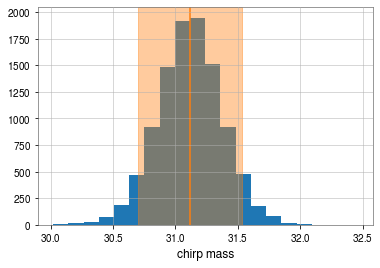

In [60]:
fig, ax = plt.subplots()
ax.hist(result_short1.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

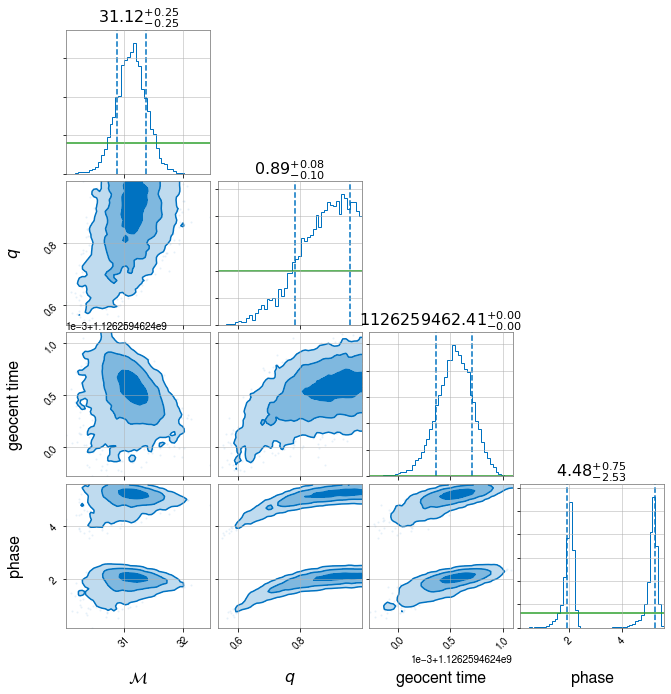

In [61]:
result_short1.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"], priors=True)

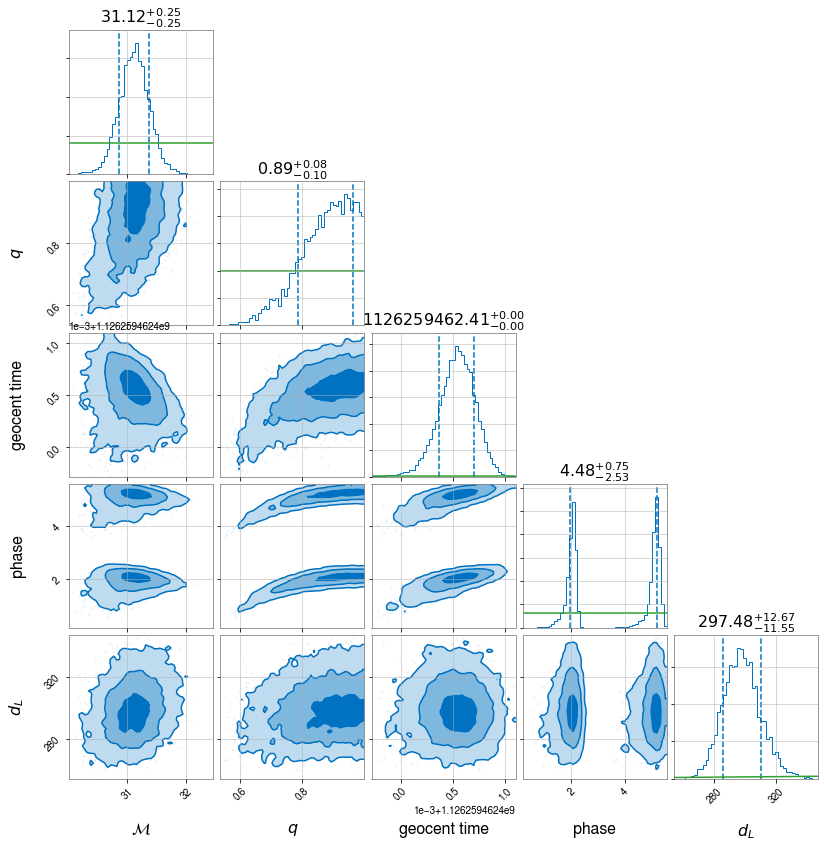

In [64]:
result_short1.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase", "luminosity_distance"], priors=True)

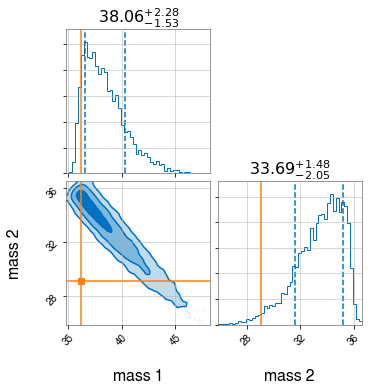

In [67]:
parameters = dict(mass_1=36.2, mass_2=29.1)
result_short1.plot_corner(parameters)

In [68]:
result_short1.priors

{'chirp_mass': Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None),
 'geocent_time': Uniform(minimum=1126259462.3000002, maximum=1126259462.5, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None),
 'a_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_12': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'dec': DeltaFunction(peak=-1.2232, name=None, 

In [69]:
result_short1.sampler_kwargs["nlive"]

1000

In [70]:
print("ln Bayes factor = {} +/- {}".format(
    result_short1.log_bayes_factor, result_short1.log_evidence_err))

ln Bayes factor = 287.4892985657603 +/- 0.10516971858364235


In [71]:
chirp_mass_mean = np.mean(Mc1)
chirp_mass_median = np.median(Mc1)
Mr1 = result_short1.posterior["mass_ratio"].values
mass_ratio_mean = np.mean(Mr1)
mass_ratio_median = np.median(Mr1)

print('The mean of the chirp mass is',chirp_mass_mean)
print('The median of the chirp mass is',chirp_mass_median)
print('The mean of the mass ratio is',mass_ratio_mean)
print('The median of the mass ratio is',mass_ratio_median)

The mean of the chirp mass is 31.118166865979145
The median of the chirp mass is 31.11899061936879
The mean of the mass ratio is 0.8734144855261758
The median of the mass ratio is 0.8861502169604106


In [73]:
m1 = (Mc1*((1+Mr1)**(1/5)))/(Mr1**(3/5))

m2 = m1 * Mr1

m1_mean = np.mean(m1)
m2_mean = np.mean(m2)
m1_median = np.median(m1)
m2_median = np.median(m2)

print('The mean of the first component mass is',m1_mean)
print('The median of the first component mass is',m1_median)
print('The mean of the second component mass is',m2_mean)
print('The median of the second component mass is',m2_median)

The mean of the first component mass is 38.42251070415885
The median of the first component mass is 38.05528588940058
The mean of the second component mass is 33.393033791521674
The median of the second component mass is 33.68878961969101
